In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from scipy.spatial.distance import cdist


############### calibrateCamera ##############

def calibrateCamera(nx, ny):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0), .... , (8,5,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y co-ordinates
    
    for image_path in glob.glob("camera_cal/*.jpg"):
        img = cv2.imread(image_path)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) 
    return ret, mtx, dist

############### getUndistortImage #######################

def getUndistortImage(img, mtx, dist):
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Return undistorted image
    return undistorted_image

############### gaussianBlur #################
def gaussianBlur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

############### applyGradientXThresholds ################

def applySobelThresholds(img, orient='x', sobel_kernel=3, mag_thresh=(0,255)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

############### applyGradientThresholds #################

def applyGradientThresholds(img, sobel_kernel=3, mag_thresh=(0,255), dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Take the absolute value of the gradient direction,
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[((gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])) | ((absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]))] = 1

    # Return the binary image
    return binary_output

############### applyGradientDirThresholds #############

def applyGradientDirThresholds(img, sobelx, sobely, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the absolute value of the gradient direction,
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(absgraddir)
    binary_output[((absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]))] = 1

    # Return the binary image
    return binary_output

############## applyColorThresholds ####################

def applyColorThresholds(img, hls_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_channel_binary = np.zeros_like(s_channel)
    s_channel_binary[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
    
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))
    
    #sensitivity_2 = 60
    #HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    #white_3 = cv2.inRange(img, (200,200,200), (255,255,255))
    #bit_layer = yellow | white | white_2 | white_3
    
    bit_layer = s_channel_binary | yellow | white
    return bit_layer

############### getPerspectiveTransformMatrix ###########

def getPerspectiveTransformMatrix(img):
    src = np.float32([(210, 710), (520, 500), (770, 500), (1100, 710)])
    dst = np.float32([(210, 710), (210, 500), (1100, 500), (1100, 710)])
    
    # Test code for marking points on the image
    pts = np.array([[210, 710],[530, 500],[760, 500],[1100, 710]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(0,255,255))
    plt.show()
    
    # Given src and dst points, calculate the perspective transform matrix
    Mdirect = cv2.getPerspectiveTransform(src, dst)
    Minverse = cv2.getPerspectiveTransform(dst, src)
    return Mdirect, Minverse

###################### getHistogram #####################

def getHistogram(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

###################### find_lane_pixels #################
#########################################################
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]*5//8:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

###################### fit_polynomial ###################

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return left_fitx, right_fitx, ploty, out_img

################## measure_curvature ####################

def measure_curvature(ploty, leftx, rightx):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    leftx = leftx[::-1]  
    rightx = rightx[::-1]  

    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

############### measure_centre_offset ###################

def measure_centre_offset(img, leftx, rightx):
    image_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    num_rows = img.shape[0]
    lane_center = (rightx[num_rows-1] + leftx[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset_value = img_size[0]/2 - lane_center
    direction = "middle"
    if offset_value > 0:
        direction = "right"
    else:
        direction = "left"
    center_offset_pixels = abs(offset_value)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    return center_offset_mtrs, direction

###################### render_lane ######################

def render_lane(image, Minverse, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Draw area between the lane lines with green color
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minverse, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result


Calibrating Camera....
Calibration of Camera done...


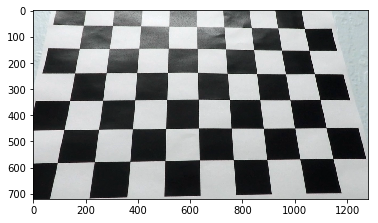

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc

from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML

###################### Line ###########################

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

global last_left_line
global last_right_line
global current_left_line
global current_right_line

last_left_line = Line()
last_right_line = Line()
current_left_line = Line()
current_right_line = Line()


###################### process_image ####################
def process_image(img):
    global mtx
    global dist
    
    global last_left_line
    global last_right_line
    global current_left_line
    global current_right_line
    
    undistorted_image = getUndistortImage(img, mtx, dist)
    #save_image(undistorted_image, "output_images/undistorted_img.png")
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    gaussian_blur_image = gaussianBlur(undistorted_image, kernel_size)
    #save_image(gaussian_blur_image, "output_images/gaussian_blur_image.png")
    
    sobel_binary_image = applySobelThresholds(gaussian_blur_image, orient='x', sobel_kernel=5, mag_thresh=(30,100))
    #save_image(sobel_binary_image, "output_images/sobel_binary_image.png")
    
    color_thresholds_binary_image = applyColorThresholds(gaussian_blur_image, hls_thresh=(130, 255))
    #save_image(color_thresholds_binary_image, "output_images/color_thresholds_binary_image.png")
    
    main_binary_image = cv2.bitwise_or(sobel_binary_image, color_thresholds_binary_image)
    #save_image(main_binary_image, "output_images/main_binary_image.png")
    
    Mdirect, Minverse = getPerspectiveTransformMatrix(img)

    binary_img_size = (main_binary_image.shape[1], main_binary_image.shape[0])
    
    warped_binary_image = cv2.warpPerspective(main_binary_image, Mdirect, binary_img_size, flags=cv2.INTER_LINEAR)
    #save_image(warped_binary_image, "output_images/warped_binary_image.png")
    
    main_img_size = (img.shape[1], img.shape[0])

    warped_img = cv2.warpPerspective(img, Mdirect, main_img_size, flags=cv2.INTER_LINEAR)
    #save_image(warped_img, "output_images/warped_img.png")
    
    left_fitx, right_fitx, ploty, histogram_updated_image = fit_polynomial(warped_binary_image)
    #save_image(histogram_updated_image, "output_images/histogram_updated_image.png")
    
    left_curve_rad, right_curve_rad = measure_curvature(ploty, left_fitx, right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    centre_offset_mtrs, direction = measure_centre_offset(img, left_fitx, right_fitx)
    offset_string = "Center offset: %.2f meters %s of center" % (centre_offset_mtrs, direction)

    final_image = render_lane(img, Minverse, ploty, left_fitx, right_fitx)
    
    cv2.putText(final_image,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(final_image, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    #save_image(final_image, "output_images/final_image.png")
    
    
    return final_image

###################### plot_images ######################
def plot_images(original_image, output_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(original_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(output_image, cmap='gray')
    ax2.set_title('Output Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

###################### save_image# ######################
def save_image(img, path):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    fig.savefig(path)

###################### main() #######################

print('Calibrating Camera....')
ret, mtx, dist = calibrateCamera(9, 6)

img1= cv2.imread("camera_cal/calibration3.jpg")
undistorted_img1 = getUndistortImage(img1, mtx, dist)
save_image(undistorted_img1, "output_images/calibration3_undistorted.png")

print ("Calibration of Camera done...")

test = None

if (test == "image"):
    image_name ="straight_lines1.jpg" #straight_lines2
    img = cv2.imread("test_images/" + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    final_image = process_image(img)
    plot_images(img, final_image)


In [56]:
output_video1 = 'output_videos/project_video_output.mp4'
input_video1 = VideoFileClip("project_video.mp4")
white_clip = input_video1.fl_image(process_image)
%time white_clip.write_videofile(output_video1, audio=False)

271.71227962967254 m 454.07766070502555 m
[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

246.34053794319166 m 292.63092857573497 m


  0%|                                                                                 | 1/1261 [00:00<02:24,  8.75it/s]

282.43051388488624 m 437.7049354310352 m


  0%|▏                                                                                | 2/1261 [00:00<02:31,  8.33it/s]

283.01875954744446 m 412.64171875668336 m


  0%|▏                                                                                | 3/1261 [00:00<02:25,  8.65it/s]

295.65667572367715 m 311.1261374247613 m
306.2159252631145 m 292.2227404965036 m


  0%|▎                                                                                | 5/1261 [00:00<02:21,  8.88it/s]

324.5144003485591 m 334.59812451728976 m
317.61198847320634 m 377.69113483895853 m


  1%|▍                                                                                | 7/1261 [00:00<02:16,  9.19it/s]

339.92083513191386 m 708.2381232298208 m


  1%|▌                                                                                | 8/1261 [00:00<02:16,  9.18it/s]

358.6362401959518 m 642.9845540735392 m


  1%|▌                                                                                | 9/1261 [00:00<02:15,  9.25it/s]

340.1151626166134 m 561.7209270018632 m


  1%|▋                                                                               | 10/1261 [00:01<02:14,  9.29it/s]

381.331890136864 m 432.8155320257384 m


  1%|▋                                                                               | 11/1261 [00:01<02:12,  9.43it/s]

401.38078668926954 m 620.8974749912418 m
406.1497427173806 m 513.3744027983925 m


  1%|▊                                                                               | 13/1261 [00:01<02:08,  9.72it/s]

416.79476719704724 m 429.26757330175076 m
363.9182904785014 m 351.67971478889007 m


  1%|▉                                                                               | 15/1261 [00:01<02:03, 10.10it/s]

392.37916787914827 m 282.4592439473408 m
371.8095234123271 m 294.4331436282849 m


  1%|█                                                                               | 17/1261 [00:01<02:00, 10.31it/s]

362.8496693252424 m 340.2332314029559 m
381.6820327457046 m 338.27649180133113 m


  2%|█▏                                                                              | 19/1261 [00:01<01:58, 10.47it/s]

373.8111147003104 m 355.46575458233195 m
412.81372110921916 m 369.3873333614392 m


  2%|█▎                                                                              | 21/1261 [00:02<01:56, 10.64it/s]

418.13445916052734 m 392.4974054506455 m
429.84247519399315 m 408.59728001422036 m


  2%|█▍                                                                              | 23/1261 [00:02<01:55, 10.68it/s]

402.9546545319288 m 477.6786408574682 m
363.8054341237037 m 330.5663817531239 m


  2%|█▌                                                                              | 25/1261 [00:02<01:58, 10.46it/s]

368.7663728393751 m 381.119059873948 m
324.322274584859 m 367.34124179734636 m


  2%|█▋                                                                              | 27/1261 [00:02<01:58, 10.39it/s]

329.58884053287807 m 374.9748574334668 m
306.5409484444066 m 361.1961019246704 m


  2%|█▊                                                                              | 29/1261 [00:02<01:55, 10.67it/s]

292.5613674513708 m 321.90843913932014 m
282.10818242235456 m 242.8585200692099 m


  2%|█▉                                                                              | 31/1261 [00:03<02:00, 10.24it/s]

252.43442787234974 m 275.40954831396556 m
251.22733093675618 m 294.52328592891956 m


  3%|██                                                                              | 33/1261 [00:03<02:01, 10.08it/s]

239.07115925125214 m 307.79181821937215 m
231.97915553210197 m 294.20404865008516 m


  3%|██▏                                                                             | 35/1261 [00:03<02:01, 10.08it/s]

232.3020507422716 m 278.0877671300033 m
226.93815646784805 m 268.387765563867 m


  3%|██▎                                                                             | 37/1261 [00:03<01:58, 10.30it/s]

213.28809828200633 m 244.54811992491472 m
205.65491336370988 m 233.76919234986033 m


  3%|██▍                                                                             | 39/1261 [00:03<02:02, 10.00it/s]

211.24645705714184 m 226.53112819231194 m
215.47374407014485 m 226.930680725755 m


  3%|██▌                                                                             | 41/1261 [00:04<02:01, 10.08it/s]

221.08036111867628 m 238.64879981637895 m
246.77786444002876 m 250.5270281894091 m


  3%|██▋                                                                             | 43/1261 [00:04<02:02,  9.91it/s]

252.95984838595936 m 259.9529417297984 m


  3%|██▊                                                                             | 44/1261 [00:04<02:09,  9.37it/s]

274.2209739384045 m 275.2030661817335 m
282.7510261206075 m 312.32724248625107 m


  4%|██▉                                                                             | 46/1261 [00:04<02:05,  9.71it/s]

288.56288391948266 m 372.5332891061577 m


  4%|██▉                                                                             | 47/1261 [00:04<02:12,  9.17it/s]

292.33655819462643 m 297.31032806278375 m
336.59290464933076 m 324.7838192331069 m


  4%|███                                                                             | 49/1261 [00:04<02:11,  9.24it/s]

345.98764997435734 m 282.76574571848363 m
353.51786335128486 m 375.9240898106386 m


  4%|███▏                                                                            | 51/1261 [00:05<02:09,  9.37it/s]

360.43942502914376 m 326.1394866350624 m


  4%|███▎                                                                            | 52/1261 [00:05<02:13,  9.07it/s]

363.5511072556259 m 277.7181624198407 m


  4%|███▎                                                                            | 53/1261 [00:05<02:14,  9.00it/s]

359.36215491313396 m 268.5870074239729 m
380.26774876054543 m 285.1062024098825 m


  4%|███▍                                                                            | 55/1261 [00:05<02:08,  9.41it/s]

397.6613845285439 m 314.18680935690116 m


  4%|███▌                                                                            | 56/1261 [00:05<02:12,  9.08it/s]

401.49208902755214 m 334.8993752747717 m
398.8932377809047 m 443.6983152652881 m


  5%|███▋                                                                            | 58/1261 [00:05<02:06,  9.53it/s]

380.22526904859467 m 367.75743965352103 m


  5%|███▋                                                                            | 59/1261 [00:05<02:07,  9.41it/s]

377.65255234794705 m 318.6829184638542 m
394.5800745512789 m 301.3867865281367 m


  5%|███▊                                                                            | 61/1261 [00:06<02:02,  9.77it/s]

345.8712180282327 m 281.4423358331303 m


  5%|███▉                                                                            | 62/1261 [00:06<02:02,  9.80it/s]

381.5317487119356 m 300.116506518368 m
354.0186838157009 m 276.88985167030825 m


  5%|████                                                                            | 64/1261 [00:06<01:58, 10.09it/s]

380.15815412142075 m 273.7739143849146 m
370.8399899238883 m 297.78842795201365 m


  5%|████▏                                                                           | 66/1261 [00:06<01:58, 10.10it/s]

350.05428336093274 m 314.15947179985227 m
377.95580825072193 m 291.58379083139573 m


  5%|████▎                                                                           | 68/1261 [00:06<01:56, 10.25it/s]

353.62687007515734 m 269.26306544586924 m
399.7592402029452 m 285.97600020246733 m


  6%|████▍                                                                           | 70/1261 [00:07<01:54, 10.42it/s]

377.1430720081536 m 223.60174687489834 m
392.1182083585266 m 241.58692922437697 m


  6%|████▌                                                                           | 72/1261 [00:07<01:53, 10.44it/s]

392.0248354886605 m 242.2008048554931 m
404.11874876719054 m 239.19203835322637 m


  6%|████▋                                                                           | 74/1261 [00:07<01:53, 10.46it/s]

445.93070692415375 m 264.0297199516962 m
433.5420942461257 m 282.84347860216616 m


  6%|████▊                                                                           | 76/1261 [00:07<01:52, 10.49it/s]

446.6928241729376 m 275.85434002484976 m
501.8254939425375 m 294.44114866062364 m


  6%|████▉                                                                           | 78/1261 [00:07<01:51, 10.64it/s]

513.4392101672302 m 276.91846699214784 m
489.4838766881372 m 277.3468940869647 m


  6%|█████                                                                           | 80/1261 [00:07<01:51, 10.58it/s]

468.18892606589066 m 282.66551875746603 m
469.2076893638791 m 292.42124665685225 m


  7%|█████▏                                                                          | 82/1261 [00:08<01:52, 10.47it/s]

456.2779352494667 m 375.9213083152045 m
460.993154170886 m 367.71414388125237 m


  7%|█████▎                                                                          | 84/1261 [00:08<01:51, 10.55it/s]

444.1805162434349 m 439.227367950121 m
392.83500877194285 m 453.8936368206045 m


  7%|█████▍                                                                          | 86/1261 [00:08<01:52, 10.47it/s]

332.86726692071375 m 343.3881092605441 m
307.95746830225625 m 287.68567098467577 m


  7%|█████▌                                                                          | 88/1261 [00:08<01:50, 10.58it/s]

280.2778749710192 m 291.4993975640251 m
254.45561334426668 m 244.74383410097414 m


  7%|█████▋                                                                          | 90/1261 [00:08<01:50, 10.57it/s]

262.07015730470295 m 257.1191744016364 m
275.3010961622768 m 265.14136839319485 m


  7%|█████▊                                                                          | 92/1261 [00:09<01:49, 10.68it/s]

273.2316033243735 m 303.9440924782681 m
262.27852496680913 m 287.53964075555194 m


  7%|█████▉                                                                          | 94/1261 [00:09<01:47, 10.83it/s]

276.39438830780557 m 301.23736670026324 m
271.22827140483656 m 269.0440442418666 m


  8%|██████                                                                          | 96/1261 [00:09<01:50, 10.56it/s]

272.51688802314993 m 286.66371697181853 m
289.2365584429506 m 282.12275752586856 m


  8%|██████▏                                                                         | 98/1261 [00:09<01:48, 10.73it/s]

268.7915380117787 m 249.8487248129569 m
274.7044736107334 m 249.2156372607588 m


  8%|██████▎                                                                        | 100/1261 [00:09<01:46, 10.90it/s]

266.7767648403172 m 258.12562884087015 m
269.4035006603329 m 249.62395713486077 m


  8%|██████▍                                                                        | 102/1261 [00:10<01:47, 10.78it/s]

273.9957201302192 m 244.15152147924343 m
273.92768863878916 m 222.1067976421307 m


  8%|██████▌                                                                        | 104/1261 [00:10<01:46, 10.85it/s]

282.8209530187644 m 223.9486272979532 m
301.4431862860441 m 229.94735848064968 m


  8%|██████▋                                                                        | 106/1261 [00:10<01:44, 11.08it/s]

294.85640796822935 m 224.32286670286004 m
268.5703826071796 m 254.12988143222128 m


  9%|██████▊                                                                        | 108/1261 [00:10<01:44, 11.06it/s]

277.6352380527082 m 304.8267263111365 m
272.1453613847319 m 295.82655431971455 m


  9%|██████▉                                                                        | 110/1261 [00:10<01:42, 11.20it/s]

274.33337123042884 m 237.23438654235557 m
293.4987861403509 m 255.78223060241254 m


  9%|███████                                                                        | 112/1261 [00:10<01:43, 11.07it/s]

276.6689211341403 m 260.05477459755946 m
267.6571296453601 m 272.636593393043 m


  9%|███████▏                                                                       | 114/1261 [00:11<01:43, 11.13it/s]

245.7245872865479 m 230.70499534143224 m
246.99314543101096 m 212.33401752271996 m


  9%|███████▎                                                                       | 116/1261 [00:11<01:41, 11.27it/s]

256.34596787414347 m 211.60224256596624 m
245.43997973848525 m 231.08489321325905 m


  9%|███████▍                                                                       | 118/1261 [00:11<01:45, 10.79it/s]

250.1220178770612 m 252.36592356285243 m
231.55027751737862 m 257.8563688099499 m


 10%|███████▌                                                                       | 120/1261 [00:11<01:47, 10.63it/s]

241.90876184201755 m 237.9583470261107 m
245.61333503687607 m 268.5632339643581 m


 10%|███████▋                                                                       | 122/1261 [00:11<01:48, 10.48it/s]

241.29369426727175 m 225.85286214391735 m
239.09357289000113 m 225.382356904674 m


 10%|███████▊                                                                       | 124/1261 [00:12<01:46, 10.65it/s]

236.3722292576273 m 253.28916419762908 m
247.91637802807296 m 252.98743998912352 m


 10%|███████▉                                                                       | 126/1261 [00:12<01:46, 10.67it/s]

260.157052480601 m 269.23847755891927 m
257.8759633305179 m 269.1989367525282 m


 10%|████████                                                                       | 128/1261 [00:12<01:43, 10.99it/s]

250.56281786759348 m 246.92435363936036 m
273.6094411504532 m 272.03894554966587 m


 10%|████████▏                                                                      | 130/1261 [00:12<01:42, 11.02it/s]

279.1400146876113 m 264.6956690607289 m
280.4427476411999 m 236.3747967687039 m


 10%|████████▎                                                                      | 132/1261 [00:12<01:42, 11.02it/s]

288.52536599258445 m 291.67218000368456 m
296.9186430303266 m 256.81834558496143 m


 11%|████████▍                                                                      | 134/1261 [00:12<01:42, 10.98it/s]

306.3515734420452 m 278.33504262541214 m
307.22175035048383 m 273.88687145186185 m


 11%|████████▌                                                                      | 136/1261 [00:13<01:43, 10.92it/s]

326.3995094236171 m 276.44191294905966 m
366.90548565181194 m 297.86286889678496 m


 11%|████████▋                                                                      | 138/1261 [00:13<01:40, 11.13it/s]

339.95057977780414 m 311.18815673767415 m
349.8949551087871 m 328.1354530039066 m


 11%|████████▊                                                                      | 140/1261 [00:13<01:40, 11.10it/s]

366.73489759266084 m 334.42691622984995 m
373.27173054223397 m 281.1185483611003 m


 11%|████████▉                                                                      | 142/1261 [00:13<01:40, 11.19it/s]

355.01982262811083 m 302.55122405722784 m
374.5787423317497 m 323.8676227355874 m


 11%|█████████                                                                      | 144/1261 [00:13<01:38, 11.29it/s]

363.0820098019974 m 347.8458394927551 m
354.2299823873889 m 358.0727768763576 m


 12%|█████████▏                                                                     | 146/1261 [00:14<01:40, 11.11it/s]

336.75400092659913 m 363.53883815697145 m
301.06426979575633 m 281.9015196894955 m


 12%|█████████▎                                                                     | 148/1261 [00:14<01:39, 11.14it/s]

292.1824912249545 m 283.753399626269 m
304.54862849943885 m 301.42676536634514 m


 12%|█████████▍                                                                     | 150/1261 [00:14<01:38, 11.31it/s]

308.5847705388342 m 307.2186660108116 m
326.8161670565241 m 306.85998982834434 m


 12%|█████████▌                                                                     | 152/1261 [00:14<01:40, 11.05it/s]

304.00979967165637 m 250.42506988910506 m
321.7326944264756 m 263.94026591959806 m


 12%|█████████▋                                                                     | 154/1261 [00:14<01:41, 10.94it/s]

329.8280935039835 m 269.73359119037514 m
339.4537944381159 m 310.60820159227745 m


 12%|█████████▊                                                                     | 156/1261 [00:14<01:40, 10.96it/s]

331.04144185403953 m 329.0256396797361 m
307.4854427014978 m 274.63209805648944 m


 13%|█████████▉                                                                     | 158/1261 [00:15<01:41, 10.82it/s]

302.5206118855033 m 277.88359172916415 m
297.0348150019761 m 252.3510399545436 m


 13%|██████████                                                                     | 160/1261 [00:15<01:41, 10.84it/s]

303.2112336270158 m 261.89507973046045 m
311.5187085013834 m 285.8926963013293 m


 13%|██████████▏                                                                    | 162/1261 [00:15<01:40, 10.90it/s]

331.56246707591157 m 323.07875624263716 m
301.2398526096933 m 235.2305746143123 m


 13%|██████████▎                                                                    | 164/1261 [00:15<01:43, 10.63it/s]

284.86102507587265 m 209.94938054492053 m
280.2282006993403 m 193.31114324337156 m


 13%|██████████▍                                                                    | 166/1261 [00:15<01:40, 10.85it/s]

271.3755232183196 m 203.7512298917402 m
317.55346407649535 m 216.09765054729155 m


 13%|██████████▌                                                                    | 168/1261 [00:16<01:41, 10.73it/s]

305.2190925765426 m 203.43000243785897 m
346.69050461256785 m 200.3508870239977 m


 13%|██████████▋                                                                    | 170/1261 [00:16<01:40, 10.90it/s]

323.1209828266091 m 195.2587575358594 m
336.99459773359933 m 171.05588451159917 m


 14%|██████████▊                                                                    | 172/1261 [00:16<01:37, 11.12it/s]

327.03867625213195 m 185.98741380768803 m
288.91549290087664 m 175.2939110220322 m


 14%|██████████▉                                                                    | 174/1261 [00:16<01:40, 10.85it/s]

274.1903491682548 m 181.81506157148974 m
273.0433509061253 m 186.291778646756 m


 14%|███████████                                                                    | 176/1261 [00:16<01:38, 11.01it/s]

297.1851493336019 m 197.22100161968953 m
283.8250022531144 m 184.28494518552066 m


 14%|███████████▏                                                                   | 178/1261 [00:16<01:37, 11.11it/s]

276.7573979485015 m 176.0258102746635 m
277.8019665982206 m 198.0830026796735 m


 14%|███████████▎                                                                   | 180/1261 [00:17<01:39, 10.83it/s]

260.45434681175334 m 200.07552064773643 m
256.0483195981264 m 216.06645442814207 m


 14%|███████████▍                                                                   | 182/1261 [00:17<01:40, 10.69it/s]

241.91983471204628 m 210.80775759761326 m
224.1695124471631 m 209.5851716974828 m


 15%|███████████▌                                                                   | 184/1261 [00:17<01:38, 10.98it/s]

215.44529807248665 m 223.50779204039932 m
191.3157654525416 m 190.81058538197382 m


 15%|███████████▋                                                                   | 186/1261 [00:17<01:37, 11.05it/s]

191.00129989126452 m 202.05987161587066 m
185.96466879823134 m 192.48574605988182 m


 15%|███████████▊                                                                   | 188/1261 [00:17<01:39, 10.81it/s]

189.73141034697102 m 198.8068939247312 m
190.9652042168414 m 212.5700972647478 m


 15%|███████████▉                                                                   | 190/1261 [00:18<01:37, 11.01it/s]

189.24188608465641 m 205.17134094707168 m
203.31227054394708 m 183.4183204870826 m


 15%|████████████                                                                   | 192/1261 [00:18<01:37, 10.94it/s]

199.21096713985958 m 187.94440116674505 m
208.04009050051056 m 192.37138250488692 m


 15%|████████████▏                                                                  | 194/1261 [00:18<01:37, 10.93it/s]

211.20251016240368 m 199.3163769155968 m
248.7603611957556 m 229.89025235847186 m


 16%|████████████▎                                                                  | 196/1261 [00:18<01:37, 10.98it/s]

285.9245334394689 m 258.0823127311434 m
339.21274614715503 m 311.23452789674354 m


 16%|████████████▍                                                                  | 198/1261 [00:18<01:39, 10.72it/s]

384.00086530398056 m 308.75534367090046 m
392.5838731800431 m 373.6281911346641 m


 16%|████████████▌                                                                  | 200/1261 [00:18<01:38, 10.72it/s]

396.9155699692066 m 363.5247511879624 m
346.3887035126228 m 282.1644344548382 m


 16%|████████████▋                                                                  | 202/1261 [00:19<01:37, 10.81it/s]

326.94236187500655 m 281.4397117145883 m
322.86469146773015 m 274.3556631566851 m


 16%|████████████▊                                                                  | 204/1261 [00:19<01:38, 10.71it/s]

303.5851799564297 m 249.68852763150608 m
301.4755355988297 m 284.36296557069045 m


 16%|████████████▉                                                                  | 206/1261 [00:19<01:38, 10.73it/s]

262.758706794663 m 290.87601621164924 m
243.8473591580679 m 292.4267877503325 m


 16%|█████████████                                                                  | 208/1261 [00:19<01:37, 10.80it/s]

257.9299570284612 m 273.0002811246474 m
281.50325741292653 m 341.9533404904745 m


 17%|█████████████▏                                                                 | 210/1261 [00:19<01:36, 10.87it/s]

287.36005151266795 m 357.8135609652414 m
285.1792856872721 m 361.3629120974561 m


 17%|█████████████▎                                                                 | 212/1261 [00:20<01:41, 10.32it/s]

288.76068834644565 m 424.50762644230394 m
286.79448314952236 m 351.8076804487803 m


 17%|█████████████▍                                                                 | 214/1261 [00:20<01:40, 10.44it/s]

274.84292470884975 m 346.75163558398566 m
269.0867873107869 m 289.0125399028899 m


 17%|█████████████▌                                                                 | 216/1261 [00:20<01:40, 10.41it/s]

279.6974658808508 m 288.16174804176586 m
298.9715479824039 m 295.5143390916918 m


 17%|█████████████▋                                                                 | 218/1261 [00:20<01:37, 10.69it/s]

299.6778579679102 m 328.2587905320952 m
328.43945317550526 m 361.76190940187826 m


 17%|█████████████▊                                                                 | 220/1261 [00:20<01:37, 10.66it/s]

334.83523449831046 m 363.1083283925378 m
365.21852453992966 m 315.67909560125014 m


 18%|█████████████▉                                                                 | 222/1261 [00:21<01:36, 10.75it/s]

382.9931391853956 m 359.56712532211 m
350.42967917570405 m 303.6723293800424 m


 18%|██████████████                                                                 | 224/1261 [00:21<01:37, 10.67it/s]

363.705138635153 m 281.46133125483914 m
336.90253200238266 m 283.1930722996399 m


 18%|██████████████▏                                                                | 226/1261 [00:21<01:35, 10.83it/s]

359.61149948011234 m 259.03090213191325 m
386.0043107827834 m 257.26666202012757 m


 18%|██████████████▎                                                                | 228/1261 [00:21<01:34, 10.94it/s]

402.9656463454474 m 235.74761493302216 m
456.8543222087058 m 250.35168563588286 m


 18%|██████████████▍                                                                | 230/1261 [00:21<01:34, 10.94it/s]

448.59661758921044 m 243.36538481692298 m
467.58111180885714 m 240.41093483687257 m


 18%|██████████████▌                                                                | 232/1261 [00:21<01:33, 11.02it/s]

475.8518015051686 m 231.7000092195527 m
456.01896016092985 m 224.84475340046404 m


 19%|██████████████▋                                                                | 234/1261 [00:22<01:33, 11.00it/s]

428.5610072177657 m 236.49817121851763 m
368.34492749090003 m 218.5816047513478 m


 19%|██████████████▊                                                                | 236/1261 [00:22<01:32, 11.03it/s]

361.8239822990641 m 232.74806931476905 m
338.3400044198522 m 206.10600789197557 m


 19%|██████████████▉                                                                | 238/1261 [00:22<01:32, 11.01it/s]

320.0842299668958 m 202.47790200416048 m
326.5471662335917 m 202.96935228664717 m


 19%|███████████████                                                                | 240/1261 [00:22<01:31, 11.10it/s]

325.1145812877623 m 226.91667189992978 m
346.4718552002278 m 231.2040876639931 m


 19%|███████████████▏                                                               | 242/1261 [00:22<01:32, 10.97it/s]

317.16282313942924 m 223.2611899662864 m
324.8124039873589 m 192.77087604727544 m


 19%|███████████████▎                                                               | 244/1261 [00:23<01:32, 10.98it/s]

307.29919202684334 m 208.1363681526132 m
299.8560598502861 m 219.97637845795614 m


 20%|███████████████▍                                                               | 246/1261 [00:23<01:32, 11.03it/s]

305.49165734981597 m 225.6720505139501 m
288.62951975101083 m 191.28144646390544 m


 20%|███████████████▌                                                               | 248/1261 [00:23<01:32, 10.99it/s]

312.5772628991465 m 192.82686366279512 m
314.3283592496296 m 219.2209129707139 m


 20%|███████████████▋                                                               | 250/1261 [00:23<01:31, 11.07it/s]

311.9886131895745 m 228.6952213734246 m
324.94905558297137 m 241.36287602390803 m


 20%|███████████████▊                                                               | 252/1261 [00:23<01:30, 11.09it/s]

331.2063416947658 m 252.366592349609 m
350.5118498324557 m 256.5662431289388 m


 20%|███████████████▉                                                               | 254/1261 [00:23<01:29, 11.26it/s]

323.5575123582232 m 223.28451607548132 m
351.83830024139854 m 215.870060551634 m


 20%|████████████████                                                               | 256/1261 [00:24<01:30, 11.06it/s]

324.27723063876573 m 209.46944033442432 m
326.56665131533555 m 229.50013879996055 m


 20%|████████████████▏                                                              | 258/1261 [00:24<01:31, 10.99it/s]

325.54023613638697 m 229.46488175335864 m
309.72709809245885 m 238.88536614623789 m


 21%|████████████████▎                                                              | 260/1261 [00:24<01:30, 11.05it/s]

347.756761350042 m 240.00753581225197 m
343.7805160058442 m 233.14068202002616 m


 21%|████████████████▍                                                              | 262/1261 [00:24<01:29, 11.14it/s]

346.5379755390963 m 243.1298765049579 m
340.64786644828155 m 252.28864401346164 m


 21%|████████████████▌                                                              | 264/1261 [00:24<01:29, 11.12it/s]

358.6985188214685 m 293.1670701523344 m
376.07379480866643 m 271.1166213201302 m


 21%|████████████████▋                                                              | 266/1261 [00:25<01:30, 11.05it/s]

355.7927760151327 m 296.8236923985414 m
376.81540462265843 m 313.52718780989176 m


 21%|████████████████▊                                                              | 268/1261 [00:25<01:31, 10.86it/s]

397.70418810385917 m 343.3406143218092 m
381.1192520760645 m 400.89553108592486 m


 21%|████████████████▉                                                              | 270/1261 [00:25<01:33, 10.63it/s]

375.33230636102223 m 364.8081763313435 m
358.5767070741692 m 331.54033358296783 m


 22%|█████████████████                                                              | 272/1261 [00:25<01:32, 10.74it/s]

359.6319551968347 m 335.483394867465 m
353.8734645629171 m 328.88273173622076 m


 22%|█████████████████▏                                                             | 274/1261 [00:25<01:31, 10.77it/s]

355.0606841542411 m 328.35375191844315 m
373.47545228747737 m 331.2896553967637 m


 22%|█████████████████▎                                                             | 276/1261 [00:25<01:31, 10.78it/s]

404.8414917853287 m 358.9694223531917 m
426.91825265830335 m 369.1908608474885 m


 22%|█████████████████▍                                                             | 278/1261 [00:26<01:31, 10.76it/s]

431.9476794231251 m 329.69090451427166 m
443.7237502477026 m 344.7471730088694 m


 22%|█████████████████▌                                                             | 280/1261 [00:26<01:30, 10.78it/s]

467.33575733831765 m 330.8615900652468 m
445.1415753035752 m 254.2797169489245 m


 22%|█████████████████▋                                                             | 282/1261 [00:26<01:31, 10.68it/s]

468.3148187550739 m 276.31833771055346 m
479.37008644943717 m 286.5488244246402 m


 23%|█████████████████▊                                                             | 284/1261 [00:26<01:31, 10.69it/s]

487.47652834163836 m 309.54224131452435 m
511.6608463712437 m 293.97400269201955 m


 23%|█████████████████▉                                                             | 286/1261 [00:26<01:31, 10.60it/s]

510.3225407266033 m 306.8168034386011 m
555.8070654492924 m 308.84668014052204 m


 23%|██████████████████                                                             | 288/1261 [00:27<01:31, 10.62it/s]

516.3970029411064 m 411.44855986579654 m
579.3182795559484 m 430.14827119917817 m


 23%|██████████████████▏                                                            | 290/1261 [00:27<01:31, 10.65it/s]

558.1080556725243 m 440.4818623703659 m
560.2081886677274 m 430.59739790886147 m


 23%|██████████████████▎                                                            | 292/1261 [00:27<01:32, 10.49it/s]

570.1185616813392 m 371.5422238773616 m
566.0146424256435 m 354.8762478088027 m


 23%|██████████████████▍                                                            | 294/1261 [00:27<01:36,  9.97it/s]

594.817897545299 m 405.27672852903623 m
719.4127631372272 m 418.69445002829264 m


 23%|██████████████████▌                                                            | 296/1261 [00:27<01:35, 10.09it/s]

783.0362312239002 m 500.44869539033596 m
767.2433026833303 m 522.9224982590359 m


 24%|██████████████████▋                                                            | 298/1261 [00:28<01:34, 10.23it/s]

852.0581421802507 m 627.8928979488926 m
894.726225449399 m 596.3896150556267 m


 24%|██████████████████▊                                                            | 300/1261 [00:28<01:33, 10.32it/s]

960.0173205373652 m 824.5657139805262 m
1123.4767710326353 m 817.4501331471216 m


 24%|██████████████████▉                                                            | 302/1261 [00:28<01:32, 10.36it/s]

1127.0576356205002 m 1160.4177667536521 m
994.4728961780801 m 1810.7180721449006 m


 24%|███████████████████                                                            | 304/1261 [00:28<01:31, 10.42it/s]

1305.3335975114808 m 10621.563516047636 m
1476.7177891972258 m 652.6444860152693 m


 24%|███████████████████▏                                                           | 306/1261 [00:28<01:31, 10.41it/s]

1830.8390729208586 m 2976.4026261466483 m
1959.0568815898607 m 759.0644959956114 m


 24%|███████████████████▎                                                           | 308/1261 [00:29<01:32, 10.35it/s]

2431.297951222482 m 750.06670928863 m
2440.310966406688 m 946.8540452355685 m


 25%|███████████████████▍                                                           | 310/1261 [00:29<01:31, 10.41it/s]

2837.994959795404 m 997.5779653163866 m
2911.788930426633 m 1178.468644102422 m


 25%|███████████████████▌                                                           | 312/1261 [00:29<01:30, 10.44it/s]

7994.685977659194 m 681.3967856726526 m
14321.16024392678 m 671.2800443569516 m


 25%|███████████████████▋                                                           | 314/1261 [00:29<01:33, 10.12it/s]

29118.99323753202 m 564.8240053236232 m
28441.704422759994 m 542.1266299901865 m


 25%|███████████████████▊                                                           | 316/1261 [00:29<01:33, 10.14it/s]

9869.269949248455 m 487.80701598795685 m
28672.379401059516 m 705.7156673884828 m


 25%|███████████████████▉                                                           | 318/1261 [00:30<01:32, 10.20it/s]

7939.843069108596 m 717.3929459667258 m
8187.818373129274 m 908.1972279800924 m


 25%|████████████████████                                                           | 320/1261 [00:30<01:32, 10.22it/s]

6068.707731026499 m 1094.9185476787552 m
6242.855262247612 m 1025.6296290609725 m


 26%|████████████████████▏                                                          | 322/1261 [00:30<01:30, 10.34it/s]

3395.2923506497623 m 1551.477092002517 m
4424.438652456443 m 1299.0915624415993 m


 26%|████████████████████▎                                                          | 324/1261 [00:30<01:30, 10.38it/s]

2753.143292827336 m 1076.306562186756 m
2583.8887572623485 m 1224.6954356416907 m


 26%|████████████████████▍                                                          | 326/1261 [00:30<01:29, 10.42it/s]

3342.983054745242 m 1363.607421812023 m
3461.519733714866 m 1517.3286055468172 m


 26%|████████████████████▌                                                          | 328/1261 [00:30<01:29, 10.44it/s]

3114.694248889503 m 5936.680444529853 m
3286.225426232867 m 768.8419483372836 m


 26%|████████████████████▋                                                          | 330/1261 [00:31<01:30, 10.33it/s]

5050.715966077043 m 782.5677879542135 m
6312.998026449598 m 2702.7111921550304 m


 26%|████████████████████▊                                                          | 332/1261 [00:31<01:30, 10.30it/s]

8432.998216413049 m 1466.1129186901633 m
6087.005784307298 m 1987.6775960863772 m


 26%|████████████████████▉                                                          | 334/1261 [00:31<01:29, 10.41it/s]

30240.0711816714 m 2705.824910426601 m
7046.992600896898 m 2325.452090804316 m


 27%|█████████████████████                                                          | 336/1261 [00:31<01:28, 10.47it/s]

9916.561832279624 m 3344.4756753437487 m
6726.808184496578 m 13031.569976266248 m


 27%|█████████████████████▏                                                         | 338/1261 [00:31<01:27, 10.54it/s]

34528.94371770546 m 2885.093964574636 m
7343.404674648797 m 1027.3053619034563 m


 27%|█████████████████████▎                                                         | 340/1261 [00:32<01:27, 10.55it/s]

4165.908842147087 m 887.8772021347489 m
1760.1934700664049 m 1175.491754010469 m


 27%|█████████████████████▍                                                         | 342/1261 [00:32<01:27, 10.53it/s]

1791.6331953175797 m 1115.7769161008332 m
1586.5440240141581 m 1086.6596124942184 m


 27%|█████████████████████▌                                                         | 344/1261 [00:32<01:27, 10.54it/s]

1761.896998155043 m 1066.3355861993832 m
1816.9986679514247 m 973.3757258096024 m


 27%|█████████████████████▋                                                         | 346/1261 [00:32<01:25, 10.70it/s]

2185.499320312749 m 1657.038353257927 m
3157.9852989852557 m 1460.1365746023848 m


 28%|█████████████████████▊                                                         | 348/1261 [00:32<01:26, 10.58it/s]

1508.380561163636 m 2346.379469425948 m
2930.457320226696 m 2060.4371744767377 m


 28%|█████████████████████▉                                                         | 350/1261 [00:33<01:25, 10.69it/s]

1365.6558990030928 m 3229.5491451902576 m
1852.8682285477837 m 1817.9922002530348 m


 28%|██████████████████████                                                         | 352/1261 [00:33<01:25, 10.63it/s]

2133.8154691135283 m 2723.023192390268 m
2904.3585653720643 m 1323.3846379044041 m


 28%|██████████████████████▏                                                        | 354/1261 [00:33<01:24, 10.71it/s]

6143.593972579352 m 1182.6946664964923 m
8887.879052202285 m 731.3051123299334 m


 28%|██████████████████████▎                                                        | 356/1261 [00:33<01:25, 10.61it/s]

1541.107104029578 m 855.5119079814523 m
1336.9670552125638 m 910.8914693305132 m


 28%|██████████████████████▍                                                        | 358/1261 [00:33<01:26, 10.50it/s]

922.9165703623951 m 2651.458783592662 m
872.4814703235669 m 1856.3273242722348 m


 29%|██████████████████████▌                                                        | 360/1261 [00:33<01:23, 10.82it/s]

812.7103528575187 m 3406.3361176578333 m
800.4979131333923 m 2271.345289678602 m


 29%|██████████████████████▋                                                        | 362/1261 [00:34<01:23, 10.76it/s]

712.9727680204695 m 2778.4362052723286 m
749.4945615238811 m 900.8830251654271 m


 29%|██████████████████████▊                                                        | 364/1261 [00:34<01:23, 10.73it/s]

708.8119661889765 m 835.8261233404812 m
732.2899949135166 m 1086.1571202613527 m


 29%|██████████████████████▉                                                        | 366/1261 [00:34<01:23, 10.75it/s]

927.0438902239376 m 1186.4358828225043 m
843.2132521611367 m 1476.5378441986777 m


 29%|███████████████████████                                                        | 368/1261 [00:34<01:22, 10.84it/s]

1021.6051123950591 m 11392.610715444518 m
1143.1022491705974 m 5944.476216867816 m


 29%|███████████████████████▏                                                       | 370/1261 [00:34<01:23, 10.67it/s]

1733.4546595767388 m 10662.030455443317 m
1694.6467107278409 m 19123.732950695685 m


 30%|███████████████████████▎                                                       | 372/1261 [00:35<01:24, 10.50it/s]

2578.7569802239777 m 202166.4945383785 m
5773.579254425256 m 3032.6849414234157 m


 30%|███████████████████████▍                                                       | 374/1261 [00:35<01:25, 10.32it/s]

17652.006458279917 m 5954.747544835197 m
3055.658714057221 m 1450.976063427623 m


 30%|███████████████████████▌                                                       | 376/1261 [00:35<01:24, 10.52it/s]

2320.1504585488683 m 1349.8504565064952 m
1869.6449164375151 m 1335.4981927572255 m


 30%|███████████████████████▋                                                       | 378/1261 [00:35<01:23, 10.55it/s]

1414.597633968989 m 1457.9151585838363 m
1464.201975781158 m 2147.3122251835252 m


 30%|███████████████████████▊                                                       | 380/1261 [00:35<01:23, 10.58it/s]

1517.5723406225547 m 2276.867302291904 m
1508.979649525819 m 1406.0615193172182 m


 30%|███████████████████████▉                                                       | 382/1261 [00:36<01:23, 10.56it/s]

1399.1656012748351 m 2090.4698048537293 m
1397.3327552536207 m 34539.74218964812 m


 30%|████████████████████████                                                       | 384/1261 [00:36<01:22, 10.57it/s]

1253.8366883565097 m 17028.713379523106 m
1533.0491823546713 m 46428.31484021178 m


 31%|████████████████████████▏                                                      | 386/1261 [00:36<01:22, 10.63it/s]

1376.487013126555 m 5517.8415384728 m
1614.9840016149005 m 2865.337366840501 m


 31%|████████████████████████▎                                                      | 388/1261 [00:36<01:20, 10.80it/s]

1630.1026512179171 m 1944.7249220534022 m
1904.9113437443405 m 1157.646462526197 m


 31%|████████████████████████▍                                                      | 390/1261 [00:36<01:22, 10.57it/s]

2472.3411388814 m 809.147515712694 m
2517.7674451162984 m 755.6390396060366 m


 31%|████████████████████████▌                                                      | 392/1261 [00:37<01:21, 10.68it/s]

3001.3354889950238 m 1057.246360496437 m
2729.092547195539 m 1031.8621698810412 m


 31%|████████████████████████▋                                                      | 394/1261 [00:37<01:21, 10.58it/s]

3422.1570259788077 m 1359.452434351428 m
8237.265657267351 m 3216.206181060344 m


 31%|████████████████████████▊                                                      | 396/1261 [00:37<01:20, 10.74it/s]

11477.866590400403 m 4010.588062950213 m
53089.727973556845 m 1946.8591370578959 m


 32%|████████████████████████▉                                                      | 398/1261 [00:37<01:20, 10.67it/s]

13672.845010048422 m 1781.83348373073 m
62670.18516004228 m 4460.507867281682 m


 32%|█████████████████████████                                                      | 400/1261 [00:37<01:20, 10.67it/s]

39399.693250394754 m 1269.9281521006073 m
9499.600719895783 m 13349.567809293632 m


 32%|█████████████████████████▏                                                     | 402/1261 [00:37<01:18, 10.93it/s]

69885.6652654091 m 1216.9441635361354 m
2473942.876604158 m 1338.6450979217336 m


 32%|█████████████████████████▎                                                     | 404/1261 [00:38<01:19, 10.73it/s]

29317.288745791237 m 1190.5913063804703 m
97412.50919537168 m 1048.2776373527054 m


 32%|█████████████████████████▍                                                     | 406/1261 [00:38<01:20, 10.57it/s]

164653.2946294054 m 1048.5448683233449 m
237514.96700127347 m 1416.291845160994 m


 32%|█████████████████████████▌                                                     | 408/1261 [00:38<01:20, 10.65it/s]

18018.319080007823 m 3050.6622473054676 m
526388.4348214249 m 3402.0992325470265 m


 33%|█████████████████████████▋                                                     | 410/1261 [00:38<01:18, 10.78it/s]

14974.20392309707 m 1624.2700766124888 m
10834.640925549924 m 2724.247566758201 m


 33%|█████████████████████████▊                                                     | 412/1261 [00:38<01:19, 10.67it/s]

5818.2656162321355 m 32333.55320104382 m
3172.9313632363314 m 2126.88465533074 m


 33%|█████████████████████████▉                                                     | 414/1261 [00:39<01:19, 10.66it/s]

2070.789895458926 m 1424.5408789058883 m
2086.1069428764854 m 1419.3359785895525 m


 33%|██████████████████████████                                                     | 416/1261 [00:39<01:18, 10.81it/s]

1670.554672417994 m 1826.7167520082587 m
1730.41152350451 m 1270.741449200165 m


 33%|██████████████████████████▏                                                    | 418/1261 [00:39<01:19, 10.62it/s]

1766.8962355866497 m 1436.051134726166 m
1759.9218048681523 m 2015.2083462224725 m


 33%|██████████████████████████▎                                                    | 420/1261 [00:39<01:19, 10.63it/s]

2860.299773433448 m 1814.5336484418826 m
2865.8189671742507 m 2839.3285883546914 m


 33%|██████████████████████████▍                                                    | 422/1261 [00:39<01:18, 10.68it/s]

3359.1900996874897 m 2840.5173672508145 m
5399.3832992797 m 4302.515204863155 m


 34%|██████████████████████████▌                                                    | 424/1261 [00:40<01:18, 10.67it/s]

10331.074958213352 m 33652.84537157769 m
4462.779086102787 m 10817.898007830787 m


 34%|██████████████████████████▋                                                    | 426/1261 [00:40<01:18, 10.67it/s]

40697.5167105048 m 5311.62199169164 m
10766.57934808143 m 2010.7666538118483 m


 34%|██████████████████████████▊                                                    | 428/1261 [00:40<01:18, 10.58it/s]

6068.508262808966 m 2592.285959588243 m
3411.714069200004 m 242232.5722269511 m


 34%|██████████████████████████▉                                                    | 430/1261 [00:40<01:16, 10.82it/s]

3444.657664277955 m 3777.288010148721 m
2559.466792036046 m 1193.3699108171063 m


 34%|███████████████████████████                                                    | 432/1261 [00:40<01:16, 10.84it/s]

2600.750001711786 m 2448.3596348597057 m
1821.1301819570658 m 937.0316955791905 m


 34%|███████████████████████████▏                                                   | 434/1261 [00:40<01:16, 10.84it/s]

1629.1905587994002 m 914.3533109176666 m
1443.6137018249376 m 1599.5059438654316 m


 35%|███████████████████████████▎                                                   | 436/1261 [00:41<01:16, 10.74it/s]

1336.2818430421808 m 8176.993128277423 m
1442.2139272438221 m 11468.806801808618 m


 35%|███████████████████████████▍                                                   | 438/1261 [00:41<01:17, 10.65it/s]

1328.199355228251 m 2939.1280106118306 m
1102.1717085654252 m 703.5815325650557 m


 35%|███████████████████████████▌                                                   | 440/1261 [00:41<01:17, 10.62it/s]

1369.1473660304591 m 864.1737942263368 m
1325.107402587539 m 852.991953265746 m


 35%|███████████████████████████▋                                                   | 442/1261 [00:41<01:17, 10.63it/s]

1385.4972062406937 m 1025.1008873653009 m
1332.6614532926053 m 857.9286579759555 m


 35%|███████████████████████████▊                                                   | 444/1261 [00:41<01:16, 10.73it/s]

1733.8871067461766 m 956.2905167436581 m
1427.3084488273967 m 1395.0777015986523 m


 35%|███████████████████████████▉                                                   | 446/1261 [00:42<01:16, 10.68it/s]

2394.4132158144307 m 89191.80346511267 m
2208.3535102432625 m 16073.114418955323 m


 36%|████████████████████████████                                                   | 448/1261 [00:42<01:16, 10.67it/s]

3671.2941840922954 m 2764.864390823495 m
9014.631536697418 m 2920.4978721144726 m


 36%|████████████████████████████▏                                                  | 450/1261 [00:42<01:16, 10.60it/s]

59205.60229542233 m 18597.940926551913 m
8774.679349899427 m 11826.154384294841 m


 36%|████████████████████████████▎                                                  | 452/1261 [00:42<01:16, 10.61it/s]

5530.01543244432 m 5989.487938406812 m
3288.868682214433 m 1879.520353297701 m


 36%|████████████████████████████▍                                                  | 454/1261 [00:42<01:17, 10.42it/s]

2343.9207158783206 m 3521.8387119632744 m
1804.9201386455109 m 145643.72313497646 m


 36%|████████████████████████████▌                                                  | 456/1261 [00:43<01:16, 10.50it/s]

2363.9159574113473 m 9433.234434557604 m
2355.567746751052 m 3275.865492621246 m


 36%|████████████████████████████▋                                                  | 458/1261 [00:43<01:16, 10.55it/s]

2000.9505343474937 m 1195.1179821091926 m
1480.4612144606654 m 1237.2205892927614 m


 36%|████████████████████████████▊                                                  | 460/1261 [00:43<01:16, 10.45it/s]

1662.5706336474939 m 621.7788731639381 m
1545.5654635340404 m 634.9828383771533 m


 37%|████████████████████████████▉                                                  | 462/1261 [00:43<01:16, 10.50it/s]

1748.0259670410342 m 797.2545456763379 m
1759.3244545238415 m 766.74179898884 m


 37%|█████████████████████████████                                                  | 464/1261 [00:43<01:15, 10.55it/s]

2017.1125401044983 m 899.0736802821035 m
2545.5149429149483 m 6584.581009770629 m


 37%|█████████████████████████████▏                                                 | 466/1261 [00:43<01:16, 10.38it/s]

2928.180796193343 m 6391.685803896007 m
3335.4368571328005 m 64850.34858919853 m


 37%|█████████████████████████████▎                                                 | 468/1261 [00:44<01:14, 10.60it/s]

6718.008012758308 m 3861.8525626038763 m
11637.563648666213 m 26011.937304430736 m


 37%|█████████████████████████████▍                                                 | 470/1261 [00:44<01:15, 10.54it/s]

12830.879618664858 m 2930.3089072004086 m
106359.69422059567 m 2664.215626803791 m


 37%|█████████████████████████████▌                                                 | 472/1261 [00:44<01:14, 10.56it/s]

13934.92909433961 m 1590.835363543611 m
6938.731479647683 m 1389.6619068079367 m


 38%|█████████████████████████████▋                                                 | 474/1261 [00:44<01:13, 10.66it/s]

9010.91533127097 m 1699.9037383586628 m
3753.4747440029378 m 1763.330614126595 m


 38%|█████████████████████████████▊                                                 | 476/1261 [00:44<01:14, 10.59it/s]

4341.190915893169 m 1431.7072595026798 m
4075.655628438944 m 3635.874881584389 m


 38%|█████████████████████████████▉                                                 | 478/1261 [00:45<01:14, 10.50it/s]

4019.6817369560795 m 10380.224430852055 m
3108.8061670151346 m 15692.644157336032 m


 38%|██████████████████████████████                                                 | 480/1261 [00:45<01:15, 10.33it/s]

4954.859979810124 m 9933.555222267716 m
5696.989869154691 m 2976.7027015596336 m


 38%|██████████████████████████████▏                                                | 482/1261 [00:45<01:13, 10.56it/s]

4744.325743741802 m 2462.815926534035 m
3704.1319876204384 m 893.4563735244659 m


 38%|██████████████████████████████▎                                                | 484/1261 [00:45<01:12, 10.65it/s]

4049.3244072415737 m 884.4734375844969 m
3451.998328851703 m 23966.540468869247 m


 39%|██████████████████████████████▍                                                | 486/1261 [00:45<01:13, 10.58it/s]

4055.448289365695 m 19565.934781962893 m
6690.236625504856 m 3114.4641016859073 m


 39%|██████████████████████████████▌                                                | 488/1261 [00:46<01:13, 10.56it/s]

15528.315585729531 m 2143.954900088832 m
74032.16765101548 m 1352.236477975942 m


 39%|██████████████████████████████▋                                                | 490/1261 [00:46<01:14, 10.41it/s]

34404.997987267576 m 1016.055029195151 m
13260.451522837122 m 1198.211167572797 m


 39%|██████████████████████████████▊                                                | 492/1261 [00:46<01:13, 10.40it/s]

12543.18517851835 m 1176.199408840464 m
15445.465410193616 m 1214.4960567921537 m


 39%|██████████████████████████████▉                                                | 494/1261 [00:46<01:13, 10.41it/s]

15395.401265604902 m 1222.107565736471 m
19189.397244729116 m 2062.794319378286 m


 39%|███████████████████████████████                                                | 496/1261 [00:46<01:13, 10.36it/s]

29455.927258837968 m 33767.326011449724 m
7523.822151329225 m 2225.578318015652 m


 39%|███████████████████████████████▏                                               | 498/1261 [00:47<01:13, 10.43it/s]

5860.822238376345 m 2268.428206144344 m
19233.82118950468 m 1976.7198364289989 m


 40%|███████████████████████████████▎                                               | 500/1261 [00:47<01:12, 10.47it/s]

7429.177137990697 m 1527.2798324764817 m
9997.309158092869 m 2060.6520072691856 m


 40%|███████████████████████████████▍                                               | 502/1261 [00:47<01:12, 10.49it/s]

4126.772619926472 m 1477.598413507595 m
2883.0095253182994 m 15244.484429497044 m


 40%|███████████████████████████████▌                                               | 504/1261 [00:47<01:13, 10.36it/s]

2612.7672740346948 m 3533.6128489737207 m
3951.1946398541263 m 6813.142371128219 m


 40%|███████████████████████████████▋                                               | 506/1261 [00:47<01:11, 10.59it/s]

2301.0184789165046 m 6351.611215460618 m
8082.910164596402 m 786.2823700793401 m


 40%|███████████████████████████████▊                                               | 508/1261 [00:47<01:12, 10.36it/s]

19348.93390787998 m 549.4783078557307 m
8072.763201782158 m 658.6783967416809 m


 40%|███████████████████████████████▉                                               | 510/1261 [00:48<01:12, 10.40it/s]

9097.341496037741 m 1296.4991083819077 m
9963.687774823438 m 4905.690172737056 m


 41%|████████████████████████████████                                               | 512/1261 [00:48<01:11, 10.55it/s]

31863.995364993014 m 6042.119235295895 m
23332.236631587006 m 9653.900829392434 m


 41%|████████████████████████████████▏                                              | 514/1261 [00:48<01:10, 10.60it/s]

48116.922470692 m 2059.702426940277 m
1176495.92464748 m 2636.658628686427 m


 41%|████████████████████████████████▎                                              | 516/1261 [00:48<01:10, 10.50it/s]

8239.232954308969 m 2520.72586554291 m
8627.185492656206 m 2319.20398559504 m


 41%|████████████████████████████████▍                                              | 518/1261 [00:48<01:09, 10.62it/s]

23215.899814853645 m 4174.444546817906 m
2612.043578291412 m 1641.7786248209118 m


 41%|████████████████████████████████▌                                              | 520/1261 [00:49<01:09, 10.67it/s]

3183.8198235503974 m 355.40818207888674 m
2520.109055995961 m 331.8163771117153 m


 41%|████████████████████████████████▋                                              | 522/1261 [00:49<01:09, 10.60it/s]

1977.3485995665687 m 254.45437614208012 m
820.9722478523856 m 200.46902473075352 m


 42%|████████████████████████████████▊                                              | 524/1261 [00:49<01:09, 10.60it/s]

736.5374723997683 m 496.16283447938815 m
5179.153509512432 m 353.3312967799195 m


 42%|████████████████████████████████▉                                              | 526/1261 [00:49<01:08, 10.76it/s]

16371.870479634637 m 412.05745903479726 m
521.8355407324597 m 435.8529408190499 m


 42%|█████████████████████████████████                                              | 528/1261 [00:49<01:07, 10.80it/s]

649.409782848971 m 994.6471179702891 m
556.4127886269449 m 2268.3427243695733 m


 42%|█████████████████████████████████▏                                             | 530/1261 [00:50<01:06, 11.03it/s]

456.9018094261389 m 2514.014538280746 m
639.488344069375 m 1570.8051063027933 m


 42%|█████████████████████████████████▎                                             | 532/1261 [00:50<01:06, 10.93it/s]

250.87514758145858 m 321.6545639173937 m
262.15072826432316 m 328.3809432974968 m


 42%|█████████████████████████████████▍                                             | 534/1261 [00:50<01:06, 11.00it/s]

228.644474268672 m 316.4062215764116 m
240.82690775423586 m 330.650814680122 m


 43%|█████████████████████████████████▌                                             | 536/1261 [00:50<01:06, 10.95it/s]

282.03084278015643 m 343.64099924406014 m
318.860844515173 m 334.8280304656762 m


 43%|█████████████████████████████████▋                                             | 538/1261 [00:50<01:04, 11.21it/s]

1699.5253563817857 m 775.7250762114959 m
1957.3419865102348 m 958.049146740394 m


 43%|█████████████████████████████████▊                                             | 540/1261 [00:50<01:04, 11.17it/s]

849.3029244833156 m 607.0778833584948 m
1287.166150538914 m 548.3229024551883 m


 43%|█████████████████████████████████▉                                             | 542/1261 [00:51<01:04, 11.14it/s]

2598.01402631751 m 605.694072518191 m
815.6055237619317 m 497.1719591333106 m


 43%|██████████████████████████████████                                             | 544/1261 [00:51<01:05, 11.01it/s]

519.5800442509623 m 379.96357966179187 m
505.2992951464832 m 317.26270354342233 m


 43%|██████████████████████████████████▏                                            | 546/1261 [00:51<01:04, 11.07it/s]

557.9277806160076 m 337.48709666796793 m
827.0310683588384 m 433.0357456891175 m


 43%|██████████████████████████████████▎                                            | 548/1261 [00:51<01:02, 11.34it/s]

1220.7456196087571 m 369.94602750867045 m
583.2067380846693 m 449.0099162231543 m


 44%|██████████████████████████████████▍                                            | 550/1261 [00:51<01:03, 11.20it/s]

355.5086358222203 m 389.52525778126716 m
704.9777173109488 m 383.81180413522486 m


 44%|██████████████████████████████████▌                                            | 552/1261 [00:51<01:03, 11.15it/s]

716.2270408585558 m 533.7852845916361 m
834.5068367745059 m 3875.545675570411 m


 44%|██████████████████████████████████▋                                            | 554/1261 [00:52<01:03, 11.09it/s]

1245.593497627235 m 451.26211095237164 m
1109.5926445294406 m 648.305142839854 m


 44%|██████████████████████████████████▊                                            | 556/1261 [00:52<01:02, 11.20it/s]

1407.3807384371878 m 842.6200708789339 m
1770.9804213143 m 1315.419544898711 m


 44%|██████████████████████████████████▉                                            | 558/1261 [00:52<01:04, 10.89it/s]

2903.569833269536 m 1790.015536396037 m
2576.567842444803 m 454.5041351327016 m


 44%|███████████████████████████████████                                            | 560/1261 [00:52<01:03, 11.06it/s]

2286.986886913105 m 539.0952954296239 m
1091.4428154819543 m 464.3312481539233 m


 45%|███████████████████████████████████▏                                           | 562/1261 [00:52<01:03, 11.06it/s]

835.3443993921089 m 1700.295586896105 m
1444.2887460579186 m 10238.161334751116 m


 45%|███████████████████████████████████▎                                           | 564/1261 [00:53<01:04, 10.89it/s]

767.3567615009035 m 635.5967691448188 m
519.9586208784003 m 727.4714911598211 m


 45%|███████████████████████████████████▍                                           | 566/1261 [00:53<01:03, 10.95it/s]

13000.450239599599 m 740.4174420235468 m
8796.191687539205 m 690.8331926007187 m


 45%|███████████████████████████████████▌                                           | 568/1261 [00:53<01:02, 11.04it/s]

4946.4455855252645 m 781.6066755930223 m
4509.264085187785 m 1132.2998081721764 m


 45%|███████████████████████████████████▋                                           | 570/1261 [00:53<01:01, 11.18it/s]

6320.294884068672 m 836.7458040046066 m
1427.9728319061342 m 880.8408720476348 m


 45%|███████████████████████████████████▊                                           | 572/1261 [00:53<01:00, 11.32it/s]

1619.9224144066764 m 939.5354910480252 m
4061.179890363415 m 832.4394249206345 m


 46%|███████████████████████████████████▉                                           | 574/1261 [00:53<01:00, 11.38it/s]

240.4950576879776 m 1309.6126004316725 m
156.35571736014174 m 4477.735382974728 m


 46%|████████████████████████████████████                                           | 576/1261 [00:54<01:01, 11.20it/s]

154.19508563973287 m 763.9697232804925 m
614.3768759864448 m 553.64338694865 m


 46%|████████████████████████████████████▏                                          | 578/1261 [00:54<01:01, 11.16it/s]

17675.2849262721 m 514.5949929999315 m
842.3132950809675 m 591.4051962210831 m


 46%|████████████████████████████████████▎                                          | 580/1261 [00:54<00:59, 11.39it/s]

1439.441151260966 m 426.9650393612232 m
1124.0871316054581 m 472.73577503838504 m


 46%|████████████████████████████████████▍                                          | 582/1261 [00:54<00:59, 11.41it/s]

1225.465674042058 m 453.7312099008735 m
787.3970520823741 m 484.30447552395447 m


 46%|████████████████████████████████████▌                                          | 584/1261 [00:54<00:59, 11.39it/s]

1044.8171811111072 m 503.1942418931271 m
1757.9920517994553 m 523.3466774152024 m


 46%|████████████████████████████████████▋                                          | 586/1261 [00:55<00:59, 11.29it/s]

1420.9277298714503 m 558.9624941354231 m
7329.078396669264 m 863.8040934427717 m


 47%|████████████████████████████████████▊                                          | 588/1261 [00:55<00:59, 11.40it/s]

2446.358268181392 m 1065.4637289104646 m
2841.998735479761 m 1408.7102183433528 m


 47%|████████████████████████████████████▉                                          | 590/1261 [00:55<00:58, 11.42it/s]

2205.8929077274247 m 1064.4799715731974 m
5064.849572251326 m 5281.968878822667 m


 47%|█████████████████████████████████████                                          | 592/1261 [00:55<00:58, 11.45it/s]

6803.932574719787 m 3849.9300851336297 m
23767.379992997583 m 3491.58587846979 m


 47%|█████████████████████████████████████▏                                         | 594/1261 [00:55<00:58, 11.34it/s]

8756.11325620488 m 1102.8713543192796 m
9962.17979384792 m 977.2973571377322 m


 47%|█████████████████████████████████████▎                                         | 596/1261 [00:55<00:58, 11.42it/s]

2246.9329791015734 m 802.197769104097 m
701.9509203255777 m 572.6202846136437 m


 47%|█████████████████████████████████████▍                                         | 598/1261 [00:56<00:58, 11.31it/s]

416.9796866849058 m 464.21825526619875 m
365.9232692071513 m 379.552898840423 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:56<00:58, 11.22it/s]

374.7271960629115 m 382.7798085244441 m
416.1117568314839 m 451.2252339110141 m


 48%|█████████████████████████████████████▋                                         | 602/1261 [00:56<00:59, 11.14it/s]

415.25529205913796 m 427.111114974871 m
322.7406412307331 m 322.74062607212886 m


 48%|█████████████████████████████████████▊                                         | 604/1261 [00:56<00:59, 11.05it/s]

267.41809485728595 m 442.6992240315585 m
230.89053285315154 m 314.5688432939153 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [00:56<00:59, 11.08it/s]

191.4160407890402 m 276.34523560811164 m
196.44549575681089 m 304.7343250954608 m


 48%|██████████████████████████████████████                                         | 608/1261 [00:56<00:59, 11.06it/s]

191.4678973163007 m 324.783160965348 m
189.3909749866812 m 321.16140897961 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [00:57<00:59, 10.90it/s]

209.0339490022322 m 351.2039820220833 m
193.42399826538067 m 358.3357476583025 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:57<00:58, 11.12it/s]

183.63381539022748 m 454.42299060180403 m
185.09672795682974 m 399.04200948561174 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [00:57<00:58, 11.15it/s]

181.00676261321462 m 404.5394758551642 m
179.42660803486925 m 427.003983355986 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [00:57<00:57, 11.13it/s]

188.16704703610034 m 554.9581239188751 m
191.29084018997926 m 487.09668271106807 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [00:57<00:57, 11.11it/s]

167.69221178731172 m 397.84185717230434 m
196.29132368538572 m 438.0069581411586 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [00:58<00:58, 10.98it/s]

207.4240567665832 m 401.09315071107295 m
203.7776964895745 m 534.1621029314138 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [00:58<00:58, 10.92it/s]

206.4231672110232 m 604.1450655640143 m
209.4167424564355 m 629.1780614457938 m


 49%|███████████████████████████████████████                                        | 624/1261 [00:58<00:57, 10.98it/s]

184.48370464671194 m 388.50072153451475 m
176.53710244360488 m 394.58646368566104 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [00:58<00:58, 10.89it/s]

204.0013511960187 m 459.66539351192637 m
213.20206494714483 m 362.2893812904451 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [00:58<00:58, 10.87it/s]

243.6770866315857 m 357.3581417651632 m
343.51613601818025 m 687.6881502840233 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:59<00:58, 10.72it/s]

423.8454871128947 m 709.507857179231 m
449.2731705704639 m 1198.9653229563276 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [00:59<00:58, 10.71it/s]

466.5715650508042 m 689.9028791758556 m
423.27149232960966 m 1543.9306605331642 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [00:59<00:59, 10.52it/s]

413.68826029318325 m 470.28806895901306 m
424.7816642662733 m 305.5603744068828 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [00:59<00:59, 10.57it/s]

432.9826584803407 m 246.41732631585742 m
434.78232697806254 m 251.4340025920579 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [00:59<00:58, 10.65it/s]

437.3904684773453 m 294.7775226925652 m
455.28363837938184 m 367.5458609146723 m


 51%|████████████████████████████████████████                                       | 640/1261 [00:59<00:58, 10.57it/s]

537.6977921018237 m 540.5398358754848 m
593.0309817687822 m 906.9381237092392 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [01:00<01:00, 10.24it/s]

455.58468770810384 m 471.0080129430528 m
410.6102429966088 m 610.5703960341705 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [01:00<01:03,  9.77it/s]

435.0944553090505 m 725.8896739785597 m


 51%|████████████████████████████████████████▍                                      | 645/1261 [01:00<01:04,  9.60it/s]

385.95290162184716 m 478.8512144367074 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [01:00<01:04,  9.46it/s]

367.32733332941774 m 515.4990427605596 m
377.257566624076 m 466.2368175656268 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [01:00<01:03,  9.68it/s]

368.9604051954623 m 397.8604636086548 m


 51%|████████████████████████████████████████▋                                      | 649/1261 [01:00<01:03,  9.65it/s]

422.64538743669306 m 460.02383726336416 m
387.25620933380077 m 400.5282856387977 m


 52%|████████████████████████████████████████▊                                      | 651/1261 [01:01<01:01,  9.94it/s]

387.5628956091393 m 388.2775056430513 m
304.032114973047 m 434.0768867649457 m


 52%|████████████████████████████████████████▉                                      | 653/1261 [01:01<00:59, 10.18it/s]

278.7220512565623 m 1092.3086064606484 m
277.57180758437687 m 1534.8485240648 m


 52%|█████████████████████████████████████████                                      | 655/1261 [01:01<00:58, 10.29it/s]

281.7355222702842 m 1367.926066412606 m
284.8918185864673 m 1057.4079273524846 m


 52%|█████████████████████████████████████████▏                                     | 657/1261 [01:01<00:59, 10.16it/s]

273.97450703870874 m 745.0321861099945 m
287.8616715338809 m 946.7065947567205 m


 52%|█████████████████████████████████████████▎                                     | 659/1261 [01:01<00:58, 10.26it/s]

287.2910168573483 m 564.192186803485 m
326.9454960476648 m 561.5688375402838 m


 52%|█████████████████████████████████████████▍                                     | 661/1261 [01:02<00:58, 10.33it/s]

317.31716387136254 m 645.1086431516236 m
352.06653552450194 m 604.2765039938731 m


 53%|█████████████████████████████████████████▌                                     | 663/1261 [01:02<00:58, 10.24it/s]

355.17489767382625 m 592.1967912780581 m
327.73866839957225 m 719.1555790001397 m


 53%|█████████████████████████████████████████▋                                     | 665/1261 [01:02<00:57, 10.36it/s]

355.4455988927323 m 827.4526230076896 m
368.99277905720714 m 830.7600924536331 m


 53%|█████████████████████████████████████████▊                                     | 667/1261 [01:02<00:56, 10.47it/s]

389.3018629518003 m 2103.1179679550273 m
412.4612102474876 m 1122.8359433020983 m


 53%|█████████████████████████████████████████▉                                     | 669/1261 [01:02<00:57, 10.38it/s]

418.75691523333484 m 1050.8151455723248 m
429.97341912431403 m 1194.1646383985808 m


 53%|██████████████████████████████████████████                                     | 671/1261 [01:03<00:57, 10.24it/s]

501.96340486725313 m 660.4288828148062 m
506.2076713992945 m 596.2570476540217 m


 53%|██████████████████████████████████████████▏                                    | 673/1261 [01:03<00:57, 10.31it/s]

558.8787822704478 m 527.3587703657215 m
407.74687369801745 m 497.54409020264956 m


 54%|██████████████████████████████████████████▎                                    | 675/1261 [01:03<00:56, 10.45it/s]

405.5379601339719 m 538.0172684167412 m
361.85794273912114 m 576.0812026140611 m


 54%|██████████████████████████████████████████▍                                    | 677/1261 [01:03<00:55, 10.45it/s]

411.95110900051577 m 611.0851230540413 m
382.20854081198024 m 727.4947275228087 m


 54%|██████████████████████████████████████████▌                                    | 679/1261 [01:03<00:55, 10.43it/s]

357.0733192872498 m 760.1420705224104 m
356.4291020652718 m 616.9248213400238 m


 54%|██████████████████████████████████████████▋                                    | 681/1261 [01:03<00:56, 10.23it/s]

345.9441813390335 m 653.7276226689601 m
386.83342568222946 m 595.4034911979842 m


 54%|██████████████████████████████████████████▊                                    | 683/1261 [01:04<00:56, 10.20it/s]

331.4775377819521 m 545.1598026515551 m
317.8480538515974 m 496.08470548684835 m


 54%|██████████████████████████████████████████▉                                    | 685/1261 [01:04<00:56, 10.16it/s]

323.4653207248745 m 512.0691230881846 m
374.63736667036386 m 483.8651017165447 m


 54%|███████████████████████████████████████████                                    | 687/1261 [01:04<00:56, 10.20it/s]

309.7337032956083 m 524.3283490013207 m
361.08056660774554 m 511.4490292568233 m


 55%|███████████████████████████████████████████▏                                   | 689/1261 [01:04<00:55, 10.33it/s]

280.24622838453485 m 569.4675553990892 m
279.131866754766 m 687.790161120329 m


 55%|███████████████████████████████████████████▎                                   | 691/1261 [01:04<00:55, 10.32it/s]

265.57717268369294 m 714.9319098517028 m
284.40161643017495 m 685.4175163003925 m


 55%|███████████████████████████████████████████▍                                   | 693/1261 [01:05<00:55, 10.26it/s]

263.7962713876746 m 706.753228491304 m
260.483644388514 m 565.6910163079161 m


 55%|███████████████████████████████████████████▌                                   | 695/1261 [01:05<00:54, 10.38it/s]

281.19396083834073 m 502.02322318648265 m
263.5697493933097 m 408.2477660566467 m


 55%|███████████████████████████████████████████▋                                   | 697/1261 [01:05<00:53, 10.53it/s]

292.8092172788381 m 413.6091145657731 m
270.0980405407006 m 391.0091426340083 m


 55%|███████████████████████████████████████████▊                                   | 699/1261 [01:05<00:52, 10.79it/s]

263.46830746832995 m 378.877109509538 m
254.32482311730564 m 352.8178460173541 m


 56%|███████████████████████████████████████████▉                                   | 701/1261 [01:05<00:51, 10.81it/s]

259.55471425114115 m 380.2941225386425 m
280.9808503557747 m 389.5642471500163 m


 56%|████████████████████████████████████████████                                   | 703/1261 [01:06<00:51, 10.78it/s]

333.05639939184147 m 390.1805030135268 m
282.75856568758513 m 338.13741951265456 m


 56%|████████████████████████████████████████████▏                                  | 705/1261 [01:06<00:51, 10.80it/s]

301.78913125537866 m 347.36891012399366 m
322.49925665970636 m 329.30907753975055 m


 56%|████████████████████████████████████████████▎                                  | 707/1261 [01:06<00:51, 10.76it/s]

336.8385215517361 m 331.15953312890207 m
327.6038500492636 m 310.9092094281176 m


 56%|████████████████████████████████████████████▍                                  | 709/1261 [01:06<00:51, 10.82it/s]

327.87457389057266 m 331.0115628359941 m
318.5837530283871 m 335.5376097565506 m


 56%|████████████████████████████████████████████▌                                  | 711/1261 [01:06<00:50, 10.93it/s]

286.87464750050856 m 371.4312098791325 m
381.077702171002 m 382.51009394774076 m


 57%|████████████████████████████████████████████▋                                  | 713/1261 [01:06<00:49, 10.99it/s]

261.41333333513165 m 380.9625701391427 m
262.88575672717883 m 404.78619515061735 m


 57%|████████████████████████████████████████████▊                                  | 715/1261 [01:07<00:49, 11.00it/s]

257.2598517028287 m 454.2688026188258 m
265.5202414572863 m 584.2329832636246 m


 57%|████████████████████████████████████████████▉                                  | 717/1261 [01:07<00:50, 10.85it/s]

276.48736325808517 m 651.388628432474 m
318.48832012494364 m 700.0662171911571 m


 57%|█████████████████████████████████████████████                                  | 719/1261 [01:07<00:49, 10.93it/s]

309.3115915881958 m 613.7130735242056 m
337.5886961914055 m 545.1262227974648 m


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [01:07<00:49, 10.85it/s]

353.0565211166332 m 705.4261193973111 m
324.6528630467436 m 597.5109206604916 m


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [01:07<00:50, 10.74it/s]

306.7881659373913 m 557.7320401536366 m
322.13333525548654 m 622.1239047627723 m


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [01:08<00:49, 10.77it/s]

295.9479191597612 m 528.0020960315924 m
356.20770985456284 m 493.76541627479975 m


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [01:08<00:49, 10.81it/s]

326.23472789163316 m 459.6053212568713 m
305.1392929483127 m 524.4207463446953 m


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [01:08<00:49, 10.75it/s]

304.4274100457021 m 600.8849906297877 m
312.13783861723545 m 1220.197317813309 m


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [01:08<00:49, 10.64it/s]

293.93214445671697 m 754.9722599484669 m
304.4781039898287 m 685.0863137679053 m


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [01:08<00:49, 10.70it/s]

307.0060511855131 m 536.8726115294104 m
326.4447703531694 m 548.5941980678475 m


 58%|██████████████████████████████████████████████                                 | 735/1261 [01:09<00:49, 10.64it/s]

335.4676084107092 m 516.115604626798 m
357.736785860589 m 454.44716269488123 m


 58%|██████████████████████████████████████████████▏                                | 737/1261 [01:09<00:48, 10.77it/s]

349.7522052625396 m 422.9056964145655 m
342.2234600625111 m 438.3982613381349 m


 59%|██████████████████████████████████████████████▎                                | 739/1261 [01:09<00:48, 10.81it/s]

332.86736368944105 m 307.681119068343 m
405.0185081894306 m 425.7196823529544 m


 59%|██████████████████████████████████████████████▍                                | 741/1261 [01:09<00:47, 10.83it/s]

385.2191115888747 m 422.7347929842758 m
352.5541096648234 m 515.2541909104857 m


 59%|██████████████████████████████████████████████▌                                | 743/1261 [01:09<00:47, 10.91it/s]

355.17481048831144 m 448.58852159371065 m
362.45596244058675 m 560.1176703817534 m


 59%|██████████████████████████████████████████████▋                                | 745/1261 [01:09<00:47, 10.94it/s]

398.064612881031 m 517.6538956533506 m
371.2953688256088 m 580.8890335033187 m


 59%|██████████████████████████████████████████████▊                                | 747/1261 [01:10<00:47, 10.86it/s]

360.32130800086094 m 583.9877941021058 m
371.58995766111417 m 596.3387033031163 m


 59%|██████████████████████████████████████████████▉                                | 749/1261 [01:10<00:46, 10.96it/s]

393.38381994629304 m 652.426914334321 m
315.55710513651087 m 719.9665627571134 m


 60%|███████████████████████████████████████████████                                | 751/1261 [01:10<00:47, 10.68it/s]

291.6144279876579 m 5186.793867893702 m
333.8474162924919 m 4545.3949574098015 m


 60%|███████████████████████████████████████████████▏                               | 753/1261 [01:10<00:48, 10.57it/s]

316.41070689966006 m 680.1165046506019 m
315.63719471799277 m 477.4445790276636 m


 60%|███████████████████████████████████████████████▎                               | 755/1261 [01:10<00:48, 10.48it/s]

317.28477348207923 m 667.6427534233595 m
358.736850110459 m 1088.8831361682608 m


 60%|███████████████████████████████████████████████▍                               | 757/1261 [01:11<00:49, 10.18it/s]

332.0752609348482 m 651.5620493474162 m
313.4581836538627 m 671.3287210496562 m


 60%|███████████████████████████████████████████████▌                               | 759/1261 [01:11<00:50, 10.01it/s]

339.185356379946 m 578.8850644537977 m
335.104866618603 m 793.7166422111707 m


 60%|███████████████████████████████████████████████▋                               | 761/1261 [01:11<00:49, 10.12it/s]

322.32382862777376 m 1050.950460792333 m
293.79089835984036 m 10572.3565465705 m


 61%|███████████████████████████████████████████████▊                               | 763/1261 [01:11<00:49, 10.14it/s]

268.1217233803208 m 514.8276943822173 m
271.6962349346257 m 623.9294548829786 m


 61%|███████████████████████████████████████████████▉                               | 765/1261 [01:11<00:48, 10.28it/s]

288.4846950134731 m 923.3652429009451 m
292.4166984544058 m 1146.6994684039732 m


 61%|████████████████████████████████████████████████                               | 767/1261 [01:12<00:48, 10.18it/s]

303.1114427242667 m 946.1625440179756 m
303.6913988450444 m 6207.240987915892 m


 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:12<00:47, 10.28it/s]

325.5080097638796 m 8624.463864033552 m
331.69013898208215 m 8932.713706605247 m


 61%|████████████████████████████████████████████████▎                              | 771/1261 [01:12<00:47, 10.26it/s]

349.0177081622652 m 4253.887635341437 m
328.8660847200184 m 2657.128763255624 m


 61%|████████████████████████████████████████████████▍                              | 773/1261 [01:12<00:47, 10.24it/s]

336.51823583820635 m 2623.8550106871157 m
344.9654963278584 m 4623.231575870363 m


 61%|████████████████████████████████████████████████▌                              | 775/1261 [01:12<00:46, 10.56it/s]

305.78929340161335 m 1537.5520391485927 m
317.7299850974732 m 3980.727233381021 m


 62%|████████████████████████████████████████████████▋                              | 777/1261 [01:13<00:44, 10.76it/s]

317.95400501531503 m 832.0981515548599 m
348.18622699384156 m 909.7665702926666 m


 62%|████████████████████████████████████████████████▊                              | 779/1261 [01:13<00:44, 10.93it/s]

359.7893425223974 m 2234.224145210831 m
389.77277439875616 m 1893.843679988162 m


 62%|████████████████████████████████████████████████▉                              | 781/1261 [01:13<00:43, 11.01it/s]

403.18885262199524 m 2256.9767060845857 m
420.2353942463915 m 2072.271142725286 m


 62%|█████████████████████████████████████████████████                              | 783/1261 [01:13<00:44, 10.85it/s]

467.0937358932788 m 1960.838471772783 m
463.48527045545177 m 2001.4819576896448 m


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [01:13<00:44, 10.69it/s]

501.1858808188116 m 1043.8658885536474 m
480.7614673560264 m 933.7614716178294 m


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [01:13<00:44, 10.65it/s]

458.7766449555419 m 1330.7356520623578 m
505.7179139794214 m 1193.5134539071178 m


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [01:14<00:44, 10.67it/s]

500.24745439759675 m 1930.844550634418 m
508.2624836970318 m 2946.7818038204546 m


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [01:14<00:43, 10.69it/s]

528.5537791548189 m 11891.011442626523 m
649.538907919869 m 12779.063840671277 m


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [01:14<00:44, 10.45it/s]

580.6564462417867 m 2152.941848810396 m
560.7723302796545 m 1374.4689556687276 m


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [01:14<00:45, 10.27it/s]

519.2279857741031 m 1149.588745880662 m
462.9532943837394 m 1412.61094387901 m


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [01:14<00:44, 10.43it/s]

460.73156424178393 m 1718.3134213119704 m
482.5888450707241 m 3261.926908390309 m


 63%|██████████████████████████████████████████████████                             | 799/1261 [01:15<00:44, 10.35it/s]

427.274553625306 m 1842.470803735438 m
428.38060086315585 m 1932.9617018494043 m


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [01:15<00:44, 10.35it/s]

428.1982683574649 m 1855.4369126419372 m
397.03758129442605 m 4146.011264996092 m


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [01:15<00:44, 10.34it/s]

378.1297427843498 m 998.7741262294314 m
378.4485126725162 m 614.3083753349724 m


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [01:15<00:43, 10.51it/s]

367.71578962887196 m 541.602445234342 m
367.84241116862256 m 562.0909916568145 m


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [01:15<00:43, 10.52it/s]

307.7334874998655 m 474.15012888641763 m
338.0063697652397 m 533.0933692328366 m


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [01:16<00:42, 10.61it/s]

323.8138134624726 m 582.5645803291098 m
351.37381463664 m 509.0969115861535 m


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [01:16<00:43, 10.41it/s]

332.033820952007 m 676.335367618802 m
375.3096811678209 m 611.0244298032483 m


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [01:16<00:43, 10.39it/s]

373.9061320315807 m 588.4683615238545 m
422.86388374622317 m 485.4271742518741 m


 65%|███████████████████████████████████████████████████                            | 815/1261 [01:16<00:42, 10.42it/s]

444.6247672220431 m 332.9560877306993 m
405.4068158587902 m 295.2907111866664 m


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [01:16<00:41, 10.61it/s]

405.6624228035815 m 292.6798898115499 m
420.64400582555305 m 300.2360482208208 m


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [01:17<00:42, 10.48it/s]

397.4535437078303 m 312.83082716496335 m
480.2351059186784 m 352.3648450880414 m


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [01:17<00:41, 10.48it/s]

498.9522119962306 m 382.49783999313695 m
486.23093810003536 m 551.5816076022969 m


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [01:17<00:41, 10.55it/s]

416.9093969126429 m 651.327299901217 m
380.46264915426053 m 532.3468341935449 m


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [01:17<00:40, 10.64it/s]

380.74604230911285 m 424.84830768734804 m
374.14867342134744 m 371.0385243334156 m


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [01:17<00:40, 10.63it/s]

391.8998105613473 m 351.35148924211325 m
346.0807584522454 m 322.23133036524484 m


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [01:17<00:40, 10.71it/s]

384.1785235192654 m 310.04444245621505 m
348.80752284074396 m 323.19433448298395 m


 66%|████████████████████████████████████████████████████                           | 831/1261 [01:18<00:40, 10.51it/s]

344.3303498768356 m 324.7956666805946 m
345.2943308576936 m 318.5772188826904 m


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [01:18<00:40, 10.56it/s]

337.576356674552 m 357.3098665917589 m
286.01834701995386 m 661.0720181059583 m


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [01:18<00:40, 10.44it/s]

296.4594260687115 m 489.98696142781796 m
302.2704368796642 m 400.35146365085996 m


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [01:18<00:40, 10.52it/s]

280.26261870888396 m 585.5981827013414 m
285.47938536670006 m 647.5610628571571 m


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [01:18<00:40, 10.52it/s]

300.10517216425853 m 574.0015772597633 m
304.88975683189915 m 587.8383417719134 m


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [01:19<00:39, 10.61it/s]

311.790855653504 m 674.9504311769115 m
306.94858104693867 m 577.7977754144454 m


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [01:19<00:39, 10.56it/s]

344.85477278689086 m 581.8854222076362 m
374.58780856011805 m 514.5097209994111 m


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [01:19<00:39, 10.66it/s]

404.3650522704625 m 433.43637569419394 m
370.61498462787273 m 898.6642993094047 m


 67%|█████████████████████████████████████████████████████                          | 847/1261 [01:19<00:38, 10.68it/s]

379.6259282725342 m 795.3702716004431 m
447.72040793218184 m 875.1471592672748 m


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [01:19<00:38, 10.61it/s]

503.64601745145177 m 970.9959482834919 m
430.4665254868307 m 1667.447826382954 m


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [01:20<00:38, 10.59it/s]

454.4095979495977 m 2282.8691690836213 m
472.7368584135041 m 1886.3686576134571 m


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [01:20<00:38, 10.50it/s]

493.92034712613395 m 1675.0422821678658 m
522.0787231660795 m 1437.2126536640003 m


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [01:20<00:40, 10.14it/s]

530.0215921384527 m 1227.2339236847013 m
543.5595085979996 m 923.7717950975579 m


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [01:20<00:39, 10.25it/s]

628.4713696236785 m 639.3592479193414 m
549.3522138229612 m 574.1020157238013 m


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [01:20<00:38, 10.35it/s]

573.2503810449883 m 483.12410704806257 m
625.731839020641 m 422.31332336558734 m


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [01:21<00:37, 10.56it/s]

527.8087410268467 m 423.92389981294286 m
504.15619712495203 m 526.1578932534189 m


 68%|██████████████████████████████████████████████████████                         | 863/1261 [01:21<00:37, 10.51it/s]

488.2301977181594 m 493.0088570370952 m
479.2837815230097 m 448.4043589679503 m


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [01:21<00:38, 10.36it/s]

511.068053408497 m 746.3278101092764 m
460.681942429926 m 689.1300828541175 m


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [01:21<00:37, 10.42it/s]

490.86074052071615 m 745.0989999264934 m
505.76937958380495 m 740.5101061718386 m


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [01:21<00:37, 10.46it/s]

502.2822303392857 m 1159.3039531003863 m
398.3971576804763 m 7553.8102547509525 m


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [01:21<00:37, 10.49it/s]

407.4888737008996 m 5234.473961610567 m
387.05497639720613 m 1784.1613726055991 m


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [01:22<00:36, 10.64it/s]

409.66944902363724 m 2187.751029420157 m
407.3668651222093 m 1305.2561649406746 m


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [01:22<00:36, 10.56it/s]

366.4516972511779 m 596.3301206121619 m
420.3492688309225 m 671.0158544813302 m


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [01:22<00:36, 10.51it/s]

397.9175022681362 m 1120.3497036063864 m
405.203701692221 m 8884.403867532312 m


 70%|███████████████████████████████████████████████████████                        | 879/1261 [01:22<00:36, 10.39it/s]

419.16994141662883 m 47140.4755147191 m
429.73699805536916 m 13056.766485755908 m


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [01:22<00:36, 10.51it/s]

476.9140139797699 m 575.7117873484145 m
506.9977542447619 m 725.7311761186513 m


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [01:23<00:36, 10.31it/s]

590.4982414046142 m 7302.368839934628 m
637.6888935493193 m 602.9566739692607 m


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [01:23<00:36, 10.41it/s]

665.1906713884706 m 1455.8508271515054 m
741.2656236568956 m 20667.05037392135 m


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [01:23<00:35, 10.45it/s]

664.3845490815569 m 7456.794236235599 m
726.5607284117978 m 1815.1884604427257 m


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [01:23<00:35, 10.34it/s]

776.5914965189196 m 1491.7239893062304 m
880.8273229455713 m 1605.10604173246 m


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [01:23<00:36, 10.10it/s]

822.2824851684336 m 1529.1540635233823 m
800.4072784289986 m 1464.5530059618188 m


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [01:24<00:36, 10.11it/s]

751.3593139086844 m 10363.796042475917 m
751.5541692664464 m 3647.7249735476244 m


 71%|████████████████████████████████████████████████████████                       | 895/1261 [01:24<00:35, 10.21it/s]

767.820768798057 m 876.729272282175 m
782.1308549200505 m 1714.3733741006902 m


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [01:24<00:34, 10.42it/s]

642.1834782088804 m 13217.157007786904 m
652.7334100092194 m 2472.4528066227376 m


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [01:24<00:34, 10.58it/s]

562.3085427056349 m 2133.9763268956826 m
541.2259304081138 m 911.3691964831594 m


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [01:24<00:33, 10.65it/s]

531.2161063149658 m 975.4887138747995 m
495.486373630355 m 842.9484631979166 m


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [01:25<00:34, 10.52it/s]

490.33830699723933 m 773.6405741828346 m
505.9173256525079 m 702.6780739864158 m


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [01:25<00:33, 10.67it/s]

532.8504824060597 m 662.0894238667139 m
540.5888338917258 m 532.1163393103498 m


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [01:25<00:33, 10.53it/s]

457.51804199278297 m 328.3391958354215 m
514.2800625441656 m 386.89691079777765 m


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [01:25<00:33, 10.62it/s]

360.40210716029003 m 411.9493942306117 m
338.0588312488486 m 494.4397726133221 m


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [01:25<00:33, 10.59it/s]

336.11939678204607 m 630.0760794939913 m
323.4932381601596 m 599.1272908499564 m


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [01:25<00:33, 10.48it/s]

327.06889439517 m 568.7702458822708 m
330.5885004345464 m 549.7741403550024 m


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [01:26<00:33, 10.24it/s]

302.226016300219 m 472.80302547602196 m
315.0326071823263 m 639.2535691441474 m


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [01:26<00:33, 10.30it/s]

323.8272414444761 m 970.536755261067 m
350.842802301728 m 942.6415596883841 m


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [01:26<00:33, 10.34it/s]

394.59576975393276 m 696.2599447385937 m
386.5295952340081 m 1626.4575590602299 m


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [01:26<00:32, 10.34it/s]

394.3799664284728 m 3660.1356066080352 m
422.30440490466725 m 9819.33426486999 m


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [01:26<00:32, 10.39it/s]

421.6476118996014 m 1943.876826669108 m
444.22765682311 m 789.2840894169863 m


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [01:27<00:31, 10.62it/s]

532.8229173796153 m 663.9474248932069 m
587.693417078786 m 678.4904039814521 m


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [01:27<00:31, 10.50it/s]

513.2020617317891 m 642.6505850078629 m
724.2245247656305 m 656.019965965002 m


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [01:27<00:31, 10.60it/s]

955.8975158681546 m 534.8511226101102 m
485.9054605621629 m 444.021058647282 m


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [01:27<00:31, 10.64it/s]

491.4292927813183 m 467.106045591253 m
445.69386624726934 m 532.3304313661343 m


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [01:27<00:30, 10.70it/s]

420.81062439200366 m 462.8051206772713 m
416.6078711690078 m 500.5507301003996 m


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [01:28<00:30, 10.55it/s]

429.27921368360427 m 456.9729389003167 m
409.0493731847117 m 467.11338883082556 m


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [01:28<00:30, 10.60it/s]

373.1932647278793 m 416.05365702606156 m
321.4080171286233 m 395.24368609828224 m


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [01:28<00:30, 10.59it/s]

336.90275383933556 m 376.2252282744306 m
349.8499177758623 m 510.14343102274023 m


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [01:28<00:29, 10.75it/s]

361.75967261477155 m 365.4536279331061 m
333.0637068224628 m 265.99519985148925 m


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [01:28<00:29, 10.60it/s]

373.7373083622372 m 348.67209286918563 m
377.00898803621 m 455.28481303143354 m


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [01:29<00:29, 10.67it/s]

409.8324832285303 m 486.8594369482109 m
410.8271233193788 m 554.2307601193046 m


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [01:29<00:29, 10.59it/s]

457.237868631366 m 1177.9259034484455 m
476.1362496731786 m 916.1209066020398 m


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [01:29<00:29, 10.68it/s]

461.45985961579606 m 999.5199047755185 m
455.2192576227021 m 1383.7937351734088 m


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [01:29<00:29, 10.64it/s]

486.62074099974103 m 2340.4694648864474 m
559.9985231322838 m 1181.4829094393137 m


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [01:29<00:28, 10.80it/s]

521.8515653679017 m 1213.593414124563 m
463.3617565615141 m 4343.036873379984 m


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [01:29<00:28, 10.75it/s]

490.9049937253655 m 830.9991675306734 m
553.194480976925 m 1154.9598879753225 m


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [01:30<00:28, 10.70it/s]

442.4143925255004 m 11114.282313136398 m
524.5795695243567 m 1477.96524481441 m


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [01:30<00:28, 10.47it/s]

500.955895210409 m 1893.0528300251372 m
559.4019192889511 m 2795.605538224115 m


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [01:30<00:28, 10.46it/s]

608.3272404106644 m 4412.002338572205 m
714.9483985255675 m 373889.8841780339 m


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [01:30<00:28, 10.54it/s]

770.247542891897 m 2163.5115187504375 m
762.7734403190863 m 1487.9266682304328 m


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [01:30<00:27, 10.73it/s]

846.9542511970527 m 1534.281498637007 m
699.9132841666362 m 1729.9735536629732 m


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [01:31<00:27, 10.64it/s]

828.5360601719237 m 6219.6896399667985 m
1382.2734723200106 m 14423.669842496467 m


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [01:31<00:27, 10.72it/s]

1266.9504810880585 m 20596.326785412726 m
1516.1291328163293 m 4180.551079310776 m


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [01:31<00:27, 10.63it/s]

4188.132038535765 m 5766.4871861133715 m
9347.657646018242 m 2704.7263283323105 m


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [01:31<00:26, 10.98it/s]

272926.42254936526 m 15540.23088620492 m
6198.490429009719 m 2807.0197698473025 m


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [01:31<00:26, 10.92it/s]

15766.634393886943 m 10482.036577089892 m
1904.9272957958267 m 1632.4638291282708 m


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [01:31<00:25, 11.06it/s]

718.3825519972553 m 569.0876524068642 m
618.5000406801016 m 652.2732610924196 m


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [01:32<00:25, 11.12it/s]

496.7961392732407 m 962.8294574877231 m
532.4866228736319 m 828.4221565418603 m


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [01:32<00:24, 11.30it/s]

928.7853630820248 m 820.2056224021793 m
744.4640779452917 m 638.4428130061891 m


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [01:32<00:25, 11.08it/s]

2313.6106623577657 m 716.7495503146476 m
1242.0094134543638 m 496.06789770835917 m


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [01:32<00:24, 11.16it/s]

2613.2681131089444 m 447.28514196816565 m
1611.2299037634755 m 369.2342524117907 m


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [01:32<00:24, 11.10it/s]

549.5630660467345 m 247.84334616253474 m
3102.4050028438246 m 367.197400381145 m


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [01:33<00:24, 11.24it/s]

470.8015520295738 m 3523.244820000198 m
10580.078850493046 m 355.0642397524551 m


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [01:33<00:24, 11.06it/s]

605.6204633348725 m 184.15415425804395 m
472.3183147735933 m 181.5126066580435 m


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [01:33<00:24, 11.16it/s]

539.5333766066105 m 465.8197206039739 m
275.90267544572225 m 414.51013519951806 m


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [01:33<00:23, 11.21it/s]

248.48800659176945 m 377.16506514503044 m
228.21348973426885 m 386.41787928747925 m


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [01:33<00:23, 11.19it/s]

248.1870056179342 m 404.13021526039216 m
272.0678302271711 m 587.5374403844029 m


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [01:33<00:23, 11.01it/s]

303.9068754504192 m 617.396066529494 m
528.3775339252185 m 7076.150090617746 m


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [01:34<00:23, 10.98it/s]

411.792782762787 m 1445.2626567080003 m
1135.927187310427 m 1106.0530722043789 m


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [01:34<00:23, 11.04it/s]

2229.743882402017 m 5257.362484687819 m
1179.7166694696534 m 750.0767155426488 m


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [01:34<00:22, 11.17it/s]

487.6188768559853 m 190.9801988593465 m
749.541499695139 m 258.4984802933191 m


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [01:34<00:22, 11.10it/s]

521.8564289220666 m 478.5164862650731 m
444.85844467556996 m 477.56597543279486 m


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [01:34<00:22, 11.36it/s]

433.40491164028083 m 480.14730913468173 m
702.4648313273639 m 418.6979289229654 m


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [01:35<00:22, 11.09it/s]

697.8476491522615 m 586.2049960515584 m
3393.108439003178 m 563.9341187217972 m


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [01:35<00:22, 11.14it/s]

538.9016072408749 m 469.31497451617605 m
817.3417676802452 m 473.17776503761735 m


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [01:35<00:22, 11.05it/s]

506.726616930819 m 371.6084969958936 m
633.7851083404146 m 388.8081261076558 m


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [01:35<00:22, 11.08it/s]

507.47561875614497 m 723.22955749078 m
512.7588959995802 m 2296.0972103007516 m


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [01:35<00:21, 11.02it/s]

2668.1096658045362 m 4058.707261838275 m
276.5230406180738 m 4883.48420609096 m


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [01:35<00:21, 11.10it/s]

274.9145704678184 m 6458.312790333636 m
239.1583422601809 m 27808.438364191825 m


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [01:36<00:21, 10.86it/s]

280.2369519013935 m 7200.20532027015 m
371.8879191935985 m 82798.80402326814 m


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [01:36<00:21, 10.91it/s]

800.8169879352901 m 604.7929766731183 m
262.7186457490323 m 105.14083196434349 m


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [01:36<00:21, 10.85it/s]

276.08459478901653 m 1620.082046041051 m
254.76491616229856 m 281.05106817269046 m


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [01:36<00:21, 10.83it/s]

270.7376018358199 m 171.41724827775698 m
263.68850508674853 m 107.52295006645416 m


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [01:36<00:21, 10.80it/s]

282.87821125988745 m 60.69776657316272 m
220.05120400194065 m 146.7561048393228 m


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [01:37<00:21, 10.76it/s]

169.77529704611518 m 105.74331847248217 m
122.55712023771297 m 87.07058648287635 m


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [01:37<00:21, 10.48it/s]

136.7089708107365 m 85.38427305498898 m
114.60022009701552 m 84.54932246579051 m


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [01:37<00:21, 10.47it/s]

170.4066207416455 m 62.61248848620725 m
159.6251953376741 m 81.20187967471371 m


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [01:37<00:21, 10.30it/s]

174.9634131044545 m 82.56975758890165 m
215.56361583285508 m 86.13822318285101 m


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [01:37<00:21, 10.14it/s]

275.89156677895164 m 139.24928881395502 m
383.3278008082778 m 142.7527126986989 m


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [01:38<00:22,  9.62it/s]

350.7732581682478 m 165.50564516706362 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [01:38<00:23,  9.14it/s]

349.3141258952519 m 118.22356404702526 m


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [01:38<00:23,  9.11it/s]

263.3406487803931 m 140.7491137437612 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [01:38<00:23,  9.00it/s]

236.16717924906877 m 152.56672679452907 m


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [01:38<00:23,  9.17it/s]

325.2094575737775 m 176.35539849819648 m


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [01:38<00:23,  9.21it/s]

352.60593575446165 m 223.49867636418006 m


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [01:38<00:22,  9.40it/s]

429.5137911347533 m 356.5438588811532 m
695.9227328362571 m 812.2142080611026 m


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [01:38<00:21,  9.68it/s]

855.4993029163811 m 36397.475516263854 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [01:39<00:21,  9.77it/s]

420.1623022475845 m 450.65264478667746 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [01:39<00:21,  9.63it/s]

508.1898383878591 m 2001.1834645249185 m
555.1144139884516 m 1325.8510446120017 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [01:39<00:20,  9.98it/s]

599.6518699671749 m 724.8465473184557 m
568.5853307931374 m 454.1055503195787 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [01:39<00:20, 10.08it/s]

598.5163970668825 m 422.23318917726624 m
480.0107317833784 m 417.6999638345936 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [01:39<00:19, 10.22it/s]

519.1317944094284 m 358.3609640906527 m
572.0467828030592 m 260.7347223453264 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [01:39<00:19, 10.43it/s]

487.381250907041 m 302.69140540809724 m
551.1417339234538 m 487.2047170260733 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [01:40<00:19, 10.42it/s]

692.4225717432093 m 579.4158946840506 m
714.769537163589 m 473.18838243947346 m


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [01:40<00:19, 10.31it/s]

756.8216882581557 m 495.66488977330204 m
753.326633766316 m 572.3546303590908 m


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [01:40<00:19, 10.19it/s]

718.6587279347589 m 470.04619069284814 m
700.1768324196893 m 732.1862957573749 m


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [01:40<00:18, 10.27it/s]

570.876912152188 m 688.9789883396526 m
674.7831442326519 m 779.9646934896257 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [01:40<00:18, 10.35it/s]

581.8223383885243 m 3290.6018922594335 m
670.1639114138758 m 2101.811936039354 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [01:41<00:18, 10.19it/s]

740.7578505674342 m 1983.1118272389815 m
551.0579088927601 m 901.3186401333821 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [01:41<00:18, 10.25it/s]

543.4066527016621 m 11157.642895880044 m
435.77272002941123 m 69137.19352968589 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [01:41<00:18, 10.07it/s]

432.0036199829584 m 1686.720000680721 m
446.5707272931381 m 5842.698282461556 m


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [01:41<00:17, 10.15it/s]

460.4615762668522 m 3220.305025546728 m
500.7842740712725 m 2745.96625311634 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [01:41<00:17, 10.13it/s]

463.4441370693687 m 18845.04675364469 m
469.5414914474537 m 2469.2717426091876 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [01:42<00:17, 10.08it/s]

539.4722225325974 m 974.9694406979771 m
537.6748967436528 m 953.32435253679 m


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [01:42<00:17, 10.05it/s]

596.5322726147359 m 946.9445478643279 m
624.6106493406942 m 5272.537258294318 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [01:42<00:17, 10.03it/s]

616.9510037142454 m 1021.9616434815748 m
649.0235680980517 m 783.172406071563 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [01:42<00:17, 10.07it/s]

765.1426046446942 m 513.4691343780916 m
746.0709175787447 m 571.742410117738 m


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [01:42<00:17, 10.00it/s]

866.3679203660289 m 688.4816934528628 m
941.5542881436543 m 738.7905914262982 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [01:43<00:16,  9.97it/s]

937.8959094627459 m 1042.988311521597 m
979.9752009551705 m 1952.8110507828173 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [01:43<00:16, 10.00it/s]

897.4186709680397 m 1830.2679218510157 m
739.5965653460834 m 1999.5954800165182 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [01:43<00:16, 10.04it/s]

775.3125562257493 m 6850.947350362709 m
696.3066324068124 m 1843.6381563009068 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [01:43<00:15, 10.22it/s]

626.1052425188752 m 1492.0979853256636 m
657.396207193985 m 1951.7839835543064 m


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [01:43<00:15, 10.22it/s]

697.77762409633 m 1874.2619135467464 m
640.7934884427492 m 1270.3794696829266 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [01:44<00:15, 10.05it/s]

674.0396235768102 m 1146.106908290849 m
635.8812052684796 m 1345.2085742097672 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [01:44<00:15, 10.25it/s]

643.7633591996889 m 21312.466620553565 m
627.982836493091 m 779.2749450959775 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [01:44<00:15, 10.06it/s]

697.9956225112993 m 5152.964841763923 m
671.5585027754897 m 4445.928796814766 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [01:44<00:14, 10.23it/s]

654.0438956644676 m 576.2930186696216 m
652.9327306043461 m 304.7452410793048 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [01:44<00:14, 10.26it/s]

749.0653072388446 m 360.35071554444244 m
747.6723319995127 m 388.01724145860715 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [01:45<00:14, 10.41it/s]

795.2719900916159 m 384.3487962517354 m
920.9713643592845 m 453.065404673657 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [01:45<00:14, 10.34it/s]

709.2322822947594 m 332.87892577975197 m
606.9026119861211 m 288.9609801382252 m


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [01:45<00:13, 10.42it/s]

591.697801971703 m 321.41746155604017 m
679.2457843624433 m 376.13652277164647 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [01:45<00:13, 10.41it/s]

603.9848119794996 m 368.9489388753138 m
631.3063435249811 m 471.04965177682 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [01:45<00:13, 10.54it/s]

662.8058534063997 m 436.8697753016817 m
714.1931010050016 m 882.7598966333852 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [01:45<00:13, 10.57it/s]

486.45063121931054 m 569.9759743897829 m
473.37280319752983 m 598.6369522780944 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [01:46<00:13, 10.45it/s]

467.4191631489524 m 570.1927317790903 m
441.10313166383145 m 1018.5174050944947 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [01:46<00:12, 10.37it/s]

464.9681257201266 m 1412.247780273594 m
462.2858472175671 m 1491.5668202240488 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [01:46<00:12, 10.36it/s]

473.7573811164013 m 1981.1125340947383 m
549.0443539147449 m 3375.314408420272 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [01:46<00:12, 10.38it/s]

512.727622312957 m 627.0260776390138 m
567.0644946149763 m 615.5731157344221 m


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [01:46<00:12, 10.50it/s]

619.3589995511078 m 1010.4327178487883 m
663.1605462403089 m 4811.137783659297 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [01:47<00:12, 10.48it/s]

629.2844597868976 m 1691.4105704409008 m
712.2580570097248 m 766.5181869721085 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [01:47<00:11, 10.49it/s]

707.4992182117642 m 919.9413599866897 m
673.0879871900718 m 682.0836431996859 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [01:47<00:11, 10.47it/s]

728.878324250197 m 493.83543683869686 m
820.951343816451 m 868.5070049681788 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [01:47<00:11, 10.51it/s]

763.1459276154823 m 632.605119604191 m
624.5635750716402 m 516.3491518334592 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [01:47<00:11, 10.35it/s]

668.8024239832546 m 949.9071473916571 m
683.4595923505007 m 773.0332811291247 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [01:48<00:11, 10.38it/s]

643.7063143627859 m 909.8162874181171 m
630.3981740217057 m 664.222762960438 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [01:48<00:11, 10.22it/s]

472.56116773083284 m 561.576992463323 m
552.7161834551808 m 783.8059573051604 m


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [01:48<00:10, 10.35it/s]

642.2974151212807 m 479.7827498153651 m
604.3644631105326 m 541.5541675256054 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [01:48<00:10, 10.43it/s]

472.08880686104237 m 562.8178454488907 m
446.43735071380837 m 528.0110432135165 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [01:48<00:10, 10.50it/s]

470.67124332616504 m 558.7882547165046 m
381.1619360685259 m 572.6965261287513 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [01:49<00:10, 10.40it/s]

371.8508582950469 m 624.0407684147922 m
401.8160777496813 m 633.5932700032824 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [01:49<00:09, 10.51it/s]

400.8530877292031 m 647.1141823835353 m
403.0200742607854 m 532.604497325345 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [01:49<00:09, 10.38it/s]

373.8950480645074 m 779.2657247404336 m
371.4631153654239 m 524.4917567954858 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [01:49<00:09, 10.14it/s]

397.9580726364985 m 607.0021779572207 m
409.80054982401697 m 700.6721422532886 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [01:49<00:09, 10.09it/s]

470.9670104222028 m 535.2820595440843 m
517.1816942302241 m 771.7562836216291 m


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [01:50<00:09, 10.12it/s]

527.6619936242312 m 460.1880745651197 m
667.6006152287699 m 368.09185762241884 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [01:50<00:09, 10.18it/s]

595.9745084434154 m 270.5146891529328 m
640.6595627038251 m 400.52330412280213 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [01:50<00:09, 10.12it/s]

639.9002583335744 m 425.7940581234044 m
797.6226658370099 m 667.7437313598558 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [01:50<00:08, 10.23it/s]

864.2960617445751 m 706.2904144495103 m
776.9398859905983 m 842.2847894254566 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [01:50<00:08, 10.39it/s]

806.0842851880111 m 1397.3697979718656 m
1086.3371360682418 m 2803.2807433138546 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [01:51<00:08, 10.47it/s]

992.2365450118256 m 2359.5313271871846 m
809.9782235502765 m 1305.543476538131 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [01:51<00:07, 10.70it/s]

789.9471539438767 m 2464.670275087163 m
687.0946514851803 m 902.4749295701082 m


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [01:51<00:07, 10.52it/s]

681.9189438254184 m 1824.6834455254932 m
762.7968602021361 m 2156.531590020337 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [01:51<00:07, 10.35it/s]

630.0790541651869 m 861.5557889526608 m
584.968383217815 m 1060.4376425634605 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [01:51<00:07, 10.54it/s]

563.2376211083268 m 1764.9007767934906 m
493.20241798790846 m 1227.0910626245213 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [01:51<00:07, 10.68it/s]

483.6191451338381 m 2247.8820762303326 m
437.7553417530995 m 6736.973490090376 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [01:52<00:06, 10.61it/s]

423.9900612762083 m 1384.9200782061089 m
451.79968901033186 m 1839.5584761580503 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [01:52<00:06, 10.58it/s]

429.74225462324614 m 513.6637137505599 m
448.81958495461316 m 418.4434051325242 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [01:52<00:06, 10.52it/s]

458.08303415395346 m 736.4844283099068 m
416.00783319101987 m 907.7888858991353 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [01:52<00:06, 10.70it/s]

392.1605304422358 m 1100.0925322007045 m
426.26203809904024 m 922.6113234617542 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [01:52<00:06, 10.72it/s]

388.58906703292996 m 668.3402462193002 m
425.67862662251474 m 7662.582100952308 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [01:53<00:05, 10.74it/s]

398.0670256349084 m 3886.4561953983234 m
467.0164074668351 m 898.7875155146148 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [01:53<00:05, 10.77it/s]

489.8445711173625 m 660.2603450292374 m
465.5604190147369 m 536.7750044510568 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [01:53<00:05, 10.76it/s]

443.5485467575653 m 1062.8198665329298 m
436.3069850817588 m 2110.1320946389096 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [01:53<00:05, 10.68it/s]

430.64988692840006 m 416.7345841667455 m
437.67552814861205 m 409.22322399861156 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [01:53<00:05, 10.59it/s]

398.2490369996786 m 357.0270590773483 m
393.36536545380176 m 467.60200062917363 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [01:54<00:05, 10.63it/s]

416.64216229709905 m 3317.0423812124836 m
371.8677074245872 m 1673.4272130522952 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [01:54<00:04, 10.73it/s]

398.88468232621506 m 2151.2831970958337 m
417.7511245515845 m 1067.031048254127 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [01:54<00:04, 10.69it/s]

449.0786837654895 m 7282.363357396187 m
478.3586807831003 m 746.2589760594881 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [01:54<00:04, 10.63it/s]

486.3929467891168 m 1544.494109659896 m
570.8048566747061 m 515.7131584871798 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [01:54<00:04, 10.63it/s]

606.6419537710551 m 605.5186907193773 m
611.8845287189587 m 347.4954644066091 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [01:54<00:04, 10.67it/s]

648.4145149926816 m 329.0967951045295 m
654.3285390842815 m 726.5096236288612 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [01:55<00:03, 10.62it/s]

597.2298723362868 m 1786.6607319372238 m
607.3422945168687 m 1094.1067864304648 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [01:55<00:03, 10.58it/s]

526.2035093012411 m 687.1059352078067 m
610.9013548087993 m 1579.4072289366 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [01:55<00:03, 10.61it/s]

636.91602580878 m 492.7600828064208 m
687.7330335972653 m 9370.135131551044 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [01:55<00:03, 10.44it/s]

738.1682548224499 m 2263.616172909397 m
852.401228723431 m 1615.3784211382642 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [01:55<00:03, 10.43it/s]

841.7100309187413 m 1591.2726350082005 m
989.5046818973567 m 2089.2650712882264 m


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [01:56<00:03, 10.45it/s]

1140.5955173869902 m 417.07344598639344 m
1355.0951059806298 m 379.037032710223 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [01:56<00:02, 10.60it/s]

1300.9458774538166 m 1691.5590961599908 m
1140.2009018070382 m 6561.190172208649 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [01:56<00:02, 10.55it/s]

1368.5784849990382 m 3625.3235121844027 m
1630.1478224546163 m 385.16421356111135 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [01:56<00:02, 10.58it/s]

1522.3270682048023 m 506.4068183927378 m
1960.4832416137695 m 456.4699729093257 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [01:56<00:02, 10.49it/s]

2553.382255999183 m 562.1611033010098 m
1635.112341929428 m 1176.3609617267355 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [01:57<00:02, 10.56it/s]

2085.652206926844 m 869.937921569548 m
1754.1073717637478 m 887.8670717187179 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [01:57<00:01, 10.61it/s]

1744.574409789823 m 695.6839139207265 m
2671.9637098552253 m 616.1896813772672 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [01:57<00:01, 10.68it/s]

1743.191508688095 m 1614.516069753374 m
1482.69025539278 m 1553.4290532765817 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [01:57<00:01, 10.61it/s]

1665.879142551193 m 1541.085451870446 m
2746.9856904831154 m 2648.373701085115 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [01:57<00:01, 10.56it/s]

2644.902376403348 m 3211.7961478204393 m
4252.364296087285 m 38276.18640600838 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [01:57<00:01, 10.41it/s]

12710.440031117963 m 7294.069158692452 m
6380.219774383937 m 6470.473382111205 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [01:58<00:00, 10.42it/s]

6624.609356687588 m 4748.100768165423 m
19857.85932035394 m 1658.7779048239556 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [01:58<00:00, 10.25it/s]

15172.076568102268 m 1793.1468167418705 m
6786.331841481446 m 8644.960673788679 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [01:58<00:00, 10.26it/s]

11577.745273848877 m 1776.074155427578 m
31591.891176954683 m 863.2695207374184 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [01:58<00:00, 10.23it/s]

9883.851184608864 m 885.9865308809802 m
10908.630346478902 m 918.0960391547693 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [01:58<00:00, 10.14it/s]

56017.63606829581 m 1360.346889252549 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:59<00:00, 10.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

Wall time: 2min


In [54]:
output_video2 = 'output_videos/challenge_video_output.mp4'
input_video2 = VideoFileClip("challenge_video.mp4")
white_clip = input_video2.fl_image(process_image)
%time white_clip.write_videofile(output_video2, audio=False)

114.63257441002916 m 115.2110804465082 m
[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

116.91227667000672 m 116.96765774216479 m


  0%|▏                                                                                 | 1/485 [00:00<00:49,  9.83it/s]

74.27370337089879 m 106.95360595472195 m
84.49685399740805 m 109.9173502232191 m


  1%|▌                                                                                 | 3/485 [00:00<00:48,  9.94it/s]

86.72668396033828 m 133.52643629319698 m


  1%|▋                                                                                 | 4/485 [00:00<00:48,  9.95it/s]

84.47858643688701 m 113.8711067319948 m


  1%|▊                                                                                 | 5/485 [00:00<00:49,  9.74it/s]

72.33094802343989 m 154.02713034563746 m


  1%|█                                                                                 | 6/485 [00:00<00:50,  9.51it/s]

125.67658499854551 m 165.50557792228224 m


  1%|█▏                                                                                | 7/485 [00:00<00:50,  9.37it/s]

123.27862837851924 m 175.89380591370275 m
142.29605017326895 m 166.2641935889936 m


  2%|█▌                                                                                | 9/485 [00:00<00:49,  9.66it/s]

241.334980870132 m 138.83565708380388 m
65.28301849558211 m 101.98920267557271 m


  2%|█▊                                                                               | 11/485 [00:01<00:48,  9.86it/s]

80.84847242230798 m 128.05028503990155 m
79.70469356940359 m 104.50699230945561 m


  3%|██▏                                                                              | 13/485 [00:01<00:47, 10.03it/s]

79.82802187340452 m 157.39606004855773 m
81.70315514791137 m 159.28930279393083 m


  3%|██▌                                                                              | 15/485 [00:01<00:45, 10.31it/s]

77.21517118259901 m 131.85382176257525 m
73.19924032187646 m 135.7877251529462 m


  4%|██▊                                                                              | 17/485 [00:01<00:43, 10.77it/s]

72.67527408869587 m 125.40963385563877 m
91.60849246412829 m 124.312545985769 m


  4%|███▏                                                                             | 19/485 [00:01<00:41, 11.31it/s]

70.93044773225358 m 125.59421600866258 m
61.80503458299702 m 123.61829959263709 m


  4%|███▌                                                                             | 21/485 [00:01<00:40, 11.46it/s]

61.7085378836443 m 103.06054107233051 m
65.58599454893971 m 2530.3286372717066 m


  5%|███▊                                                                             | 23/485 [00:02<00:39, 11.61it/s]

63.13781843545328 m 93.34372970525493 m
63.68193711842485 m 186.3697979642385 m


  5%|████▏                                                                            | 25/485 [00:02<00:41, 11.03it/s]

119.81062353599523 m 169.94272851286715 m
77.48656657044069 m 131.70984455131486 m


  6%|████▌                                                                            | 27/485 [00:02<00:43, 10.45it/s]

219.26771020306262 m 88.20496279975278 m
247.73474658347473 m 106.08283895613188 m


  6%|████▊                                                                            | 29/485 [00:02<00:42, 10.67it/s]

198.20860341208265 m 107.33407464497813 m
183.92196493854996 m 422383.4734405141 m


  6%|█████▏                                                                           | 31/485 [00:02<00:42, 10.61it/s]

93.3826895918696 m 511.6094884486008 m
114.8064315287137 m 13979.189583081872 m


  7%|█████▌                                                                           | 33/485 [00:03<00:41, 10.92it/s]

99.49555186211683 m 2307.9909852283477 m
105.64118344630532 m 214.37290584970685 m


  7%|█████▊                                                                           | 35/485 [00:03<00:40, 11.24it/s]

191.84212617771195 m 152.11917482291855 m
153.87493203414093 m 113.90593374571434 m


  8%|██████▏                                                                          | 37/485 [00:03<00:40, 11.12it/s]

401.58946958477736 m 72.04269282417356 m
386.86722135304086 m 112.88608204941173 m


  8%|██████▌                                                                          | 39/485 [00:03<00:40, 10.95it/s]

391.59208746722453 m 125.39954582952416 m
96.58560167741331 m 511.99885410997246 m


  8%|██████▊                                                                          | 41/485 [00:03<00:42, 10.53it/s]

189.35661347872363 m 312.9084851072963 m
109.72797443158845 m 360.72256785477515 m


  9%|███████▏                                                                         | 43/485 [00:04<00:42, 10.44it/s]

67.53771022546202 m 274.28377305492455 m
320.49268080328295 m 75.29075794920723 m


  9%|███████▌                                                                         | 45/485 [00:04<00:41, 10.52it/s]

61.337935856927196 m 210.68017526452576 m
61.065963808547494 m 1295.8552326936376 m


 10%|███████▊                                                                         | 47/485 [00:04<00:40, 10.88it/s]

60.5899169948331 m 112917.68422714819 m
62.016429762997156 m 276.2592086683937 m


 10%|████████▏                                                                        | 49/485 [00:04<00:39, 11.10it/s]

62.42560726583089 m 108.83480643371722 m
62.96872452446098 m 186.9614570975639 m


 11%|████████▌                                                                        | 51/485 [00:04<00:39, 11.10it/s]

63.43029261702843 m 378.5826364827821 m
63.25914323597727 m 174.75964296725274 m


 11%|████████▊                                                                        | 53/485 [00:04<00:38, 11.34it/s]

63.321876717762535 m 76.32210490820171 m
63.46975882832699 m 78.56216995733816 m


 11%|█████████▏                                                                       | 55/485 [00:05<00:37, 11.57it/s]

64.11482328626134 m 80.71467991486907 m
65.3895533372725 m 79.69419706253852 m


 12%|█████████▌                                                                       | 57/485 [00:05<00:37, 11.38it/s]

65.23970431524964 m 84.20262474835911 m
66.34395833739234 m 61.34589081412894 m


 12%|█████████▊                                                                       | 59/485 [00:05<00:36, 11.65it/s]

66.04622420944567 m 87.19446199941405 m
65.89353849337611 m 88.31224730282167 m


 13%|██████████▏                                                                      | 61/485 [00:05<00:36, 11.61it/s]

65.51540305859898 m 88.59212736218309 m
66.03873449328174 m 83.02871070438079 m


 13%|██████████▌                                                                      | 63/485 [00:05<00:35, 11.75it/s]

73.9882697261626 m 66.93468949502618 m
76.49281705232411 m 107.92142058075146 m


 13%|██████████▊                                                                      | 65/485 [00:05<00:35, 11.77it/s]

72.17799506906292 m 85.55636933429788 m
71.51978799660245 m 75.7106052648294 m


 14%|███████████▏                                                                     | 67/485 [00:06<00:35, 11.77it/s]

74.02493817017677 m 77.11976796284222 m
73.44049258446398 m 80.58062902527587 m


 14%|███████████▌                                                                     | 69/485 [00:06<00:35, 11.77it/s]

82.07749395447057 m 84.16002770947092 m
85.06711848437811 m 92.81296090492485 m


 15%|███████████▊                                                                     | 71/485 [00:06<00:35, 11.78it/s]

81.78111553026855 m 91.47810708608233 m
87.87090815924266 m 94.76558521137592 m


 15%|████████████▏                                                                    | 73/485 [00:06<00:35, 11.68it/s]

88.33673620052092 m 100.65934270988954 m
85.05104220335865 m 100.47939581749146 m


 15%|████████████▌                                                                    | 75/485 [00:06<00:35, 11.66it/s]

91.48226120710508 m 108.34539882707651 m
92.97643631013369 m 115.77941288402391 m


 16%|████████████▊                                                                    | 77/485 [00:06<00:35, 11.58it/s]

95.55666591585296 m 126.16417487921233 m
95.85613869061305 m 114.9350955701234 m


 16%|█████████████▏                                                                   | 79/485 [00:07<00:34, 11.61it/s]

97.13268873747167 m 123.0042190194413 m
101.68879494224849 m 112.50932769668947 m


 17%|█████████████▌                                                                   | 81/485 [00:07<00:35, 11.53it/s]

110.01164562682729 m 133.4972965728524 m
105.48387085562135 m 132.4538071448124 m


 17%|█████████████▊                                                                   | 83/485 [00:07<00:34, 11.54it/s]

111.37274492466648 m 130.63996472688362 m
108.96480876903642 m 129.63088404854375 m


 18%|██████████████▏                                                                  | 85/485 [00:07<00:34, 11.46it/s]

108.33389179991978 m 126.22259817312832 m
101.33024644073608 m 644.330928149495 m


 18%|██████████████▌                                                                  | 87/485 [00:07<00:34, 11.58it/s]

101.57858157694962 m 285.30779671509345 m
101.08657433389337 m 236.43991300139356 m


 18%|██████████████▊                                                                  | 89/485 [00:08<00:34, 11.52it/s]

90.7280280015724 m 224.31284707164158 m
94.26276504348031 m 163.924048440756 m


 19%|███████████████▏                                                                 | 91/485 [00:08<00:33, 11.83it/s]

101.13845389357814 m 107.76069090615967 m
103.88422107637497 m 110.2366501069569 m


 19%|███████████████▌                                                                 | 93/485 [00:08<00:33, 11.76it/s]

100.83993500537113 m 124.36154135638836 m
94.96884577811815 m 171.96657160620657 m


 20%|███████████████▊                                                                 | 95/485 [00:08<00:32, 11.92it/s]

91.0733108233946 m 404.8545496162163 m
86.75015561567508 m 141.91918006210255 m


 20%|████████████████▏                                                                | 97/485 [00:08<00:33, 11.72it/s]

73.68591959890388 m 165.17916904714681 m
78.72014289148436 m 235.8775263131014 m


 20%|████████████████▌                                                                | 99/485 [00:08<00:33, 11.58it/s]

69.48949364053193 m 200.20606711532548 m
69.1482136487222 m 162.44575152316705 m


 21%|████████████████▋                                                               | 101/485 [00:09<00:33, 11.46it/s]

76.11917068695874 m 143603.41920612313 m
78.0371445291249 m 176.79224912603357 m


 21%|████████████████▉                                                               | 103/485 [00:09<00:33, 11.54it/s]

76.00956558451726 m 724.1930394105956 m
78.08354658509305 m 342.24759914491585 m


 22%|█████████████████▎                                                              | 105/485 [00:09<00:33, 11.48it/s]

67.47928394671167 m 215.06160503266935 m
66.30043268844564 m 225.40658326950611 m


 22%|█████████████████▋                                                              | 107/485 [00:09<00:32, 11.49it/s]

65.0719654162731 m 212.72844079771318 m
66.1622028306708 m 201.63682432626848 m


 22%|█████████████████▉                                                              | 109/485 [00:09<00:32, 11.67it/s]

76.04344905377167 m 152.1160345906554 m
90.60097255832265 m 159.86322444289286 m


 23%|██████████████████▎                                                             | 111/485 [00:09<00:31, 11.79it/s]

78.77692026746249 m 168.31166605723192 m
75.98098859939522 m 167.98426776924765 m


 23%|██████████████████▋                                                             | 113/485 [00:10<00:31, 11.81it/s]

76.83312459945937 m 196.2747758048532 m
69.38623430444613 m 221.65968114400468 m


 24%|██████████████████▉                                                             | 115/485 [00:10<00:31, 11.69it/s]

83.12167578744437 m 218.23164769241987 m
72.01144543074375 m 192.20421663610682 m


 24%|███████████████████▎                                                            | 117/485 [00:10<00:31, 11.54it/s]

79.98760010023007 m 209.07855109591785 m
71.81341296916925 m 158.18074824525868 m


 25%|███████████████████▋                                                            | 119/485 [00:10<00:32, 11.27it/s]

96.98730955264288 m 125.96602674189653 m
78.95017101560497 m 193.24416008170158 m


 25%|███████████████████▉                                                            | 121/485 [00:10<00:31, 11.52it/s]

74.85484425284436 m 232.30835857771274 m
75.7363027139115 m 270.543396354526 m


 25%|████████████████████▎                                                           | 123/485 [00:10<00:30, 11.70it/s]

1087.2615399131782 m 183.94460877284652 m
108.52806279401466 m 115.42091110117998 m


 26%|████████████████████▌                                                           | 125/485 [00:11<00:30, 11.80it/s]

274.75097493826024 m 139.8810939497613 m
212.8426547027087 m 136.75184223890665 m


 26%|████████████████████▉                                                           | 127/485 [00:11<00:31, 11.44it/s]

179.29522453300245 m 146.43351151904147 m
183.47722189317201 m 150.1173731408271 m


 27%|█████████████████████▎                                                          | 129/485 [00:11<00:30, 11.58it/s]

181.37164271741995 m 150.67489871963318 m
172.5431053225229 m 146.06919121358177 m


 27%|█████████████████████▌                                                          | 131/485 [00:11<00:31, 11.27it/s]

74.04890491104308 m 145.4045959480275 m
712151.0786171631 m 145.09878754735652 m


 27%|█████████████████████▉                                                          | 133/485 [00:11<00:30, 11.59it/s]

542.1601479057952 m 397.119840252454 m
203.61431823071527 m 868.8576058956671 m


 28%|██████████████████████▎                                                         | 135/485 [00:11<00:30, 11.57it/s]

507.92905028762857 m 2029.9873070747637 m
543.2619727337632 m 380.9223742021338 m


 28%|██████████████████████▌                                                         | 137/485 [00:12<00:29, 11.71it/s]

89.89395471424496 m 179.66731218576155 m
95.85924000363312 m 171.11989366269572 m


 29%|██████████████████████▉                                                         | 139/485 [00:12<00:30, 11.35it/s]

13772.01829941684 m 364.8259949695837 m
836.3375170919996 m 317.23983431727805 m


 29%|███████████████████████▎                                                        | 141/485 [00:12<00:30, 11.19it/s]

351.5185453862454 m 141.78442860293862 m
415.31623773223856 m 104.05074995167095 m


 29%|███████████████████████▌                                                        | 143/485 [00:12<00:31, 10.75it/s]

759.643361515474 m 100.78101247570234 m
592.0307779415626 m 102.7338150055645 m


 30%|███████████████████████▉                                                        | 145/485 [00:12<00:33, 10.28it/s]

2572.3857857731577 m 119.992834824583 m
76059.20865620648 m 126.01601473726951 m


 30%|████████████████████████▏                                                       | 147/485 [00:13<00:33,  9.95it/s]

1487.6278632581768 m 137.6280513202553 m
1094.3109732081273 m 138.1628013861476 m


 31%|████████████████████████▌                                                       | 149/485 [00:13<00:35,  9.48it/s]

618.9761167450815 m 130.66876435066615 m


 31%|████████████████████████▋                                                       | 150/485 [00:13<00:36,  9.09it/s]

267.6086939448351 m 143.0331801655902 m


 31%|████████████████████████▉                                                       | 151/485 [00:13<00:37,  8.99it/s]

270.7041632096661 m 154.39904270824744 m


 31%|█████████████████████████                                                       | 152/485 [00:13<00:37,  8.84it/s]

224.9687576128882 m 160.1618142902138 m


 32%|█████████████████████████▏                                                      | 153/485 [00:13<00:37,  8.96it/s]

227.2937879203696 m 182.06964622943426 m


 32%|█████████████████████████▍                                                      | 154/485 [00:13<00:37,  8.90it/s]

217.78017809613957 m 244.51453466085243 m


 32%|█████████████████████████▌                                                      | 155/485 [00:14<00:38,  8.62it/s]

171.7033310841367 m 336.2245636935807 m


 32%|█████████████████████████▋                                                      | 156/485 [00:14<00:38,  8.48it/s]

170.51859923107804 m 637.4432805592521 m


 32%|█████████████████████████▉                                                      | 157/485 [00:14<00:38,  8.58it/s]

149.35162036093112 m 415.7275615385458 m


 33%|██████████████████████████                                                      | 158/485 [00:14<00:38,  8.52it/s]

157.1351800399199 m 402.4350190890575 m


 33%|██████████████████████████▏                                                     | 159/485 [00:14<00:37,  8.65it/s]

145.4278345464199 m 576.3155488605436 m


 33%|██████████████████████████▍                                                     | 160/485 [00:14<00:37,  8.57it/s]

154.59357121739407 m 490.81446535652833 m


 33%|██████████████████████████▌                                                     | 161/485 [00:14<00:36,  8.88it/s]

147.35501047386862 m 324.4153212877419 m


 33%|██████████████████████████▋                                                     | 162/485 [00:14<00:36,  8.86it/s]

144.90564976040295 m 271.50052635387215 m


 34%|██████████████████████████▉                                                     | 163/485 [00:14<00:35,  9.02it/s]

149.48853210253543 m 245.3669901457188 m


 34%|███████████████████████████                                                     | 164/485 [00:15<00:34,  9.19it/s]

126.16257123169689 m 208.91134812028858 m


 34%|███████████████████████████▏                                                    | 165/485 [00:15<00:34,  9.32it/s]

129.3699997292172 m 190.31095026336766 m


 34%|███████████████████████████▍                                                    | 166/485 [00:15<00:34,  9.24it/s]

128.54254895903387 m 188.515163678385 m
122.18602782904075 m 161.7828075409889 m


 35%|███████████████████████████▋                                                    | 168/485 [00:15<00:33,  9.46it/s]

129.9643466876375 m 154.35169078557635 m
121.84146970630785 m 125.11904274074634 m


 35%|████████████████████████████                                                    | 170/485 [00:15<00:32,  9.74it/s]

113.92161265216643 m 124.16854324325294 m
125.03962053806598 m 123.3977429473489 m


 35%|████████████████████████████▎                                                   | 172/485 [00:15<00:31, 10.03it/s]

116.89034514837626 m 98.59186341708532 m
117.08995792670268 m 92.85814071471749 m


 36%|████████████████████████████▋                                                   | 174/485 [00:16<00:30, 10.27it/s]

114.28281657657983 m 85.96661148269297 m
114.2049479427864 m 91.88994866131738 m


 36%|█████████████████████████████                                                   | 176/485 [00:16<00:29, 10.61it/s]

118.96592611630876 m 113.61884630498513 m
116.30018053082067 m 125.13067773712724 m


 37%|█████████████████████████████▎                                                  | 178/485 [00:16<00:28, 10.84it/s]

112.5717699853131 m 140.0791887447377 m
113.43434664187798 m 145.1159126644227 m


 37%|█████████████████████████████▋                                                  | 180/485 [00:16<00:27, 11.02it/s]

122.48469736392522 m 167.20810171713617 m
109.45232883414602 m 160.84046608646094 m


 38%|██████████████████████████████                                                  | 182/485 [00:16<00:27, 11.04it/s]

110.30961336744602 m 1252.2004005567092 m
102.74165600234538 m 170.2726044000563 m


 38%|██████████████████████████████▎                                                 | 184/485 [00:16<00:27, 11.14it/s]

105.746119491681 m 624.9759349540499 m
109.69195561541855 m 269.04535652713133 m


 38%|██████████████████████████████▋                                                 | 186/485 [00:17<00:26, 11.31it/s]

97.27712039667269 m 341.3279578110498 m
94.64268214280006 m 166.21451270381985 m


 39%|███████████████████████████████                                                 | 188/485 [00:17<00:26, 11.40it/s]

93.72617361419422 m 125.58555963821235 m
91.2669179082267 m 120.37996915467116 m


 39%|███████████████████████████████▎                                                | 190/485 [00:17<00:25, 11.52it/s]

93.26815396610968 m 129.90217185203954 m
97.50546593935542 m 136.5945823896847 m


 40%|███████████████████████████████▋                                                | 192/485 [00:17<00:25, 11.66it/s]

95.44121569805829 m 187.82764604400737 m
96.51187938971974 m 132.66608511365584 m


 40%|████████████████████████████████                                                | 194/485 [00:17<00:25, 11.60it/s]

91.01940901927873 m 133.6278883099415 m
244.26690435364398 m 130.82742484005107 m


 40%|████████████████████████████████▎                                               | 196/485 [00:17<00:25, 11.54it/s]

338.1184197631991 m 124.51472776173081 m
90.65151599125467 m 133.01575684766107 m


 41%|████████████████████████████████▋                                               | 198/485 [00:18<00:25, 11.48it/s]

91.21875889360368 m 128.5538269143724 m
89.66325405190352 m 131.49761654207938 m


 41%|████████████████████████████████▉                                               | 200/485 [00:18<00:24, 11.50it/s]

91.09761211175822 m 130.0940409084125 m
92.84179222935991 m 118.75380409960889 m


 42%|█████████████████████████████████▎                                              | 202/485 [00:18<00:24, 11.39it/s]

95.64214693267232 m 117.68048059568822 m
88.83621749909604 m 118.38488373917511 m


 42%|█████████████████████████████████▋                                              | 204/485 [00:18<00:24, 11.53it/s]

921.6362050780563 m 121.08059091649567 m
353.7951560168599 m 122.74833111786256 m


 42%|█████████████████████████████████▉                                              | 206/485 [00:18<00:23, 11.65it/s]

186.5803387149293 m 126.53826827810094 m
92.76603934070666 m 125.41118754944785 m


 43%|██████████████████████████████████▎                                             | 208/485 [00:19<00:24, 11.54it/s]

93.35354452223216 m 139.1344903619042 m
82.24369966058131 m 140.22510722927387 m


 43%|██████████████████████████████████▋                                             | 210/485 [00:19<00:23, 11.50it/s]

78.49406598407944 m 133.72076077495515 m
134.79313149293097 m 130.16105249097788 m


 44%|██████████████████████████████████▉                                             | 212/485 [00:19<00:23, 11.57it/s]

675.0039267021463 m 129.9700923786331 m
85.97674469411653 m 131.06792785037464 m


 44%|███████████████████████████████████▎                                            | 214/485 [00:19<00:23, 11.41it/s]

85.53281576847154 m 128.6773712392459 m
86.44266190433675 m 121.8290816420355 m


 45%|███████████████████████████████████▋                                            | 216/485 [00:19<00:23, 11.55it/s]

89.10319754202825 m 125.20397755222108 m
91.13564467998688 m 125.57834109139847 m


 45%|███████████████████████████████████▉                                            | 218/485 [00:19<00:23, 11.43it/s]

649.5844267307032 m 129.4841385436983 m
89.70509651721547 m 137.336361507666 m


 45%|████████████████████████████████████▎                                           | 220/485 [00:20<00:23, 11.42it/s]

87.0573749225372 m 141.40694941045197 m
91.26129578153477 m 144.28567119177617 m


 46%|████████████████████████████████████▌                                           | 222/485 [00:20<00:22, 11.63it/s]

93.32547920074718 m 142.00632046517003 m
87.88439383566586 m 151.16752594936645 m


 46%|████████████████████████████████████▉                                           | 224/485 [00:20<00:22, 11.70it/s]

90.29977790071645 m 131.520127420195 m
88.17791097001245 m 135.4571903962086 m


 47%|█████████████████████████████████████▎                                          | 226/485 [00:20<00:22, 11.61it/s]

80.2154849517552 m 147.2351306502964 m
85.50309244269104 m 138.03453023009007 m


 47%|█████████████████████████████████████▌                                          | 228/485 [00:20<00:21, 11.69it/s]

88.26275081868012 m 128.68707050409733 m
212.27664192632707 m 135.78422343995618 m


 47%|█████████████████████████████████████▉                                          | 230/485 [00:20<00:21, 11.74it/s]

86.91168004524762 m 134.9704851286906 m
88.75288951845752 m 160.9038266778185 m


 48%|██████████████████████████████████████▎                                         | 232/485 [00:21<00:21, 11.60it/s]

98.25858185437123 m 147.8263795222163 m
98.53193972133401 m 151.7751181014573 m


 48%|██████████████████████████████████████▌                                         | 234/485 [00:21<00:22, 11.34it/s]

92.13573993702511 m 141.92385625349652 m
98.51150620043987 m 157.28338691827838 m


 49%|██████████████████████████████████████▉                                         | 236/485 [00:21<00:21, 11.36it/s]

320.5990597760494 m 131.7598452048433 m
1065.1343269965344 m 131.4163648653843 m


 49%|███████████████████████████████████████▎                                        | 238/485 [00:21<00:22, 11.16it/s]

174.77136244741408 m 129.53185240143924 m
222.91876555854407 m 156.5372242044169 m


 49%|███████████████████████████████████████▌                                        | 240/485 [00:21<00:22, 10.99it/s]

208.4709092649664 m 146.76625673773455 m
236.41456864982888 m 144.46622367728438 m


 50%|███████████████████████████████████████▉                                        | 242/485 [00:22<00:21, 11.07it/s]

186.82303024801976 m 124.90519510531215 m
387.24991989375684 m 123.07294326589383 m


 50%|████████████████████████████████████████▏                                       | 244/485 [00:22<00:21, 11.20it/s]

433.2545168613676 m 163.7052579913988 m
96.33039485581493 m 132.97824182971573 m


 51%|████████████████████████████████████████▌                                       | 246/485 [00:22<00:20, 11.42it/s]

1621.3066738539576 m 123.33660038454903 m
714.0385018316007 m 148.52164697844654 m


 51%|████████████████████████████████████████▉                                       | 248/485 [00:22<00:20, 11.41it/s]

221.64476550601947 m 151.39260750538017 m
280.4867829443585 m 155.1273403573778 m


 52%|█████████████████████████████████████████▏                                      | 250/485 [00:22<00:20, 11.55it/s]

215.3370940585121 m 149.6441017464006 m
185.527159133656 m 145.9769390061598 m


 52%|█████████████████████████████████████████▌                                      | 252/485 [00:22<00:20, 11.48it/s]

216.61340799775073 m 159.58798271317355 m
161.9075839998183 m 159.63851881385307 m


 52%|█████████████████████████████████████████▉                                      | 254/485 [00:23<00:20, 11.32it/s]

188.03988724548046 m 148.90259756785863 m
525.330891470127 m 149.12893779677808 m


 53%|██████████████████████████████████████████▏                                     | 256/485 [00:23<00:20, 11.31it/s]

88.87524070764997 m 129.13467160879708 m
87.52852367484584 m 120.66010388165759 m


 53%|██████████████████████████████████████████▌                                     | 258/485 [00:23<00:19, 11.47it/s]

88.8566088032665 m 130.42939205567586 m
85.93316704438217 m 136.98285521335592 m


 54%|██████████████████████████████████████████▉                                     | 260/485 [00:23<00:19, 11.44it/s]

1073.9244694454212 m 134.48683131849316 m
578.9956876772153 m 115.44634446798615 m


 54%|███████████████████████████████████████████▏                                    | 262/485 [00:23<00:19, 11.47it/s]

197.57508017622328 m 111.08553990063353 m
219.56164589058213 m 115.86894488665311 m


 54%|███████████████████████████████████████████▌                                    | 264/485 [00:23<00:19, 11.42it/s]

237.90399133849175 m 124.16059842493848 m
284.52749484990073 m 812.1244736987878 m


 55%|███████████████████████████████████████████▉                                    | 266/485 [00:24<00:19, 11.36it/s]

178.2429812781811 m 1132.6237442045556 m
194.64966745147893 m 716.1008673383609 m


 55%|████████████████████████████████████████████▏                                   | 268/485 [00:24<00:19, 11.33it/s]

81.3224567190387 m 229.6667596219798 m
89.38114604177535 m 265.9572893980206 m


 56%|████████████████████████████████████████████▌                                   | 270/485 [00:24<00:18, 11.38it/s]

591.9960962465743 m 144.02526690288207 m
236.59636136035428 m 140.70789397807337 m


 56%|████████████████████████████████████████████▊                                   | 272/485 [00:24<00:18, 11.48it/s]

351.4296974284268 m 150.94915717737462 m
161.2569665129894 m 133.01989635779861 m


 56%|█████████████████████████████████████████████▏                                  | 274/485 [00:24<00:18, 11.54it/s]

141.75093382272448 m 135.0130729330338 m
131.6938961468076 m 795.9287674888504 m


 57%|█████████████████████████████████████████████▌                                  | 276/485 [00:24<00:18, 11.46it/s]

119.47539559630016 m 1327.172982805404 m
108.15349249327048 m 7190.371889227426 m


 57%|█████████████████████████████████████████████▊                                  | 278/485 [00:25<00:18, 11.24it/s]

113.50564100280933 m 152.0881887842548 m
295.35141556706134 m 2813.553854169466 m


 58%|██████████████████████████████████████████████▏                                 | 280/485 [00:25<00:18, 11.08it/s]

212.18449857810862 m 956.6852446182185 m
273.0811851778123 m 877.171380042952 m


 58%|██████████████████████████████████████████████▌                                 | 282/485 [00:25<00:18, 11.23it/s]

987.602992808804 m 643.8776467347906 m
120.45475924134159 m 2809.589677596553 m


 59%|██████████████████████████████████████████████▊                                 | 284/485 [00:25<00:18, 11.15it/s]

127.93730071793756 m 1143.1793793295622 m
134.24245575751272 m 504.20714032391174 m


 59%|███████████████████████████████████████████████▏                                | 286/485 [00:25<00:17, 11.23it/s]

132.3373989450108 m 267.6072521683605 m
128.4196844489401 m 331.38961153533535 m


 59%|███████████████████████████████████████████████▌                                | 288/485 [00:26<00:17, 11.32it/s]

132.4571304438358 m 323.0290281157371 m
133.98591897322055 m 465.84515259718677 m


 60%|███████████████████████████████████████████████▊                                | 290/485 [00:26<00:16, 11.50it/s]

129.92258325103174 m 573.6275246609569 m
125.02476400114159 m 3896.3278345679464 m


 60%|████████████████████████████████████████████████▏                               | 292/485 [00:26<00:16, 11.42it/s]

153.45233635351013 m 12946.459261777203 m
159.288484601148 m 916.5123726169281 m


 61%|████████████████████████████████████████████████▍                               | 294/485 [00:26<00:16, 11.31it/s]

152.82942030823438 m 576.5852482687293 m
173.0991818246317 m 353.4428041910406 m


 61%|████████████████████████████████████████████████▊                               | 296/485 [00:26<00:16, 11.22it/s]

181.95861221369066 m 251.26143438349337 m
196.70323065456506 m 274.57599316963496 m


 61%|█████████████████████████████████████████████████▏                              | 298/485 [00:26<00:16, 11.17it/s]

206.73002878314907 m 195.47406552014803 m
199.54191422295705 m 229.9403545397428 m


 62%|█████████████████████████████████████████████████▍                              | 300/485 [00:27<00:16, 11.21it/s]

211.1632645514162 m 159.38331441836567 m
199.4457532546971 m 179.80194450345186 m


 62%|█████████████████████████████████████████████████▊                              | 302/485 [00:27<00:16, 11.23it/s]

216.8488831915307 m 180.77469877697555 m
191.14105101041363 m 199.72153832001678 m


 63%|██████████████████████████████████████████████████▏                             | 304/485 [00:27<00:16, 11.30it/s]

212.22679151510783 m 222.70368368584212 m
198.74433670885128 m 313.83512049119304 m


 63%|██████████████████████████████████████████████████▍                             | 306/485 [00:27<00:15, 11.39it/s]

232.18521678207324 m 1367.9740298178149 m
245.859472704226 m 4879.4554113685535 m


 64%|██████████████████████████████████████████████████▊                             | 308/485 [00:27<00:15, 11.43it/s]

253.29774602413136 m 3754.08113838805 m
257.46597028952027 m 275.0904756884111 m


 64%|███████████████████████████████████████████████████▏                            | 310/485 [00:27<00:15, 11.48it/s]

268.41994989167875 m 254.10325456324074 m
276.31017002895885 m 308.418549691126 m


 64%|███████████████████████████████████████████████████▍                            | 312/485 [00:28<00:14, 11.70it/s]

272.0151176128612 m 116.42998684097859 m
288.4865040292194 m 128.19438550487806 m


 65%|███████████████████████████████████████████████████▊                            | 314/485 [00:28<00:14, 11.62it/s]

283.25089514887395 m 403.5615725473229 m
306.75205221762735 m 372.40994936922846 m


 65%|████████████████████████████████████████████████████                            | 316/485 [00:28<00:14, 11.38it/s]

322.1668985060148 m 811.157248614229 m
350.3129535928666 m 691.9920915434435 m


 66%|████████████████████████████████████████████████████▍                           | 318/485 [00:28<00:14, 11.36it/s]

318.1241808440806 m 2656.7683368678477 m
372.4129869441137 m 267.41499176457927 m


 66%|████████████████████████████████████████████████████▊                           | 320/485 [00:28<00:14, 11.41it/s]

293.51498530199643 m 188.2751279964719 m
349.2660128238802 m 269.17395214287967 m


 66%|█████████████████████████████████████████████████████                           | 322/485 [00:29<00:14, 11.51it/s]

330.6641207957421 m 215.98947478436077 m
352.6536710768038 m 258.10816917184377 m


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [00:29<00:14, 11.45it/s]

395.5448880869499 m 355.94468628335926 m
432.61170136751895 m 481.6505287925944 m


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [00:29<00:13, 11.42it/s]

439.1693892838082 m 1345.5720814709869 m
340.8205610338772 m 714.7689456444394 m


 68%|██████████████████████████████████████████████████████                          | 328/485 [00:29<00:13, 11.50it/s]

361.0410228440523 m 1695.8594427520195 m
423.9866033947958 m 353.582267814608 m


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [00:29<00:13, 11.39it/s]

612.4517673692347 m 257.08366245996484 m
702.2019619962933 m 537.0131717382121 m


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [00:29<00:13, 11.26it/s]

736.9997509882951 m 1897.1357796785398 m
463.34281479946316 m 1023.22624934294 m


 69%|███████████████████████████████████████████████████████                         | 334/485 [00:30<00:13, 11.26it/s]

569.0027772729427 m 2199.014318471225 m
577.8759612907436 m 5329.106684083074 m


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [00:30<00:12, 11.50it/s]

513.0645520033477 m 2621.6900577895267 m
492.21640876787984 m 6300.617442252429 m


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [00:30<00:13, 11.26it/s]

385.6071935407201 m 1162.467242660228 m
447.5571869587981 m 2389.609134620332 m


 70%|████████████████████████████████████████████████████████                        | 340/485 [00:30<00:12, 11.39it/s]

440.1200089166774 m 2994.181196083169 m
389.9880760291094 m 1523.7013449996123 m


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [00:30<00:12, 11.35it/s]

722.1515253597119 m 3709.3285730886914 m
424.52311299446995 m 1000.1660763106869 m


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [00:30<00:12, 11.33it/s]

445.6854638810234 m 540.5008858306588 m
404.40519848523076 m 2226.9079951270564 m


 71%|█████████████████████████████████████████████████████████                       | 346/485 [00:31<00:12, 11.18it/s]

487.5058733044718 m 1838.6283851997157 m
555.429766927026 m 372.6146952111252 m


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [00:31<00:12, 10.99it/s]

454.3357162062846 m 3175.590033282246 m
396.6275611637435 m 1016.1517388516564 m


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [00:31<00:12, 11.05it/s]

406.0880371790381 m 6782.1172831760505 m
436.0563713872511 m 6714.082627197829 m


 73%|██████████████████████████████████████████████████████████                      | 352/485 [00:31<00:12, 11.02it/s]

407.44043390439697 m 3269.2496309375956 m
447.0400244087265 m 1902.1361409803715 m


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [00:31<00:11, 11.02it/s]

508.6804336205554 m 855.2451868329496 m
476.11985553275133 m 24648.417395840166 m


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [00:32<00:11, 11.02it/s]

496.89688841990704 m 19471.213217791752 m
483.43467114284635 m 2729.2113843455945 m


 74%|███████████████████████████████████████████████████████████                     | 358/485 [00:32<00:11, 11.22it/s]

498.89934437514404 m 1837.207408743318 m
578.5017306950468 m 7121.870997467133 m


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [00:32<00:10, 11.37it/s]

440.45309646854594 m 1376.2955527873041 m
437.099780013858 m 825.3322892628842 m


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [00:32<00:10, 11.56it/s]

435.1852563669619 m 729.0019592043532 m
465.50266824981827 m 777.4202512200234 m


 75%|████████████████████████████████████████████████████████████                    | 364/485 [00:32<00:10, 11.84it/s]

473.59286684781597 m 1413.4178951065016 m
470.6024177206698 m 364.1775314821221 m


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [00:32<00:10, 11.40it/s]

491.9775896054963 m 449.4133107280546 m
458.8866479177786 m 268.86328104961007 m


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [00:33<00:10, 11.46it/s]

526.0358198618529 m 297.00314907045384 m
471.84746293589006 m 1269.1746834188864 m


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [00:33<00:10, 11.46it/s]

436.59688332367796 m 471.6287027704185 m
427.6890305229762 m 494.60931299609575 m


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [00:33<00:09, 11.62it/s]

452.1734667020587 m 562.132363093008 m
437.4909325644985 m 475.92355930463236 m


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [00:33<00:09, 11.55it/s]

391.8187946574123 m 496.13126597841165 m
381.94809000802775 m 494.6508682452026 m


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [00:33<00:09, 11.45it/s]

393.381912064277 m 496.76481942717453 m
363.60925016981355 m 748.5907677633187 m


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [00:33<00:09, 11.39it/s]

364.86198595259407 m 552.6975112889947 m
359.309991941758 m 743.8944427647967 m


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [00:34<00:09, 11.51it/s]

392.1759258805487 m 567.5876727762047 m
385.5920859377554 m 712.3764093022971 m


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [00:34<00:08, 11.64it/s]

370.9936530452935 m 908.610201985853 m
354.78779130327933 m 994.6992432444833 m


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [00:34<00:08, 11.65it/s]

345.0564293877114 m 1265.9716926018145 m
327.57781971982905 m 2132.6195378128114 m


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [00:34<00:08, 11.44it/s]

267.7605129531728 m 2153.4800666024653 m
323.58524121575385 m 1705.027011112912 m


 80%|████████████████████████████████████████████████████████████████                | 388/485 [00:34<00:08, 11.33it/s]

269.28659076800136 m 642.4764913779367 m
274.427719488566 m 790.7798523454646 m


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [00:35<00:08, 11.35it/s]

257.8478519228151 m 530.5259224974918 m
250.82451728150076 m 552.1286582292737 m


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [00:35<00:08, 11.25it/s]

270.5480087953125 m 631.1939426453378 m
254.30777089542482 m 717.3750915114568 m


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [00:35<00:08, 11.22it/s]

259.74800811838526 m 1062.888954206422 m
250.75725193012283 m 1094.0214900401088 m


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [00:35<00:07, 11.24it/s]

244.47115945924125 m 2413.1065670179487 m
251.57523842013327 m 2630.862950963731 m


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [00:35<00:07, 11.32it/s]

245.36094228072997 m 799.3835799457595 m
212.3051325154204 m 799.103236090638 m


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [00:35<00:07, 11.18it/s]

202.90161043226044 m 439.8662365736366 m
202.67885724534014 m 2096.2889414244864 m


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [00:36<00:07, 11.00it/s]

214.10883997363095 m 2005.7242789112495 m
203.3251506676168 m 2016.9809373959524 m


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [00:36<00:07, 11.02it/s]

202.43062598085433 m 4022.599696601189 m
205.8827474640334 m 887.911796936458 m


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [00:36<00:07, 10.90it/s]

319.24428704949383 m 618.9612198416452 m
279.6951405164195 m 1170.6906547507906 m


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [00:36<00:07, 10.84it/s]

221.0980609813498 m 489.0503075887399 m
193.06224816481466 m 826.9975426996464 m


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [00:36<00:06, 10.85it/s]

179.13830910751838 m 3366.975516040165 m
172.46868117602304 m 1190.7042806278564 m


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [00:37<00:06, 10.94it/s]

169.89437341213093 m 976.9323233122695 m
167.36176480465875 m 1218.9949869103648 m


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [00:37<00:06, 10.84it/s]

193.27913867297792 m 1330.8855750229457 m
178.61397920845636 m 858.1768799020165 m


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [00:37<00:06, 10.93it/s]

174.54506348936488 m 540.9869410441088 m
172.21165805063248 m 634.1077030382182 m


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [00:37<00:06, 10.72it/s]

182.44928492166844 m 813.1386738051443 m
193.98138658760934 m 827.8901643130828 m


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [00:37<00:05, 11.06it/s]

159.7847908660953 m 602.1345072214905 m
145.50992314562112 m 1332.8819121227143 m


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [00:37<00:05, 11.05it/s]

156.11803118691086 m 1274.8823016359001 m
179.09461277432837 m 1141.4236945178259 m


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [00:38<00:05, 11.08it/s]

214.25507351228123 m 550.1981833418066 m
360.8730396873105 m 265.06228056607944 m


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [00:38<00:05, 11.01it/s]

731.7115032752633 m 369.8844679651188 m
181.51373234028375 m 271.3357337146339 m


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [00:38<00:05, 11.09it/s]

151.3031949995016 m 244.69560430001388 m
146.24451650101616 m 653.1874644598083 m


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [00:38<00:04, 11.14it/s]

146.76678126439842 m 7132.5373570037655 m
140.14554243122564 m 39945.30101180788 m


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [00:38<00:04, 11.12it/s]

135.69135509222954 m 1438.4189380071732 m
149.4189523891252 m 1980.9576544704641 m


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [00:39<00:04, 11.02it/s]

113.4062712043229 m 766.164148052294 m
121.22592175289934 m 4488.866047778241 m


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [00:39<00:04, 11.26it/s]

134.45551735833783 m 542.4492211203496 m
186.3706903748134 m 570.926075806822 m


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [00:39<00:04, 11.29it/s]

144.70338014270365 m 807.9142454879234 m
223.10804322718027 m 524.1428325634922 m


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [00:39<00:04, 11.18it/s]

141.58089560830948 m 942.1940380837999 m
154.9710480237328 m 589.362108790222 m


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [00:39<00:03, 11.28it/s]

148.27427570829246 m 768.6181456073916 m
182.09532976766968 m 818.9737247348327 m


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [00:39<00:03, 11.34it/s]

197.98568055536768 m 1060.7896051265595 m
941.0683436607001 m 923.8101501661114 m


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [00:40<00:03, 11.09it/s]

2050.598885675091 m 773.6590240941648 m
501.98863312112195 m 2192.5896914715777 m


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [00:40<00:03, 11.11it/s]

914.0112565160113 m 617.9174197708926 m
1040.4854130788235 m 458.802553815844 m


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [00:40<00:03, 11.14it/s]

1018.035816940468 m 345.0503859083985 m
935.6047810858646 m 351.74480173812657 m


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [00:40<00:02, 11.33it/s]

896.6918649757966 m 339.8723905203068 m
4392.425998199988 m 382.42089016479355 m


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [00:40<00:02, 11.25it/s]

230.99797690790592 m 122.08384136586263 m
224.7303261732345 m 118.9701698262192 m


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [00:40<00:02, 11.16it/s]

188.12370504143234 m 274.1944907807975 m
259.4775598056375 m 608.6572937259667 m


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [00:41<00:02, 11.41it/s]

5533.096716854416 m 472.9632595276999 m
1302.7676153699474 m 499.9273947851797 m


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [00:41<00:02, 11.43it/s]

834.6219842142985 m 1115.93675544942 m
830.0608946293501 m 530.1552512205722 m


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [00:41<00:02, 11.45it/s]

276.6020084513757 m 1249.3487385926248 m
230.9681243049329 m 378.996148325378 m


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [00:41<00:01, 11.61it/s]

211.08005845909204 m 171.61195738704848 m
188.86276730985134 m 116.31433762424865 m


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [00:41<00:01, 11.63it/s]

237.20419837238194 m 274.05537428177394 m
1226.8744251659482 m 254.0085902970932 m


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [00:41<00:01, 11.44it/s]

4209.706280750897 m 373.20445262920697 m
349.6596620085722 m 166.44964784686522 m


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [00:42<00:01, 11.55it/s]

581.1687200500562 m 318.66573453581213 m
422.8475415001502 m 333.28770497712316 m


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [00:42<00:01, 11.54it/s]

582.298077037036 m 379.6191686986754 m
598.6193701823787 m 370.57504949704696 m


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [00:42<00:00, 11.68it/s]

320.6306873816878 m 542.4185008733294 m
317.10371330528255 m 559.2931977445147 m


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [00:42<00:00, 11.66it/s]

218.4106064540031 m 440.7290475389336 m
189.79954291878823 m 329.33553710620123 m


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [00:42<00:00, 11.66it/s]

155.43901722761794 m 214.96305697024778 m
166.29515115713207 m 192.59190852778332 m


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [00:43<00:00, 11.60it/s]

159.67474583987126 m 223.03672081100856 m
148.0914085109985 m 495.09420434516994 m


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [00:43<00:00, 11.51it/s]

138.38746230020232 m 222.71286699420682 m
184.59727764585466 m 212.27728082305072 m


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [00:43<00:00, 11.55it/s]

185.56799528960855 m 227.50861122791622 m


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:43<00:00, 11.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

Wall time: 45 s


In [55]:
output_video3 = 'output_videos/harder_challenge_video_output.mp4'
input_video3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = input_video3.fl_image(process_image)
%time white_clip.write_videofile(output_video3, audio=False)

324.1476558767037 m 346.8419982591895 m
[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

323.1351865889094 m 348.73516755916575 m


  0%|                                                                                 | 1/1200 [00:00<02:19,  8.60it/s]

203.39549501905412 m 401.21030145048354 m


  0%|▏                                                                                | 2/1200 [00:00<02:18,  8.62it/s]

245.92413291667881 m 604.4660512424159 m


  0%|▏                                                                                | 3/1200 [00:00<02:19,  8.57it/s]

271.05318160758 m 451.91523971788257 m


  0%|▎                                                                                | 4/1200 [00:00<02:21,  8.43it/s]

297.27995638675094 m 387.61236637993414 m


  0%|▎                                                                                | 5/1200 [00:00<02:23,  8.31it/s]

320.60966099155934 m 305.4748246150957 m


  0%|▍                                                                                | 6/1200 [00:00<02:22,  8.37it/s]

301.87082571076206 m 355.59479699544346 m


  1%|▍                                                                                | 7/1200 [00:00<02:27,  8.11it/s]

199.06892931316574 m 345.9654900399551 m


  1%|▌                                                                                | 8/1200 [00:00<02:28,  8.01it/s]

183.55816573145168 m 201.5059492843557 m


  1%|▌                                                                                | 9/1200 [00:01<02:23,  8.30it/s]

148.02989410790218 m 177.92865892556898 m


  1%|▋                                                                               | 10/1200 [00:01<02:25,  8.18it/s]

178.66640045035467 m 160.09917045248514 m


  1%|▋                                                                               | 11/1200 [00:01<02:23,  8.30it/s]

180.37605033455696 m 179.52371936097342 m


  1%|▊                                                                               | 12/1200 [00:01<02:25,  8.14it/s]

182.57715370465965 m 168.07826366452113 m


  1%|▊                                                                               | 13/1200 [00:01<02:29,  7.94it/s]

182.43875978721567 m 146.44533412053426 m


  1%|▉                                                                               | 14/1200 [00:01<02:27,  8.05it/s]

149.4670040005684 m 154.20587300234934 m


  1%|█                                                                               | 15/1200 [00:01<02:30,  7.87it/s]

153.18382876426438 m 163.67299978924032 m


  1%|█                                                                               | 16/1200 [00:01<02:27,  8.02it/s]

151.7208852563105 m 240.50541961083877 m


  1%|█▏                                                                              | 17/1200 [00:02<02:27,  8.05it/s]

150.2040641847117 m 233.0108496566571 m


  2%|█▏                                                                              | 18/1200 [00:02<02:30,  7.85it/s]

155.0030157665568 m 210.94225270230237 m


  2%|█▎                                                                              | 19/1200 [00:02<02:25,  8.14it/s]

173.21503197350066 m 1380.650679943849 m


  2%|█▎                                                                              | 20/1200 [00:02<02:24,  8.17it/s]

167.34890159077295 m 130.1681193589013 m


  2%|█▍                                                                              | 21/1200 [00:02<02:24,  8.15it/s]

161.62944451381927 m 106.92997707393491 m


  2%|█▍                                                                              | 22/1200 [00:02<02:23,  8.20it/s]

159.14465334564127 m 100.6333794908147 m


  2%|█▌                                                                              | 23/1200 [00:02<02:20,  8.36it/s]

152.05063795598406 m 99.21272255500067 m


  2%|█▌                                                                              | 24/1200 [00:02<02:21,  8.30it/s]

166.22642688226603 m 104.69939596196731 m


  2%|█▋                                                                              | 25/1200 [00:03<02:20,  8.37it/s]

165.18218586815627 m 120.7809376693251 m


  2%|█▋                                                                              | 26/1200 [00:03<02:21,  8.31it/s]

151.95592824482176 m 177.50482682224282 m


  2%|█▊                                                                              | 27/1200 [00:03<02:26,  8.03it/s]

161.2832321189003 m 180.74373775341562 m


  2%|█▊                                                                              | 28/1200 [00:03<02:27,  7.94it/s]

145.92368392924274 m 127.55302271600324 m


  2%|█▉                                                                              | 29/1200 [00:03<02:27,  7.93it/s]

154.45401143972612 m 155.82415424588018 m


  2%|██                                                                              | 30/1200 [00:03<02:25,  8.06it/s]

159.76780519709425 m 221.00894492549713 m


  3%|██                                                                              | 31/1200 [00:03<02:20,  8.32it/s]

161.11608912266294 m 328.6244973258556 m


  3%|██▏                                                                             | 32/1200 [00:03<02:13,  8.73it/s]

152.50378059008864 m 387.091949088993 m
148.11541840414444 m 278.9760872929421 m


  3%|██▎                                                                             | 34/1200 [00:04<02:06,  9.23it/s]

140.21049941647277 m 1285.5865291488158 m
137.64774717658835 m 1692.5325195672942 m


  3%|██▍                                                                             | 36/1200 [00:04<02:02,  9.50it/s]

132.99459242154657 m 519.5801444957968 m


  3%|██▍                                                                             | 37/1200 [00:04<02:03,  9.39it/s]

161.86370680481343 m 465.65727393696153 m


  3%|██▌                                                                             | 38/1200 [00:04<02:05,  9.24it/s]

167.35115287131575 m 581.56078138748 m
170.0132329977742 m 3147.337463961615 m


  3%|██▋                                                                             | 40/1200 [00:04<02:01,  9.56it/s]

184.30967264311542 m 28550.30427226946 m
210.75957379817567 m 14251.743554074128 m


  4%|██▊                                                                             | 42/1200 [00:04<01:57,  9.82it/s]

202.4675376953401 m 2954.8192079710852 m


  4%|██▊                                                                             | 43/1200 [00:05<02:02,  9.42it/s]

209.40292002524137 m 174.24425431207789 m


  4%|██▉                                                                             | 44/1200 [00:05<02:04,  9.28it/s]

207.83768519994823 m 158.90091367295528 m


  4%|███                                                                             | 45/1200 [00:05<02:03,  9.35it/s]

204.77479524816937 m 196.51416622255334 m


  4%|███                                                                             | 46/1200 [00:05<02:04,  9.24it/s]

198.1447246697058 m 255.45013422309555 m


  4%|███▏                                                                            | 47/1200 [00:05<02:03,  9.37it/s]

186.4105549569392 m 222.3190198993732 m


  4%|███▏                                                                            | 48/1200 [00:05<02:03,  9.33it/s]

197.32103196474358 m 449.94826343172605 m


  4%|███▎                                                                            | 49/1200 [00:05<02:04,  9.22it/s]

203.0016545019549 m 399.28598330178113 m


  4%|███▎                                                                            | 50/1200 [00:05<02:06,  9.07it/s]

174.8784864798978 m 334.3756975159656 m


  4%|███▍                                                                            | 51/1200 [00:05<02:05,  9.17it/s]

154.0151843616114 m 824.9100294420482 m


  4%|███▍                                                                            | 52/1200 [00:05<02:08,  8.94it/s]

140.35617263428753 m 868.9649630071385 m


  4%|███▌                                                                            | 53/1200 [00:06<02:04,  9.20it/s]

114.97994612755792 m 388.09053813550423 m


  4%|███▌                                                                            | 54/1200 [00:06<02:01,  9.42it/s]

113.62870314288784 m 231.15798976500366 m


  5%|███▋                                                                            | 55/1200 [00:06<02:01,  9.44it/s]

97.82436501674204 m 213.55513805718627 m


  5%|███▋                                                                            | 56/1200 [00:06<02:00,  9.46it/s]

96.56720876835192 m 175.44146416191478 m


  5%|███▊                                                                            | 57/1200 [00:06<02:02,  9.34it/s]

102.14430887287367 m 132.7789077997198 m


  5%|███▊                                                                            | 58/1200 [00:06<02:02,  9.33it/s]

119.3314680646679 m 134.53989726492472 m


  5%|███▉                                                                            | 59/1200 [00:06<02:00,  9.49it/s]

120.3029092550671 m 142.22123933631957 m


  5%|████                                                                            | 60/1200 [00:06<01:59,  9.57it/s]

150.8698046529955 m 215.64392875004066 m


  5%|████                                                                            | 61/1200 [00:06<02:02,  9.31it/s]

168.90563196478098 m 308.88779564812853 m


  5%|████▏                                                                           | 62/1200 [00:07<02:04,  9.11it/s]

174.48723920623064 m 538.4252021224495 m


  5%|████▏                                                                           | 63/1200 [00:07<02:03,  9.22it/s]

336.8674445674143 m 895.7556393799542 m
420.4345616911583 m 8729.02656310259 m


  5%|████▎                                                                           | 65/1200 [00:07<02:01,  9.34it/s]

347.9110336156377 m 972.1938441077699 m


  6%|████▍                                                                           | 66/1200 [00:07<02:01,  9.31it/s]

392.88367229743153 m 159.00870615608923 m


  6%|████▍                                                                           | 67/1200 [00:07<02:04,  9.11it/s]

370.2218124374877 m 352.16985799819673 m


  6%|████▌                                                                           | 68/1200 [00:07<02:06,  8.97it/s]

517.6226257206972 m 249.82519558703657 m


  6%|████▌                                                                           | 69/1200 [00:07<02:09,  8.76it/s]

316.1580100880788 m 293.14761148175825 m


  6%|████▋                                                                           | 70/1200 [00:07<02:09,  8.74it/s]

242.06008589041042 m 767.5793546772283 m


  6%|████▋                                                                           | 71/1200 [00:08<02:08,  8.76it/s]

178.87013516754686 m 982.611790765066 m


  6%|████▊                                                                           | 72/1200 [00:08<02:08,  8.78it/s]

125.56072283341928 m 197.01598634271753 m


  6%|████▊                                                                           | 73/1200 [00:08<02:06,  8.94it/s]

166.67685128209436 m 327.4987115385735 m


  6%|████▉                                                                           | 74/1200 [00:08<02:02,  9.22it/s]

176.3954931255783 m 818.6274838485914 m


  6%|█████                                                                           | 75/1200 [00:08<02:03,  9.10it/s]

179.81812374849812 m 1306.8844644650594 m


  6%|█████                                                                           | 76/1200 [00:08<02:02,  9.19it/s]

200.4351680296543 m 1038.8476757963447 m


  6%|█████▏                                                                          | 77/1200 [00:08<02:04,  9.00it/s]

193.80460483863877 m 196.75768766864158 m


  6%|█████▏                                                                          | 78/1200 [00:08<02:03,  9.10it/s]

163.94057149160565 m 186.64078772223272 m


  7%|█████▎                                                                          | 79/1200 [00:08<01:59,  9.34it/s]

137.91057490601062 m 313.5872973248965 m


  7%|█████▎                                                                          | 80/1200 [00:09<02:01,  9.23it/s]

116.64004139747458 m 313.14574095548545 m


  7%|█████▍                                                                          | 81/1200 [00:09<02:02,  9.11it/s]

108.73595995829223 m 305.1261411118151 m


  7%|█████▍                                                                          | 82/1200 [00:09<02:01,  9.17it/s]

84.0441031869059 m 296.09902007694626 m


  7%|█████▌                                                                          | 83/1200 [00:09<01:59,  9.37it/s]

96.53314145193276 m 262.87084623192237 m


  7%|█████▌                                                                          | 84/1200 [00:09<02:01,  9.20it/s]

120.28121198225497 m 1034.945504752869 m


  7%|█████▋                                                                          | 85/1200 [00:09<02:00,  9.26it/s]

307.73527677122274 m 427.1849088675257 m


  7%|█████▋                                                                          | 86/1200 [00:09<01:58,  9.41it/s]

589.1138643699861 m 855.6244394114617 m


  7%|█████▊                                                                          | 87/1200 [00:09<01:59,  9.30it/s]

547.326170563472 m 338.78270220696527 m


  7%|█████▊                                                                          | 88/1200 [00:09<02:00,  9.23it/s]

1080.1222150136925 m 779.6611543128984 m


  7%|█████▉                                                                          | 89/1200 [00:10<02:02,  9.11it/s]

2270.7900983258837 m 2087.123942395366 m
68898.2684618715 m 980.6155644200248 m


  8%|██████                                                                          | 91/1200 [00:10<01:57,  9.40it/s]

365.0987598822487 m 967.8036927336872 m
320.8780010698565 m 1029.1646656401747 m


  8%|██████▏                                                                         | 93/1200 [00:10<01:56,  9.47it/s]

403.0626376625228 m 353.4379202156136 m


  8%|██████▎                                                                         | 94/1200 [00:10<01:58,  9.37it/s]

287.23343023482414 m 641.7263649826676 m


  8%|██████▎                                                                         | 95/1200 [00:10<01:56,  9.46it/s]

5738.473727858569 m 557.3225536975773 m


  8%|██████▍                                                                         | 96/1200 [00:10<01:55,  9.53it/s]

1242.7277552468352 m 725.8764966317011 m


  8%|██████▍                                                                         | 97/1200 [00:10<01:57,  9.39it/s]

93.79673250793927 m 1585.1765652062838 m
68.52174654477803 m 1456.443320052895 m


  8%|██████▌                                                                         | 99/1200 [00:11<01:55,  9.57it/s]

60.95922819345353 m 617.0729777315962 m
82.11769392140273 m 270.85412161848313 m


  8%|██████▋                                                                        | 101/1200 [00:11<01:52,  9.79it/s]

142.45473966501345 m 244.37756633657793 m
381.87238179169896 m 118.33300108455447 m


  9%|██████▊                                                                        | 103/1200 [00:11<01:49, 10.03it/s]

120.51229154311837 m 162.86054366649574 m
101.79853816774391 m 92.93866127485333 m


  9%|██████▉                                                                        | 105/1200 [00:11<01:49, 10.00it/s]

93.50728038861335 m 200.4583771897907 m
446.7779169184517 m 92.60180240993387 m


  9%|███████                                                                        | 107/1200 [00:11<01:50,  9.92it/s]

304.7994719701415 m 93.32264523446868 m
283.63218869659664 m 87.58527733892429 m


  9%|███████▏                                                                       | 109/1200 [00:12<01:47, 10.12it/s]

81.9904672142671 m 85.9922933168413 m
94.29836496054216 m 87.12091754324344 m


  9%|███████▎                                                                       | 111/1200 [00:12<01:46, 10.20it/s]

310.7203629341446 m 84.39029530875054 m
590.3578849221982 m 81.60889890891893 m


  9%|███████▍                                                                       | 113/1200 [00:12<01:45, 10.35it/s]

320.21541596402574 m 102.98124824689256 m
411.9525776863869 m 1943.7381179543725 m


 10%|███████▌                                                                       | 115/1200 [00:12<01:44, 10.41it/s]

300.53078494658547 m 53383.44344257896 m
194.52071093192956 m 1113.9949753040373 m


 10%|███████▋                                                                       | 117/1200 [00:12<01:44, 10.34it/s]

98.56186824939137 m 578.3788875570034 m
57.47455400305468 m 596.6732847100034 m


 10%|███████▊                                                                       | 119/1200 [00:12<01:43, 10.42it/s]

54.573414148943094 m 552.9507391229116 m
54.22708674066837 m 64193.59468191634 m


 10%|███████▉                                                                       | 121/1200 [00:13<01:43, 10.39it/s]

63.50000186331034 m 1049.122379120791 m
88.1788748212897 m 317.9277101885206 m


 10%|████████                                                                       | 123/1200 [00:13<01:44, 10.31it/s]

58.01634016778731 m 230.92465096788624 m
1273.9563475491293 m 145.01330742871932 m


 10%|████████▏                                                                      | 125/1200 [00:13<01:44, 10.27it/s]

785.7804087201014 m 108.05780480265317 m
491.6441103581607 m 87.83953549749998 m


 11%|████████▎                                                                      | 127/1200 [00:13<01:45, 10.18it/s]

378.66781418920726 m 92.79990478270607 m
381.4776785773836 m 208.61218351541555 m


 11%|████████▍                                                                      | 129/1200 [00:13<01:44, 10.29it/s]

327.70008743861456 m 214.09136437638733 m
374.96783193492365 m 306.8280421007995 m


 11%|████████▌                                                                      | 131/1200 [00:14<01:42, 10.45it/s]

1252.7264260979478 m 225.01717092745514 m
473.32413733977904 m 125.47416414735466 m


 11%|████████▊                                                                      | 133/1200 [00:14<01:40, 10.65it/s]

147.11900262475532 m 82.43556375770703 m
173.0464780337337 m 124.31184332954788 m


 11%|████████▉                                                                      | 135/1200 [00:14<01:39, 10.74it/s]

150.77113820672452 m 154.59638616880332 m
154.77995387162622 m 155.16805036438984 m


 11%|█████████                                                                      | 137/1200 [00:14<01:38, 10.84it/s]

172.67391399267785 m 69.43163480043769 m
227.87718800359664 m 61.941385528504526 m


 12%|█████████▏                                                                     | 139/1200 [00:14<01:37, 10.88it/s]

103.80222094167078 m 60.143880906270205 m
83.70491418648064 m 57.030496911144134 m


 12%|█████████▎                                                                     | 141/1200 [00:15<01:35, 11.08it/s]

240.51866587488027 m 56.33871926690749 m
243.6353941439962 m 55.49270326398737 m


 12%|█████████▍                                                                     | 143/1200 [00:15<01:36, 11.01it/s]

58.51535347026758 m 54.89230963120343 m
64.25313492000606 m 55.017157075942684 m


 12%|█████████▌                                                                     | 145/1200 [00:15<01:35, 11.07it/s]

72.98017315330745 m 55.656592307212804 m
76.60357897211806 m 59.500456848491524 m


 12%|█████████▋                                                                     | 147/1200 [00:15<01:36, 10.96it/s]

85.63143726812784 m 56.85484306812256 m
76.12757407746238 m 63.176236822793385 m


 12%|█████████▊                                                                     | 149/1200 [00:15<01:35, 11.03it/s]

88.29260628082821 m 65.2069892717595 m
59.49227572545577 m 55.73778223995202 m


 13%|█████████▉                                                                     | 151/1200 [00:15<01:35, 11.03it/s]

57.33169012510216 m 58.74622222418929 m
61.10803967485585 m 59.8905703775897 m


 13%|██████████                                                                     | 153/1200 [00:16<01:34, 11.12it/s]

88.52496616493478 m 55.76725219392593 m
94.84430930121263 m 58.53227727160147 m


 13%|██████████▏                                                                    | 155/1200 [00:16<01:31, 11.39it/s]

85.44178392097571 m 81.69206293069873 m
63.83009364641622 m 61.052323322943415 m


 13%|██████████▎                                                                    | 157/1200 [00:16<01:31, 11.39it/s]

59.70002388520805 m 60.059177029820205 m
66.3223531479085 m 63.027679454094894 m


 13%|██████████▍                                                                    | 159/1200 [00:16<01:31, 11.40it/s]

90.49668575267242 m 150.89790746569935 m
268.6119181375673 m 197.07293344060193 m


 13%|██████████▌                                                                    | 161/1200 [00:16<01:31, 11.42it/s]

96.61260723901042 m 233.39440091965574 m
179.77198744576984 m 234.96963107743838 m


 14%|██████████▋                                                                    | 163/1200 [00:16<01:32, 11.18it/s]

192.8849633117696 m 121.23730046377358 m
254.21371701044174 m 95.31016970674143 m


 14%|██████████▊                                                                    | 165/1200 [00:17<01:32, 11.23it/s]

69.4433517369379 m 118.81199634225395 m
159.1570640694915 m 241.55398494617543 m


 14%|██████████▉                                                                    | 167/1200 [00:17<01:32, 11.20it/s]

219.86463849735208 m 50.79770669310131 m
134.5785594615369 m 206.75903443962162 m


 14%|███████████▏                                                                   | 169/1200 [00:17<01:34, 10.96it/s]

114.62084896368528 m 110.17497234968715 m
86.30152398834613 m 305.6516712974636 m


 14%|███████████▎                                                                   | 171/1200 [00:17<01:30, 11.32it/s]

139.52253654588634 m 192.90518281532113 m
363.67665745677624 m 179.3697825179293 m


 14%|███████████▍                                                                   | 173/1200 [00:17<01:32, 11.06it/s]

259.4579043090129 m 45.29858386794183 m
133.78759158300352 m 1398.1124648649952 m


 15%|███████████▌                                                                   | 175/1200 [00:18<01:31, 11.25it/s]

145.98892599042432 m 390.95671605529145 m
178.3710675483831 m 148.56383120813763 m


 15%|███████████▋                                                                   | 177/1200 [00:18<01:31, 11.22it/s]

224.8556452337805 m 92.98767584226125 m
204.40015421511828 m 112.66292633506521 m


 15%|███████████▊                                                                   | 179/1200 [00:18<01:31, 11.12it/s]

216.50702121113466 m 381.82501484553256 m
127.76880047345345 m 6077.860620905595 m


 15%|███████████▉                                                                   | 181/1200 [00:18<01:31, 11.09it/s]

113.94427433443025 m 178.61962175779902 m
122.28109559139452 m 499.0161123235549 m


 15%|████████████                                                                   | 183/1200 [00:18<01:32, 10.94it/s]

111.65068887798583 m 280.78465737380185 m
158.7876638113595 m 908.1872248619642 m


 15%|████████████▏                                                                  | 185/1200 [00:18<01:32, 10.95it/s]

91.97245225793772 m 819.4326105054945 m
304.8107273490367 m 1021.2944803893693 m


 16%|████████████▎                                                                  | 187/1200 [00:19<01:31, 11.02it/s]

691.9097335473267 m 3536.700505954264 m
165.7797180947768 m 469.028806544356 m


 16%|████████████▍                                                                  | 189/1200 [00:19<01:31, 11.08it/s]

2809.1216056281696 m 146.93564092441417 m
321.69549383158676 m 147.76602652708758 m


 16%|████████████▌                                                                  | 191/1200 [00:19<01:32, 10.92it/s]

236.71544025508834 m 895.6998879476829 m
192.63415438941988 m 478.5463217694981 m


 16%|████████████▋                                                                  | 193/1200 [00:19<01:31, 10.95it/s]

237.65149783483574 m 257.90683788142144 m
213.64137590778972 m 215.2260067660535 m


 16%|████████████▊                                                                  | 195/1200 [00:19<01:30, 11.15it/s]

88.11175465085472 m 88.46146279536158 m
82.03815496466721 m 86.24645365360651 m


 16%|████████████▉                                                                  | 197/1200 [00:20<01:31, 10.98it/s]

73.69871322128176 m 79.81982305344994 m
70.08523917944575 m 87.73505709026185 m


 17%|█████████████                                                                  | 199/1200 [00:20<01:33, 10.69it/s]

68.36461646918423 m 101.89136689461607 m
90.17971811258094 m 212.00359600290344 m


 17%|█████████████▏                                                                 | 201/1200 [00:20<01:36, 10.40it/s]

121.28255450203157 m 357.4237306263258 m
195.66150936683783 m 674.6165451263508 m


 17%|█████████████▎                                                                 | 203/1200 [00:20<01:38, 10.14it/s]

910.2005119983962 m 7410.648550384145 m
1441.8695542598484 m 444.12391831459354 m


 17%|█████████████▍                                                                 | 205/1200 [00:20<01:44,  9.51it/s]

864.8589268393273 m 5959.5269082893 m


 17%|█████████████▌                                                                 | 206/1200 [00:21<01:43,  9.65it/s]

509.82197765404374 m 520.7991495944849 m


 17%|█████████████▋                                                                 | 207/1200 [00:21<01:46,  9.36it/s]

860.6437338259841 m 284.4531997810854 m


 17%|█████████████▋                                                                 | 208/1200 [00:21<01:48,  9.12it/s]

1109.8540381783766 m 1298.8953633335066 m


 17%|█████████████▊                                                                 | 209/1200 [00:21<01:56,  8.50it/s]

354.14459808065646 m 4348.053785252354 m


 18%|█████████████▊                                                                 | 210/1200 [00:21<01:55,  8.55it/s]

748.7338763327194 m 1035.1575815986514 m


 18%|█████████████▉                                                                 | 211/1200 [00:21<01:54,  8.68it/s]

532.5395594147809 m 1481.0321879728394 m


 18%|█████████████▉                                                                 | 212/1200 [00:21<01:55,  8.58it/s]

524.1677702663482 m 1586.3534316774271 m


 18%|██████████████                                                                 | 213/1200 [00:21<01:55,  8.54it/s]

3721.5356733489 m 509.8761426144991 m


 18%|██████████████                                                                 | 214/1200 [00:21<01:58,  8.32it/s]

4411.425747329042 m 329.16831847199956 m


 18%|██████████████▏                                                                | 215/1200 [00:22<01:59,  8.22it/s]

2248.6555064209897 m 286.55180140629426 m


 18%|██████████████▏                                                                | 216/1200 [00:22<02:03,  7.95it/s]

2198.0690113580204 m 254.19168648345243 m


 18%|██████████████▎                                                                | 217/1200 [00:22<02:04,  7.92it/s]

1325.3795596476994 m 248.87644010393473 m


 18%|██████████████▎                                                                | 218/1200 [00:22<02:05,  7.83it/s]

1038.885397215336 m 3103.098449997709 m


 18%|██████████████▍                                                                | 219/1200 [00:22<02:09,  7.60it/s]

472.8527871502922 m 252.66175336686513 m


 18%|██████████████▍                                                                | 220/1200 [00:22<02:07,  7.69it/s]

365.51640551602236 m 271.84403166771574 m


 18%|██████████████▌                                                                | 221/1200 [00:22<02:05,  7.81it/s]

337.9006958945153 m 280.5489218708563 m


 18%|██████████████▌                                                                | 222/1200 [00:23<02:01,  8.03it/s]

306.52470690094304 m 330.493410284226 m


 19%|██████████████▋                                                                | 223/1200 [00:23<02:00,  8.07it/s]

268.56952176913484 m 374.991691729881 m


 19%|██████████████▋                                                                | 224/1200 [00:23<02:01,  8.03it/s]

364.4622964157997 m 839.0763667709035 m


 19%|██████████████▊                                                                | 225/1200 [00:23<02:02,  7.97it/s]

2020.350567707002 m 1341.3852368708729 m


 19%|██████████████▉                                                                | 226/1200 [00:23<02:05,  7.73it/s]

3129.669297749515 m 5475.508274849012 m


 19%|██████████████▉                                                                | 227/1200 [00:23<02:04,  7.81it/s]

1378.9322574117068 m 717.848036986635 m


 19%|███████████████                                                                | 228/1200 [00:23<02:02,  7.91it/s]

639.1282799656612 m 538.4702083694525 m


 19%|███████████████                                                                | 229/1200 [00:23<02:04,  7.78it/s]

217.08231423451502 m 413.05508844980733 m


 19%|███████████████▏                                                               | 230/1200 [00:24<01:58,  8.19it/s]

841.605714857457 m 663.6896386284677 m


 19%|███████████████▏                                                               | 231/1200 [00:24<01:59,  8.09it/s]

1081.5573787772864 m 593.2378266022291 m


 19%|███████████████▎                                                               | 232/1200 [00:24<01:55,  8.40it/s]

216.78218233733176 m 869.9328715783562 m


 19%|███████████████▎                                                               | 233/1200 [00:24<01:50,  8.72it/s]

425.36964569908304 m 3339.890484469135 m


 20%|███████████████▍                                                               | 234/1200 [00:24<01:49,  8.85it/s]

338.868936120503 m 245.531729150616 m


 20%|███████████████▍                                                               | 235/1200 [00:24<01:47,  8.98it/s]

512.538928248094 m 240.09555690222084 m


 20%|███████████████▌                                                               | 236/1200 [00:24<01:51,  8.68it/s]

362.77710769383 m 172.97444575176928 m


 20%|███████████████▌                                                               | 237/1200 [00:24<01:48,  8.86it/s]

440.8330592963277 m 206.15363612703808 m


 20%|███████████████▋                                                               | 238/1200 [00:24<01:46,  9.04it/s]

478.7363544086599 m 172.60281268426985 m


 20%|███████████████▋                                                               | 239/1200 [00:25<01:47,  8.91it/s]

382.7522623236486 m 1725.4236035654214 m


 20%|███████████████▊                                                               | 240/1200 [00:25<01:46,  9.05it/s]

812.3359150850138 m 421.7359951214007 m


 20%|███████████████▊                                                               | 241/1200 [00:25<01:46,  9.01it/s]

186.21624426780326 m 327.2451818016032 m


 20%|███████████████▉                                                               | 242/1200 [00:25<01:47,  8.90it/s]

193.75024517342175 m 249.94094037421058 m


 20%|███████████████▉                                                               | 243/1200 [00:25<01:46,  9.00it/s]

140.45227597064687 m 492.636743748464 m


 20%|████████████████                                                               | 244/1200 [00:25<01:51,  8.60it/s]

231.33670225128145 m 988.0009507635762 m


 20%|████████████████▏                                                              | 245/1200 [00:25<01:52,  8.47it/s]

308.3922511477589 m 968.8539312393816 m


 20%|████████████████▏                                                              | 246/1200 [00:25<01:53,  8.42it/s]

198.08836159293259 m 1101.214539010609 m


 21%|████████████████▎                                                              | 247/1200 [00:25<01:53,  8.41it/s]

257.65911515765083 m 275.34642674351466 m


 21%|████████████████▎                                                              | 248/1200 [00:26<01:50,  8.62it/s]

195.24650147380223 m 164.65962150916266 m


 21%|████████████████▍                                                              | 249/1200 [00:26<01:53,  8.39it/s]

148.3485383196884 m 146.85245252291486 m


 21%|████████████████▍                                                              | 250/1200 [00:26<01:51,  8.54it/s]

216.54911005815367 m 158.60925858426188 m


 21%|████████████████▌                                                              | 251/1200 [00:26<01:51,  8.49it/s]

253.31239845635926 m 148.9332872663253 m


 21%|████████████████▌                                                              | 252/1200 [00:26<01:49,  8.68it/s]

234.096610261042 m 177.55431404112312 m


 21%|████████████████▋                                                              | 253/1200 [00:26<01:49,  8.65it/s]

451.1079654438174 m 232.00246692303364 m


 21%|████████████████▋                                                              | 254/1200 [00:26<01:49,  8.66it/s]

657.7480213686454 m 265.72930943626415 m


 21%|████████████████▊                                                              | 255/1200 [00:26<01:47,  8.76it/s]

3233.2679894769176 m 281.83433799646514 m


 21%|████████████████▊                                                              | 256/1200 [00:26<01:45,  8.94it/s]

285.9201953817147 m 419.54463688270033 m


 21%|████████████████▉                                                              | 257/1200 [00:27<01:47,  8.81it/s]

161.15655810208463 m 396.02025579595966 m


 22%|████████████████▉                                                              | 258/1200 [00:27<01:49,  8.57it/s]

166.71596472861734 m 545.5432536950124 m


 22%|█████████████████                                                              | 259/1200 [00:27<01:48,  8.71it/s]

221.57817542097132 m 3338.807245002255 m


 22%|█████████████████                                                              | 260/1200 [00:27<01:46,  8.81it/s]

373.6145810415306 m 446.81327199538714 m


 22%|█████████████████▏                                                             | 261/1200 [00:27<01:47,  8.77it/s]

959.1499694433002 m 567.5477124568055 m


 22%|█████████████████▏                                                             | 262/1200 [00:27<01:46,  8.83it/s]

82.66853863333861 m 383.82447724904887 m


 22%|█████████████████▎                                                             | 263/1200 [00:27<01:43,  9.02it/s]

408.1691048906918 m 468.48196689407706 m


 22%|█████████████████▍                                                             | 264/1200 [00:27<01:43,  9.01it/s]

73.11450987861834 m 448.8183974521392 m


 22%|█████████████████▍                                                             | 265/1200 [00:27<01:43,  9.03it/s]

140.51568735479958 m 26832.704750925222 m


 22%|█████████████████▌                                                             | 266/1200 [00:28<01:41,  9.24it/s]

552.8074742434097 m 302.26238551677153 m


 22%|█████████████████▌                                                             | 267/1200 [00:28<01:39,  9.42it/s]

368.30028908990704 m 1399.6649244910839 m
246.1474175859108 m 394.85397306304776 m


 22%|█████████████████▋                                                             | 269/1200 [00:28<01:36,  9.66it/s]

360.96851821420506 m 676.4296178589998 m


 22%|█████████████████▊                                                             | 270/1200 [00:28<01:36,  9.67it/s]

187.9530942562281 m 2012.9326201224753 m


 23%|█████████████████▊                                                             | 271/1200 [00:28<01:35,  9.76it/s]

120.06725925084632 m 427.9902088089044 m


 23%|█████████████████▉                                                             | 272/1200 [00:28<01:34,  9.79it/s]

188.46314345085247 m 1197.551853648124 m
490.55568916235933 m 151.57816661946163 m


 23%|██████████████████                                                             | 274/1200 [00:28<01:31, 10.12it/s]

355.6836976588072 m 264.9136281285368 m
241.9487546866834 m 169.7739803505516 m


 23%|██████████████████▏                                                            | 276/1200 [00:29<01:30, 10.21it/s]

283.54446582825483 m 107.11214577800583 m
101.92042960845386 m 88.19226235000754 m


 23%|██████████████████▎                                                            | 278/1200 [00:29<01:28, 10.39it/s]

103.47508192434202 m 77.92952523733872 m
89.69942344522941 m 62.4403981180663 m


 23%|██████████████████▍                                                            | 280/1200 [00:29<01:29, 10.26it/s]

85.01886434746895 m 63.7856320239746 m
77.50259664908214 m 62.97698262726461 m


 24%|██████████████████▌                                                            | 282/1200 [00:29<01:29, 10.22it/s]

78.04614944289187 m 64.38560457456978 m
76.17552458414065 m 230.13841830437997 m


 24%|██████████████████▋                                                            | 284/1200 [00:29<01:29, 10.24it/s]

72.86690279811671 m 179.31394970195245 m
80.48542163983807 m 303.90492306189736 m


 24%|██████████████████▊                                                            | 286/1200 [00:30<01:27, 10.45it/s]

80.87392006161295 m 206.92422321582467 m
89.33343382867432 m 239.44472510670525 m


 24%|██████████████████▉                                                            | 288/1200 [00:30<01:26, 10.54it/s]

67.34383474866259 m 203.71889398399412 m
67.76551662499938 m 302.4764855026468 m


 24%|███████████████████                                                            | 290/1200 [00:30<01:27, 10.38it/s]

69.3592077949628 m 843.8125597642844 m
147.1008572513565 m 168.14372538064615 m


 24%|███████████████████▏                                                           | 292/1200 [00:30<01:26, 10.47it/s]

148.9548424054188 m 158.0967481000293 m
187.94679358022015 m 61.16991906983754 m


 24%|███████████████████▎                                                           | 294/1200 [00:30<01:25, 10.56it/s]

236.9200592146462 m 126.52377494774986 m
263.95710357260276 m 56.24439145057448 m


 25%|███████████████████▍                                                           | 296/1200 [00:30<01:25, 10.59it/s]

364.54698194086006 m 52.695347387443114 m
557.4218096067077 m 196.6172920456361 m


 25%|███████████████████▌                                                           | 298/1200 [00:31<01:24, 10.70it/s]

1114.3236464850886 m 58.90189204118307 m
989.8356000379825 m 59.548951987285484 m


 25%|███████████████████▊                                                           | 300/1200 [00:31<01:22, 10.90it/s]

204.04627253440216 m 1155.861585746352 m
213.56017952966164 m 740.5241421428359 m


 25%|███████████████████▉                                                           | 302/1200 [00:31<01:25, 10.55it/s]

163.09607780370456 m 675.2687528005537 m
198.74869539660043 m 2316.0687421612542 m


 25%|████████████████████                                                           | 304/1200 [00:31<01:25, 10.50it/s]

143.85333209372996 m 410.45391027991354 m
127.2284505598583 m 219.18538891532003 m


 26%|████████████████████▏                                                          | 306/1200 [00:31<01:24, 10.60it/s]

106.88167396857187 m 220.32310239329252 m
94.87231542469696 m 171.33605205521707 m


 26%|████████████████████▎                                                          | 308/1200 [00:32<01:24, 10.54it/s]

90.0142092971354 m 165.7201524814787 m
90.52107976865426 m 139.02387413806252 m


 26%|████████████████████▍                                                          | 310/1200 [00:32<01:24, 10.51it/s]

81.66100408081499 m 140.08188953920197 m
77.36983003590765 m 126.76314704940896 m


 26%|████████████████████▌                                                          | 312/1200 [00:32<01:24, 10.51it/s]

74.4670755002854 m 198.91105939241032 m
78.45712442108864 m 140.45400051825132 m


 26%|████████████████████▋                                                          | 314/1200 [00:32<01:22, 10.79it/s]

79.28940894511807 m 196.08924106574204 m
75.22815636752728 m 187.24192830032226 m


 26%|████████████████████▊                                                          | 316/1200 [00:32<01:21, 10.83it/s]

82.57001071044517 m 192.60056889093644 m
90.93956755608092 m 149.6424790755664 m


 26%|████████████████████▉                                                          | 318/1200 [00:33<01:21, 10.83it/s]

79.13522225939786 m 253.4884671486828 m
86.34702193393439 m 171.7918323119034 m


 27%|█████████████████████                                                          | 320/1200 [00:33<01:21, 10.75it/s]

86.42298343997048 m 256.50075439844545 m
90.25362837952876 m 169.75983234188263 m


 27%|█████████████████████▏                                                         | 322/1200 [00:33<01:22, 10.64it/s]

358.4980404249189 m 154.47654411129759 m
263.81851637001927 m 144.74019271305235 m


 27%|█████████████████████▎                                                         | 324/1200 [00:33<01:21, 10.78it/s]

122.81784347453069 m 77.2552227134668 m
131.3962282480117 m 80.40264358128896 m


 27%|█████████████████████▍                                                         | 326/1200 [00:33<01:19, 11.00it/s]

134.6331061750966 m 75.777335835984 m
117.30263968432756 m 79.05545392047598 m


 27%|█████████████████████▌                                                         | 328/1200 [00:33<01:19, 10.95it/s]

161.81264865196772 m 65.75217263963476 m
102.60024141338776 m 62.280364959684256 m


 28%|█████████████████████▋                                                         | 330/1200 [00:34<01:18, 11.06it/s]

101.55581943781705 m 168.76355125281006 m
103.84638632817258 m 457.4825381134994 m


 28%|█████████████████████▊                                                         | 332/1200 [00:34<01:18, 11.05it/s]

137.26244151214055 m 2125.1050134345833 m
162.04088024796775 m 1761.1986309885704 m


 28%|█████████████████████▉                                                         | 334/1200 [00:34<01:18, 11.06it/s]

98.44362493861126 m 356.319727571089 m
302.87160277197535 m 341.8318984148331 m


 28%|██████████████████████                                                         | 336/1200 [00:34<01:18, 10.94it/s]

370.62090589715166 m 1186.8782487838203 m
117.82525073869883 m 291.51107407483954 m


 28%|██████████████████████▎                                                        | 338/1200 [00:34<01:19, 10.86it/s]

76.92766528524234 m 232.75935224020867 m
48.38094896769681 m 69.52692489308998 m


 28%|██████████████████████▍                                                        | 340/1200 [00:35<01:19, 10.82it/s]

71.29764604904301 m 112.50369858585802 m
82.49136031705707 m 96.15325151837747 m


 28%|██████████████████████▌                                                        | 342/1200 [00:35<01:19, 10.79it/s]

72.0815737529579 m 119.63613277545242 m
56.14449515041977 m 137.82654823804432 m


 29%|██████████████████████▋                                                        | 344/1200 [00:35<01:19, 10.77it/s]

69.33857596848806 m 132.69005875043032 m
64.42384398063135 m 70.81279587550792 m


 29%|██████████████████████▊                                                        | 346/1200 [00:35<01:19, 10.77it/s]

55.17803691199998 m 118.42467672264927 m
76.05320956539182 m 85.95389869393424 m


 29%|██████████████████████▉                                                        | 348/1200 [00:35<01:20, 10.62it/s]

144.23119026059706 m 97.02046283917488 m
56.85095500746795 m 70.8252646398633 m


 29%|███████████████████████                                                        | 350/1200 [00:35<01:19, 10.75it/s]

65.79666706163488 m 103.23506542803608 m
62.96614466036806 m 175.70523631273105 m


 29%|███████████████████████▏                                                       | 352/1200 [00:36<01:19, 10.69it/s]

67.01154841848962 m 175.60389141982552 m
82.2420473180481 m 123.9101395144595 m


 30%|███████████████████████▎                                                       | 354/1200 [00:36<01:21, 10.42it/s]

77.90025512331302 m 160.8528504831459 m
111.15896973469073 m 87.84991558661807 m


 30%|███████████████████████▍                                                       | 356/1200 [00:36<01:22, 10.20it/s]

86.73292292983062 m 81.91315483461139 m
73.06453852223952 m 779.910102804459 m


 30%|███████████████████████▌                                                       | 358/1200 [00:36<01:21, 10.29it/s]

71.21105723623698 m 294.34756278813654 m
90.80311617685594 m 200.76738307055098 m


 30%|███████████████████████▋                                                       | 360/1200 [00:36<01:24,  9.96it/s]

115.22850575840714 m 330.69580983212177 m


 30%|███████████████████████▊                                                       | 361/1200 [00:37<01:25,  9.85it/s]

155.80231608177195 m 297.39610714789035 m


 30%|███████████████████████▊                                                       | 362/1200 [00:37<01:30,  9.23it/s]

1048.2355207778103 m 497.53530465268307 m


 30%|███████████████████████▉                                                       | 363/1200 [00:37<01:33,  8.91it/s]

1522.8999890601556 m 502.22688650032563 m


 30%|███████████████████████▉                                                       | 364/1200 [00:37<01:38,  8.50it/s]

649.9500446749971 m 529.0034378573426 m


 30%|████████████████████████                                                       | 365/1200 [00:37<01:46,  7.86it/s]

1354.3448213047757 m 757.4545151384026 m


 30%|████████████████████████                                                       | 366/1200 [00:37<01:48,  7.66it/s]

502.1555079627322 m 900.8130504753809 m


 31%|████████████████████████▏                                                      | 367/1200 [00:37<01:51,  7.49it/s]

381.3672013824188 m 1054.688458495286 m


 31%|████████████████████████▏                                                      | 368/1200 [00:38<01:53,  7.31it/s]

263.9888273349034 m 1134.5576566868651 m


 31%|████████████████████████▎                                                      | 369/1200 [00:38<02:04,  6.70it/s]

484.6658772553995 m 981.3783198190648 m


 31%|████████████████████████▎                                                      | 370/1200 [00:38<02:11,  6.33it/s]

407.30548754891527 m 1062.187413611168 m


 31%|████████████████████████▍                                                      | 371/1200 [00:38<02:15,  6.12it/s]

612.8431688486943 m 1231.8290636505878 m


 31%|████████████████████████▍                                                      | 372/1200 [00:38<02:19,  5.93it/s]

1758.599434309761 m 5119.345823453395 m


 31%|████████████████████████▌                                                      | 373/1200 [00:38<02:24,  5.73it/s]

3055.397960870051 m 1863.5121603602827 m


 31%|████████████████████████▌                                                      | 374/1200 [00:39<02:23,  5.75it/s]

950.4701991869174 m 2630.040871939475 m


 31%|████████████████████████▋                                                      | 375/1200 [00:39<02:18,  5.97it/s]

1028.1721524836996 m 3743.8097193498447 m


 31%|████████████████████████▊                                                      | 376/1200 [00:39<02:21,  5.81it/s]

966.7579040345342 m 712.4036521736296 m


 31%|████████████████████████▊                                                      | 377/1200 [00:39<02:21,  5.82it/s]

786.50559366145 m 1419.516546451448 m


 32%|████████████████████████▉                                                      | 378/1200 [00:39<02:19,  5.90it/s]

516.4416609655784 m 887.2320404922492 m


 32%|████████████████████████▉                                                      | 379/1200 [00:39<02:21,  5.79it/s]

534.4234474933106 m 736.9480560488817 m


 32%|█████████████████████████                                                      | 380/1200 [00:40<02:15,  6.04it/s]

1178.0105212026463 m 10535.639375909772 m


 32%|█████████████████████████                                                      | 381/1200 [00:40<02:17,  5.97it/s]

498.7882303839263 m 5342.025419833734 m


 32%|█████████████████████████▏                                                     | 382/1200 [00:40<02:17,  5.94it/s]

817.9906943197424 m 981.8679215582814 m


 32%|█████████████████████████▏                                                     | 383/1200 [00:40<02:20,  5.83it/s]

2028.579108246073 m 1056.022088084061 m


 32%|█████████████████████████▎                                                     | 384/1200 [00:40<02:21,  5.75it/s]

9690.049400044689 m 2341.9333678986136 m


 32%|█████████████████████████▎                                                     | 385/1200 [00:40<02:24,  5.64it/s]

2996.602703597405 m 1394.29695553747 m


 32%|█████████████████████████▍                                                     | 386/1200 [00:41<02:28,  5.47it/s]

915.5260078758887 m 4976.819478784136 m


 32%|█████████████████████████▍                                                     | 387/1200 [00:41<02:26,  5.53it/s]

513.1122664247853 m 1473.5875760773085 m


 32%|█████████████████████████▌                                                     | 388/1200 [00:41<02:20,  5.76it/s]

303.2055876175376 m 2310.119101618577 m


 32%|█████████████████████████▌                                                     | 389/1200 [00:41<02:19,  5.80it/s]

368.64209628965574 m 773.1451420469931 m


 32%|█████████████████████████▋                                                     | 390/1200 [00:41<02:18,  5.84it/s]

1193.6694138349026 m 7445.814836994692 m


 33%|█████████████████████████▋                                                     | 391/1200 [00:42<02:18,  5.84it/s]

884.5731892169485 m 526.6710043537572 m


 33%|█████████████████████████▊                                                     | 392/1200 [00:42<02:16,  5.90it/s]

423.26422092609715 m 593.5838559551665 m


 33%|█████████████████████████▊                                                     | 393/1200 [00:42<02:18,  5.84it/s]

703.0150613908114 m 1398.9151837555219 m


 33%|█████████████████████████▉                                                     | 394/1200 [00:42<02:16,  5.89it/s]

2012.9792868894317 m 1008.1675848640529 m


 33%|██████████████████████████                                                     | 395/1200 [00:42<02:13,  6.03it/s]

5465.73047292132 m 3009.9262407245783 m


 33%|██████████████████████████                                                     | 396/1200 [00:42<02:12,  6.07it/s]

2016.8249443509424 m 18971.38062198368 m


 33%|██████████████████████████▏                                                    | 397/1200 [00:43<02:12,  6.04it/s]

519.8828676357246 m 3272.443100252888 m


 33%|██████████████████████████▏                                                    | 398/1200 [00:43<02:15,  5.91it/s]

514.7925107030221 m 6204.331007140745 m


 33%|██████████████████████████▎                                                    | 399/1200 [00:43<02:15,  5.93it/s]

265.46169022737814 m 1283.4364080541359 m


 33%|██████████████████████████▎                                                    | 400/1200 [00:43<02:17,  5.83it/s]

367.37497404008997 m 910.6522042741574 m


 33%|██████████████████████████▍                                                    | 401/1200 [00:43<02:14,  5.93it/s]

467.4764128951482 m 590.0247552546277 m


 34%|██████████████████████████▍                                                    | 402/1200 [00:43<02:12,  6.03it/s]

445.8199145514688 m 522.1984717875591 m


 34%|██████████████████████████▌                                                    | 403/1200 [00:44<02:17,  5.81it/s]

386.4403798628422 m 867.295612874031 m


 34%|██████████████████████████▌                                                    | 404/1200 [00:44<02:15,  5.89it/s]

505.9269345672173 m 1041.6819671411008 m


 34%|██████████████████████████▋                                                    | 405/1200 [00:44<02:26,  5.44it/s]

634.5659267856379 m 2738.308609417662 m


 34%|██████████████████████████▋                                                    | 406/1200 [00:44<02:23,  5.54it/s]

583.1177020044764 m 2543.293970224901 m


 34%|██████████████████████████▊                                                    | 407/1200 [00:44<02:29,  5.29it/s]

485.6122369127316 m 4547.294629979274 m


 34%|██████████████████████████▊                                                    | 408/1200 [00:44<02:25,  5.43it/s]

380.20083402591223 m 1504.9659931567828 m


 34%|██████████████████████████▉                                                    | 409/1200 [00:45<02:25,  5.44it/s]

368.26522326907826 m 1197.5906863667656 m


 34%|██████████████████████████▉                                                    | 410/1200 [00:45<02:25,  5.41it/s]

320.689719165188 m 2693.066095758328 m


 34%|███████████████████████████                                                    | 411/1200 [00:45<02:24,  5.46it/s]

320.5622767567751 m 2024.5927234920696 m


 34%|███████████████████████████                                                    | 412/1200 [00:45<02:27,  5.36it/s]

375.8114513236203 m 371.91521358610527 m


 34%|███████████████████████████▏                                                   | 413/1200 [00:45<02:28,  5.29it/s]

324.2219946283551 m 322.1662765428218 m


 34%|███████████████████████████▎                                                   | 414/1200 [00:46<02:27,  5.31it/s]

499.1875444621591 m 763.0275734539996 m


 35%|███████████████████████████▎                                                   | 415/1200 [00:46<02:21,  5.54it/s]

415.36403730739454 m 435.06111493433383 m


 35%|███████████████████████████▍                                                   | 416/1200 [00:46<02:20,  5.57it/s]

382.04404747067525 m 390.4280651482119 m


 35%|███████████████████████████▍                                                   | 417/1200 [00:46<02:18,  5.65it/s]

738.0576812969056 m 597.5367924173222 m


 35%|███████████████████████████▌                                                   | 418/1200 [00:46<02:18,  5.65it/s]

1289.5919066970798 m 853.3324698980315 m


 35%|███████████████████████████▌                                                   | 419/1200 [00:46<02:14,  5.81it/s]

2957.2978486727816 m 3561.0300074284796 m


 35%|███████████████████████████▋                                                   | 420/1200 [00:47<02:13,  5.84it/s]

13612.129919947522 m 4246.497444489397 m


 35%|███████████████████████████▋                                                   | 421/1200 [00:47<02:13,  5.82it/s]

8323.625568691268 m 1420.4199370968502 m


 35%|███████████████████████████▊                                                   | 422/1200 [00:47<02:13,  5.83it/s]

4584.450466721089 m 11691.744716727126 m


 35%|███████████████████████████▊                                                   | 423/1200 [00:47<02:11,  5.89it/s]

36840.4481363701 m 947.7619369288965 m


 35%|███████████████████████████▉                                                   | 424/1200 [00:47<02:11,  5.91it/s]

1058.4627772715148 m 2022.3553090000785 m


 35%|███████████████████████████▉                                                   | 425/1200 [00:47<02:08,  6.02it/s]

1044.7502966840577 m 1043.9286495681483 m


 36%|████████████████████████████                                                   | 426/1200 [00:48<02:07,  6.05it/s]

875.8016272817362 m 1153.064310030773 m


 36%|████████████████████████████                                                   | 427/1200 [00:48<02:06,  6.13it/s]

595.2407574760834 m 505.46891844734995 m


 36%|████████████████████████████▏                                                  | 428/1200 [00:48<02:07,  6.05it/s]

444.89681789067635 m 521.3414696970779 m


 36%|████████████████████████████▏                                                  | 429/1200 [00:48<02:07,  6.06it/s]

8504.293349749161 m 859.1613111284618 m


 36%|████████████████████████████▎                                                  | 430/1200 [00:48<02:06,  6.11it/s]

986.1041881030653 m 1626.2746450625946 m


 36%|████████████████████████████▎                                                  | 431/1200 [00:48<02:06,  6.09it/s]

360.9914324188423 m 855.9382660360329 m


 36%|████████████████████████████▍                                                  | 432/1200 [00:49<02:08,  6.00it/s]

397.5083145596356 m 842.71561227437 m


 36%|████████████████████████████▌                                                  | 433/1200 [00:49<02:04,  6.16it/s]

188.01355592131296 m 51636.715120864945 m


 36%|████████████████████████████▌                                                  | 434/1200 [00:49<02:01,  6.30it/s]

1509.5146717637354 m 5881.887269941305 m


 36%|████████████████████████████▋                                                  | 435/1200 [00:49<01:55,  6.62it/s]

1257.1651136421808 m 370.9649883613875 m


 36%|████████████████████████████▋                                                  | 436/1200 [00:49<01:54,  6.69it/s]

198.12924716418658 m 2419.8960822956 m


 36%|████████████████████████████▊                                                  | 437/1200 [00:49<01:51,  6.83it/s]

572.1158873030216 m 201.65966216884777 m


 36%|████████████████████████████▊                                                  | 438/1200 [00:49<01:46,  7.18it/s]

2481.772008851376 m 384.40684562352413 m


 37%|████████████████████████████▉                                                  | 439/1200 [00:50<01:42,  7.41it/s]

148.54414760671668 m 256.63910743310225 m


 37%|████████████████████████████▉                                                  | 440/1200 [00:50<01:40,  7.55it/s]

513.8397991127077 m 110.48752803608349 m


 37%|█████████████████████████████                                                  | 441/1200 [00:50<01:38,  7.71it/s]

2381.441675972612 m 192.84318495439112 m


 37%|█████████████████████████████                                                  | 442/1200 [00:50<01:35,  7.96it/s]

556.58357381503 m 178.66676266893785 m


 37%|█████████████████████████████▏                                                 | 443/1200 [00:50<01:33,  8.08it/s]

502.0552619047158 m 194.90327472474226 m


 37%|█████████████████████████████▏                                                 | 444/1200 [00:50<01:34,  8.01it/s]

209.12431849952543 m 143.79172044573633 m


 37%|█████████████████████████████▎                                                 | 445/1200 [00:50<01:34,  7.96it/s]

225.49272685390656 m 188.23374671897588 m


 37%|█████████████████████████████▎                                                 | 446/1200 [00:50<01:35,  7.91it/s]

293.51610750241207 m 138.23435085633727 m


 37%|█████████████████████████████▍                                                 | 447/1200 [00:51<01:31,  8.20it/s]

579.1440946278209 m 119.95359209532447 m


 37%|█████████████████████████████▍                                                 | 448/1200 [00:51<01:32,  8.16it/s]

16308.016200215663 m 239.4729038902925 m


 37%|█████████████████████████████▌                                                 | 449/1200 [00:51<01:33,  8.02it/s]

710.0232879538763 m 788.2598519822565 m


 38%|█████████████████████████████▋                                                 | 450/1200 [00:51<01:30,  8.25it/s]

1732.0590823207428 m 747.8548942701036 m


 38%|█████████████████████████████▋                                                 | 451/1200 [00:51<01:28,  8.48it/s]

18374.601667337138 m 698.3354024993581 m


 38%|█████████████████████████████▊                                                 | 452/1200 [00:51<01:27,  8.58it/s]

603.0108502438849 m 238.735773483433 m


 38%|█████████████████████████████▊                                                 | 453/1200 [00:51<01:29,  8.33it/s]

1235.9024775085122 m 128.13043337633655 m


 38%|█████████████████████████████▉                                                 | 454/1200 [00:51<01:27,  8.49it/s]

1312.7260704946534 m 178.80113673832344 m


 38%|█████████████████████████████▉                                                 | 455/1200 [00:52<01:26,  8.63it/s]

336.2125258629903 m 3441.1423172539694 m


 38%|██████████████████████████████                                                 | 456/1200 [00:52<01:24,  8.81it/s]

164.11065366867106 m 1573.0703722261685 m


 38%|██████████████████████████████                                                 | 457/1200 [00:52<01:25,  8.72it/s]

257.7287277942605 m 297.44390082932836 m


 38%|██████████████████████████████▏                                                | 458/1200 [00:52<01:27,  8.48it/s]

2054.3812857893963 m 229.76155561234424 m


 38%|██████████████████████████████▏                                                | 459/1200 [00:52<01:28,  8.35it/s]

439.46094762505084 m 19554.400683873777 m


 38%|██████████████████████████████▎                                                | 460/1200 [00:52<01:31,  8.09it/s]

1273.7190587975035 m 1633.3186866378749 m


 38%|██████████████████████████████▎                                                | 461/1200 [00:52<01:34,  7.81it/s]

1148.5764847349972 m 445.7576374807564 m


 38%|██████████████████████████████▍                                                | 462/1200 [00:52<01:36,  7.66it/s]

1200.361540892428 m 1921.2865254192566 m


 39%|██████████████████████████████▍                                                | 463/1200 [00:53<01:36,  7.65it/s]

4010.7961863784712 m 433.95489738728895 m


 39%|██████████████████████████████▌                                                | 464/1200 [00:53<01:38,  7.47it/s]

13236.958426222998 m 335.49728876445585 m


 39%|██████████████████████████████▌                                                | 465/1200 [00:53<01:35,  7.66it/s]

1965.8095533896437 m 415.21772729716537 m


 39%|██████████████████████████████▋                                                | 466/1200 [00:53<01:34,  7.76it/s]

1721.3413924057027 m 511.8887773466416 m


 39%|██████████████████████████████▋                                                | 467/1200 [00:53<01:36,  7.62it/s]

390.7314793593799 m 979.0382366274565 m


 39%|██████████████████████████████▊                                                | 468/1200 [00:53<01:35,  7.69it/s]

484.0705326204991 m 26352.273503128516 m


 39%|██████████████████████████████▉                                                | 469/1200 [00:53<01:34,  7.76it/s]

812.5764343319813 m 532.78100367921 m


 39%|██████████████████████████████▉                                                | 470/1200 [00:53<01:34,  7.73it/s]

678.4179379566727 m 994.7233115218237 m


 39%|███████████████████████████████                                                | 471/1200 [00:54<01:36,  7.59it/s]

611.6606593509647 m 1241.3671403474414 m


 39%|███████████████████████████████                                                | 472/1200 [00:54<01:37,  7.49it/s]

273.2771688580728 m 712.8802247583279 m


 39%|███████████████████████████████▏                                               | 473/1200 [00:54<01:37,  7.45it/s]

236.78843844533932 m 956.9929874345462 m


 40%|███████████████████████████████▏                                               | 474/1200 [00:54<01:33,  7.79it/s]

311.73871842647856 m 2633.5925737118355 m


 40%|███████████████████████████████▎                                               | 475/1200 [00:54<01:33,  7.74it/s]

1766.6079831887942 m 305.8667883826163 m


 40%|███████████████████████████████▎                                               | 476/1200 [00:54<01:32,  7.86it/s]

239.94677397719545 m 413.16196416508296 m


 40%|███████████████████████████████▍                                               | 477/1200 [00:54<01:29,  8.07it/s]

1439.8865392644757 m 7806.584182513941 m


 40%|███████████████████████████████▍                                               | 478/1200 [00:54<01:26,  8.35it/s]

951.2961941536827 m 45301.36419885139 m


 40%|███████████████████████████████▌                                               | 479/1200 [00:55<01:25,  8.40it/s]

891.3348659820547 m 2761.6436676340863 m


 40%|███████████████████████████████▌                                               | 480/1200 [00:55<01:24,  8.54it/s]

129.9395233435779 m 790.731003156702 m


 40%|███████████████████████████████▋                                               | 481/1200 [00:55<01:20,  8.88it/s]

111.44960807433539 m 1447.9769645703402 m


 40%|███████████████████████████████▋                                               | 482/1200 [00:55<01:18,  9.11it/s]

96.34116976463484 m 13808.448629517285 m


 40%|███████████████████████████████▊                                               | 483/1200 [00:55<01:18,  9.14it/s]

82.7875172089098 m 662.0556157944166 m


 40%|███████████████████████████████▊                                               | 484/1200 [00:55<01:16,  9.35it/s]

78.48662986966683 m 61.23029974592549 m


 40%|███████████████████████████████▉                                               | 485/1200 [00:55<01:15,  9.42it/s]

77.4993838091872 m 61.01361177997858 m
75.99496969062633 m 100.60675199383873 m


 41%|████████████████████████████████                                               | 487/1200 [00:55<01:13,  9.75it/s]

75.04723114637859 m 93.46714335084988 m
73.93308453515486 m 68.05255568263955 m


 41%|████████████████████████████████▏                                              | 489/1200 [00:56<01:11,  9.99it/s]

76.64332825802542 m 66.41189634434105 m
73.91185905670778 m 66.2583088458158 m


 41%|████████████████████████████████▎                                              | 491/1200 [00:56<01:10, 10.02it/s]

76.72913551901551 m 66.05078793806616 m
70.00225992096013 m 64.12673042104075 m


 41%|████████████████████████████████▍                                              | 493/1200 [00:56<01:10, 10.09it/s]

80.34140268887843 m 64.86258551444038 m
82.05507036642797 m 64.34994213914973 m


 41%|████████████████████████████████▌                                              | 495/1200 [00:56<01:09, 10.07it/s]

82.86272408809747 m 64.30689171934903 m
80.63917561488057 m 64.65503337943564 m


 41%|████████████████████████████████▋                                              | 497/1200 [00:56<01:09, 10.06it/s]

81.55668584963337 m 62.758677096553555 m
80.18896198459841 m 202.62316198166022 m


 42%|████████████████████████████████▊                                              | 499/1200 [00:57<01:08, 10.25it/s]

136.36422475708792 m 274.96500597768363 m
424.1117402173634 m 610.474042144029 m


 42%|████████████████████████████████▉                                              | 501/1200 [00:57<01:07, 10.31it/s]

256.2902701261184 m 732.2714781440602 m
283.63866985071184 m 112.28583968156028 m


 42%|█████████████████████████████████                                              | 503/1200 [00:57<01:08, 10.11it/s]

81.85150322918649 m 235.32202774127842 m
83.70684179221304 m 176.13608771299158 m


 42%|█████████████████████████████████▏                                             | 505/1200 [00:57<01:07, 10.37it/s]

87.73137249145366 m 150.9382961265914 m
89.76403159928782 m 164.73956284161466 m


 42%|█████████████████████████████████▍                                             | 507/1200 [00:57<01:06, 10.42it/s]

85.74315734942937 m 131.27213737674677 m
81.08993467244744 m 316.64166983014826 m


 42%|█████████████████████████████████▌                                             | 509/1200 [00:58<01:06, 10.38it/s]

76.58933415681663 m 137.2965966892418 m
75.63439400366354 m 90.40236158100394 m


 43%|█████████████████████████████████▋                                             | 511/1200 [00:58<01:07, 10.22it/s]

82.14236390669612 m 4429.967151087165 m
87.0883697798331 m 62.10849111686209 m


 43%|█████████████████████████████████▊                                             | 513/1200 [00:58<01:07, 10.19it/s]

91.83135717300986 m 112.22329686861649 m
92.117403122682 m 114.44469196414624 m


 43%|█████████████████████████████████▉                                             | 515/1200 [00:58<01:06, 10.25it/s]

85.37197711288867 m 113.87690999748312 m
79.17520419350983 m 112.10970864181944 m


 43%|██████████████████████████████████                                             | 517/1200 [00:58<01:06, 10.23it/s]

77.57719843488402 m 111.64301595029278 m
80.08576295497234 m 110.29659725639988 m


 43%|██████████████████████████████████▏                                            | 519/1200 [00:58<01:05, 10.32it/s]

80.94679562009576 m 106.80002913918989 m
83.77126027760963 m 106.29011859329185 m


 43%|██████████████████████████████████▎                                            | 521/1200 [00:59<01:08,  9.87it/s]

91.0207352242978 m 105.15205211583039 m
324.3105752683331 m 102.77654030981112 m


 44%|██████████████████████████████████▍                                            | 523/1200 [00:59<01:07, 10.02it/s]

2214.4042771644185 m 102.4013520675977 m
611.9886480631599 m 100.83326180670365 m


 44%|██████████████████████████████████▌                                            | 525/1200 [00:59<01:05, 10.25it/s]

147.77124958822424 m 102.00271820922674 m
89.36785471235652 m 98.5491714344686 m


 44%|██████████████████████████████████▋                                            | 527/1200 [00:59<01:04, 10.49it/s]

74.16048702325436 m 102.90703568544653 m
176.57164084525382 m 181.57796844572974 m


 44%|██████████████████████████████████▊                                            | 529/1200 [00:59<01:03, 10.52it/s]

158.22380712029647 m 137.8506880353162 m
139.40955112150897 m 131.45162050514392 m


 44%|██████████████████████████████████▉                                            | 531/1200 [01:00<01:02, 10.63it/s]

130.59191327651246 m 134.0225656999555 m
130.56745720518202 m 122.47777522193346 m


 44%|███████████████████████████████████                                            | 533/1200 [01:00<01:02, 10.69it/s]

157.75504099960617 m 127.3916005794125 m
141.60196857697227 m 192.87674616819154 m


 45%|███████████████████████████████████▏                                           | 535/1200 [01:00<01:02, 10.65it/s]

129.77030896462065 m 225.57023299166252 m
123.98388476109609 m 245.81801020823008 m


 45%|███████████████████████████████████▎                                           | 537/1200 [01:00<01:01, 10.71it/s]

122.26971219043459 m 171.86482428289145 m
108.48927894290084 m 147.46679658647585 m


 45%|███████████████████████████████████▍                                           | 539/1200 [01:00<01:01, 10.70it/s]

116.98117661494148 m 146.71995802355374 m
107.22967245445106 m 148.9784180102058 m


 45%|███████████████████████████████████▌                                           | 541/1200 [01:01<01:00, 10.84it/s]

104.1784158877227 m 175.76422774638277 m
210.53922503735677 m 411.7066982283289 m


 45%|███████████████████████████████████▋                                           | 543/1200 [01:01<01:01, 10.76it/s]

384.14858957007965 m 251.57213968234402 m
98.51564959117387 m 324.89167281895527 m


 45%|███████████████████████████████████▉                                           | 545/1200 [01:01<01:01, 10.71it/s]

84.19767554775481 m 292.2642418947933 m
74.89821176132679 m 421.5695278119007 m


 46%|████████████████████████████████████                                           | 547/1200 [01:01<01:01, 10.65it/s]

72.89185486375457 m 374.16770818351466 m
71.8245774319321 m 385.0490832238606 m


 46%|████████████████████████████████████▏                                          | 549/1200 [01:01<01:01, 10.67it/s]

69.73186599291014 m 306.11033723677355 m
69.05780107290754 m 368.8855987184231 m


 46%|████████████████████████████████████▎                                          | 551/1200 [01:01<00:58, 11.00it/s]

69.10429762151247 m 393.18788454880615 m
68.87641629870076 m 452.05629459318686 m


 46%|████████████████████████████████████▍                                          | 553/1200 [01:02<00:58, 11.10it/s]

70.25608974420365 m 467.7887653156248 m
73.1000743037904 m 447.1349246683961 m


 46%|████████████████████████████████████▌                                          | 555/1200 [01:02<00:58, 10.95it/s]

83.40034681095622 m 471.7733288642256 m
93.50329867392479 m 1346.190982789266 m


 46%|████████████████████████████████████▋                                          | 557/1200 [01:02<00:58, 10.99it/s]

100.18437581227214 m 970.7755042145685 m
116.35428743475387 m 547.9720723517373 m


 47%|████████████████████████████████████▊                                          | 559/1200 [01:02<00:57, 11.13it/s]

125.97329728094883 m 491.9612806388408 m
127.441690022749 m 522.2492856097372 m


 47%|████████████████████████████████████▉                                          | 561/1200 [01:02<00:57, 11.02it/s]

129.7284141283615 m 471.449998101092 m
72.18298978681918 m 288.83923093738997 m


 47%|█████████████████████████████████████                                          | 563/1200 [01:03<00:57, 11.15it/s]

68.4338200422715 m 231.58580828617673 m
67.55719582756973 m 405.55393285202416 m


 47%|█████████████████████████████████████▏                                         | 565/1200 [01:03<00:56, 11.15it/s]

64.45055614501011 m 205.2641048684454 m
96.07913952272052 m 208.4134944796736 m


 47%|█████████████████████████████████████▎                                         | 567/1200 [01:03<00:56, 11.22it/s]

68.24802939844736 m 234.37010722803655 m
72.64296564935482 m 394.56852393721203 m


 47%|█████████████████████████████████████▍                                         | 569/1200 [01:03<00:57, 11.05it/s]

135.68113247508066 m 442.51910888256924 m
73.71343070126919 m 401.9885924003828 m


 48%|█████████████████████████████████████▌                                         | 571/1200 [01:03<00:56, 11.06it/s]

73.48581669734604 m 439.5684129341814 m
76.64503570265357 m 464.23131928262234 m


 48%|█████████████████████████████████████▋                                         | 573/1200 [01:03<00:57, 10.97it/s]

82.8712946829651 m 461.08897755917263 m
74.36356001338703 m 1040.501056535779 m


 48%|█████████████████████████████████████▊                                         | 575/1200 [01:04<00:56, 11.15it/s]

1532.3009649933942 m 444.32233957081655 m
87.3823656454215 m 418.15730903250426 m


 48%|█████████████████████████████████████▉                                         | 577/1200 [01:04<00:54, 11.34it/s]

79.86818964328755 m 406.29945127198397 m
67.72909533310967 m 507.3649468773353 m


 48%|██████████████████████████████████████                                         | 579/1200 [01:04<00:55, 11.28it/s]

13259.373215204525 m 654.3515099968959 m
72.63173185664404 m 692.3917681185073 m


 48%|██████████████████████████████████████▏                                        | 581/1200 [01:04<00:54, 11.30it/s]

127.38907256298886 m 2657.272059409463 m
100.79831699770592 m 3870.582111345342 m


 49%|██████████████████████████████████████▍                                        | 583/1200 [01:04<00:55, 11.17it/s]

72.75312515296191 m 917.5788050543437 m
70.81171578576601 m 680.3644226699048 m


 49%|██████████████████████████████████████▌                                        | 585/1200 [01:05<00:55, 11.15it/s]

255.85245775548586 m 512.8927586343668 m
90.45077595526544 m 412.85175699415174 m


 49%|██████████████████████████████████████▋                                        | 587/1200 [01:05<00:55, 11.13it/s]

70.17301732278425 m 200.32454476139054 m
100.24697577488132 m 176.68511371715138 m


 49%|██████████████████████████████████████▊                                        | 589/1200 [01:05<00:54, 11.11it/s]

73.81511992728237 m 161.66087586818102 m
93.44763505762172 m 317.79761528530645 m


 49%|██████████████████████████████████████▉                                        | 591/1200 [01:05<00:55, 11.01it/s]

209.38467632440532 m 692.1583855938605 m
265.0172897643853 m 1595.0968523595584 m


 49%|███████████████████████████████████████                                        | 593/1200 [01:05<00:55, 10.85it/s]

223.49305631634533 m 1826.76958682559 m
85977.91580210552 m 302.04627853356334 m


 50%|███████████████████████████████████████▏                                       | 595/1200 [01:05<00:58, 10.42it/s]

1440.068306862333 m 290.1718525538971 m
491.70564148355595 m 299.20882130233605 m


 50%|███████████████████████████████████████▎                                       | 597/1200 [01:06<00:58, 10.27it/s]

1674.1217470185693 m 666.9441067373089 m
775.2765631993557 m 240.82041904033946 m


 50%|███████████████████████████████████████▍                                       | 599/1200 [01:06<00:59, 10.16it/s]

423.71404573390794 m 259.89351866883953 m
1459.3843127000116 m 643.2936667049704 m


 50%|███████████████████████████████████████▌                                       | 601/1200 [01:06<00:58, 10.26it/s]

240.97157400746946 m 409.4182302916636 m
451.8713080603123 m 433.59246134906766 m


 50%|███████████████████████████████████████▋                                       | 603/1200 [01:06<00:58, 10.20it/s]

126.35147648272296 m 496.80138553688136 m
95.47350538788103 m 439.10979013459706 m


 50%|███████████████████████████████████████▊                                       | 605/1200 [01:06<00:59,  9.92it/s]

501.2152619757265 m 583.0150723313031 m


 50%|███████████████████████████████████████▉                                       | 606/1200 [01:07<01:04,  9.27it/s]

156.78026079983587 m 772.1944770297786 m


 51%|███████████████████████████████████████▉                                       | 607/1200 [01:07<01:03,  9.31it/s]

144.08175921234826 m 629.0839856228214 m


 51%|████████████████████████████████████████                                       | 608/1200 [01:07<01:03,  9.26it/s]

242.01590112851588 m 549.8432002437651 m


 51%|████████████████████████████████████████                                       | 609/1200 [01:07<01:05,  9.03it/s]

150.727441259552 m 366.0405043445317 m
185.0549551678365 m 407.77085948987974 m


 51%|████████████████████████████████████████▏                                      | 611/1200 [01:07<01:03,  9.29it/s]

195.56055274437153 m 417.36153651178915 m


 51%|████████████████████████████████████████▎                                      | 612/1200 [01:07<01:04,  9.12it/s]

2394.731692147941 m 379.8118464172607 m


 51%|████████████████████████████████████████▎                                      | 613/1200 [01:07<01:04,  9.11it/s]

594.8335568994178 m 334.44589081242754 m


 51%|████████████████████████████████████████▍                                      | 614/1200 [01:08<01:06,  8.83it/s]

965.4292704800837 m 329.9722711087489 m


 51%|████████████████████████████████████████▍                                      | 615/1200 [01:08<01:06,  8.76it/s]

1456.5724104992453 m 326.65629967207224 m


 51%|████████████████████████████████████████▌                                      | 616/1200 [01:08<01:10,  8.32it/s]

505.8999142606056 m 340.0656368986215 m


 51%|████████████████████████████████████████▌                                      | 617/1200 [01:08<01:10,  8.21it/s]

944.8311067658373 m 348.63170413761003 m


 52%|████████████████████████████████████████▋                                      | 618/1200 [01:08<01:12,  8.08it/s]

406.7483140602436 m 380.7635803906031 m


 52%|████████████████████████████████████████▊                                      | 619/1200 [01:08<01:12,  7.97it/s]

382.01677940217934 m 389.3352095945098 m


 52%|████████████████████████████████████████▊                                      | 620/1200 [01:08<01:15,  7.68it/s]

657.6666052618592 m 473.5783009567412 m


 52%|████████████████████████████████████████▉                                      | 621/1200 [01:08<01:17,  7.47it/s]

467.9539615219242 m 442.5616696557167 m


 52%|████████████████████████████████████████▉                                      | 622/1200 [01:09<01:15,  7.70it/s]

4774.659417158226 m 802.4307645703573 m


 52%|█████████████████████████████████████████                                      | 623/1200 [01:09<01:12,  7.95it/s]

497.3745649573206 m 1412.1112554164363 m


 52%|█████████████████████████████████████████                                      | 624/1200 [01:09<01:17,  7.46it/s]

541.6305334889911 m 1777.1593793328468 m


 52%|█████████████████████████████████████████▏                                     | 625/1200 [01:09<01:15,  7.63it/s]

792.4075436386557 m 1605.5153319296794 m


 52%|█████████████████████████████████████████▏                                     | 626/1200 [01:09<01:15,  7.57it/s]

561.718165515107 m 2092.164766128583 m


 52%|█████████████████████████████████████████▎                                     | 627/1200 [01:09<01:16,  7.53it/s]

440.542338325942 m 1184.9418296759704 m


 52%|█████████████████████████████████████████▎                                     | 628/1200 [01:09<01:19,  7.18it/s]

731.1644440777108 m 786.6748109473485 m


 52%|█████████████████████████████████████████▍                                     | 629/1200 [01:09<01:17,  7.34it/s]

588.8559639795644 m 941.1783008892536 m


 52%|█████████████████████████████████████████▍                                     | 630/1200 [01:10<01:20,  7.10it/s]

554.7617306698802 m 1245.5421587654914 m


 53%|█████████████████████████████████████████▌                                     | 631/1200 [01:10<01:20,  7.09it/s]

566.8391579763312 m 1504.7564642199363 m


 53%|█████████████████████████████████████████▌                                     | 632/1200 [01:10<01:20,  7.04it/s]

477.45595575776775 m 1537.1061364850564 m


 53%|█████████████████████████████████████████▋                                     | 633/1200 [01:10<01:19,  7.11it/s]

324.6809517695312 m 1957.2777701163457 m


 53%|█████████████████████████████████████████▋                                     | 634/1200 [01:10<01:23,  6.75it/s]

300.7076015537114 m 2073.6336119220723 m


 53%|█████████████████████████████████████████▊                                     | 635/1200 [01:10<01:25,  6.64it/s]

261.5957658622745 m 9967.405463985662 m


 53%|█████████████████████████████████████████▊                                     | 636/1200 [01:11<01:26,  6.54it/s]

425.0208916638739 m 36621.56387314907 m


 53%|█████████████████████████████████████████▉                                     | 637/1200 [01:11<01:28,  6.38it/s]

538.5939663112317 m 5524.474669099802 m


 53%|██████████████████████████████████████████                                     | 638/1200 [01:11<01:25,  6.59it/s]

312.9865665097489 m 623.3254873954637 m


 53%|██████████████████████████████████████████                                     | 639/1200 [01:11<01:22,  6.81it/s]

2061.3192784640323 m 581.9772110731961 m


 53%|██████████████████████████████████████████▏                                    | 640/1200 [01:11<01:21,  6.84it/s]

398.43595950492016 m 2731.6400647421983 m


 53%|██████████████████████████████████████████▏                                    | 641/1200 [01:11<01:19,  7.06it/s]

1609.5023916390728 m 2650.679171343965 m


 54%|██████████████████████████████████████████▎                                    | 642/1200 [01:11<01:18,  7.09it/s]

470.1125434659083 m 4330.701598922496 m


 54%|██████████████████████████████████████████▎                                    | 643/1200 [01:12<01:17,  7.15it/s]

395.78948016470486 m 2996.4597903025006 m


 54%|██████████████████████████████████████████▍                                    | 644/1200 [01:12<01:18,  7.13it/s]

158.45697269850533 m 9285.607657646175 m


 54%|██████████████████████████████████████████▍                                    | 645/1200 [01:12<01:16,  7.22it/s]

245.65911441952764 m 2549.9562673040023 m


 54%|██████████████████████████████████████████▌                                    | 646/1200 [01:12<01:19,  6.99it/s]

127.53822131759958 m 1020.7503010361928 m


 54%|██████████████████████████████████████████▌                                    | 647/1200 [01:12<01:18,  7.02it/s]

181.4728650535248 m 1827.5714095914439 m


 54%|██████████████████████████████████████████▋                                    | 648/1200 [01:12<01:17,  7.12it/s]

108.97416977956442 m 6592.785443171828 m


 54%|██████████████████████████████████████████▋                                    | 649/1200 [01:12<01:19,  6.93it/s]

117.5722957310629 m 4697.401259318636 m


 54%|██████████████████████████████████████████▊                                    | 650/1200 [01:13<01:18,  7.02it/s]

140.70973995498545 m 1738.0951888769434 m


 54%|██████████████████████████████████████████▊                                    | 651/1200 [01:13<01:15,  7.28it/s]

178.9775406007611 m 629.3167550461142 m


 54%|██████████████████████████████████████████▉                                    | 652/1200 [01:13<01:17,  7.03it/s]

192.3217021209118 m 594.6916553089209 m


 54%|██████████████████████████████████████████▉                                    | 653/1200 [01:13<01:18,  7.00it/s]

116.49923028108036 m 693.7480126769545 m


 55%|███████████████████████████████████████████                                    | 654/1200 [01:13<01:15,  7.22it/s]

107.2895221671854 m 1376.23566563873 m


 55%|███████████████████████████████████████████                                    | 655/1200 [01:13<01:15,  7.24it/s]

94.95619226994944 m 1204.7713851675471 m


 55%|███████████████████████████████████████████▏                                   | 656/1200 [01:13<01:14,  7.30it/s]

97.69978358435942 m 8138.774042711543 m


 55%|███████████████████████████████████████████▎                                   | 657/1200 [01:13<01:12,  7.47it/s]

98.54455681152218 m 19370.989770647848 m


 55%|███████████████████████████████████████████▎                                   | 658/1200 [01:14<01:11,  7.57it/s]

101.6478074650193 m 25432.98159721019 m


 55%|███████████████████████████████████████████▍                                   | 659/1200 [01:14<01:12,  7.41it/s]

102.04911270680736 m 4225.031551928643 m


 55%|███████████████████████████████████████████▍                                   | 660/1200 [01:14<01:13,  7.37it/s]

86.5645332405268 m 2806.023405032958 m


 55%|███████████████████████████████████████████▌                                   | 661/1200 [01:14<01:14,  7.28it/s]

93.09271386991264 m 5995.009171727038 m


 55%|███████████████████████████████████████████▌                                   | 662/1200 [01:14<01:16,  7.02it/s]

89.95907084187935 m 5604.695431807671 m


 55%|███████████████████████████████████████████▋                                   | 663/1200 [01:14<01:17,  6.93it/s]

85.55686503414778 m 1441.109422431596 m


 55%|███████████████████████████████████████████▋                                   | 664/1200 [01:14<01:14,  7.15it/s]

95.14994017729752 m 1175.15736595311 m


 55%|███████████████████████████████████████████▊                                   | 665/1200 [01:15<01:13,  7.30it/s]

96.52064924725762 m 1507.4404566023484 m


 56%|███████████████████████████████████████████▊                                   | 666/1200 [01:15<01:12,  7.38it/s]

82.01849814397663 m 815.9435730951234 m


 56%|███████████████████████████████████████████▉                                   | 667/1200 [01:15<01:11,  7.43it/s]

101.05218832541658 m 363.6582968697238 m


 56%|███████████████████████████████████████████▉                                   | 668/1200 [01:15<01:10,  7.53it/s]

90.74913127338347 m 580.2409678304501 m


 56%|████████████████████████████████████████████                                   | 669/1200 [01:15<01:10,  7.56it/s]

86.07956796786314 m 108.92214129416027 m


 56%|████████████████████████████████████████████                                   | 670/1200 [01:15<01:10,  7.47it/s]

137.41194287478706 m 233.8618690048159 m


 56%|████████████████████████████████████████████▏                                  | 671/1200 [01:15<01:09,  7.57it/s]

1921.9487493324912 m 325.91191172616675 m


 56%|████████████████████████████████████████████▏                                  | 672/1200 [01:16<01:10,  7.46it/s]

14522.618452035966 m 150.4471167250673 m


 56%|████████████████████████████████████████████▎                                  | 673/1200 [01:16<01:12,  7.28it/s]

490.2945506946862 m 300.0217384688718 m


 56%|████████████████████████████████████████████▎                                  | 674/1200 [01:16<01:10,  7.47it/s]

254.45335880481508 m 410.62957455627526 m


 56%|████████████████████████████████████████████▍                                  | 675/1200 [01:16<01:11,  7.32it/s]

89.62054221318608 m 374.38204023749626 m


 56%|████████████████████████████████████████████▌                                  | 676/1200 [01:16<01:09,  7.55it/s]

103.65407568459672 m 6435.450662323355 m


 56%|████████████████████████████████████████████▌                                  | 677/1200 [01:16<01:08,  7.59it/s]

103.45756408807492 m 309.72580971608943 m


 56%|████████████████████████████████████████████▋                                  | 678/1200 [01:16<01:06,  7.81it/s]

77.71769634141062 m 1584.9118461776527 m


 57%|████████████████████████████████████████████▋                                  | 679/1200 [01:16<01:04,  8.13it/s]

78.90402968589846 m 221.94175734052152 m


 57%|████████████████████████████████████████████▊                                  | 680/1200 [01:17<01:04,  8.12it/s]

150.51459677153602 m 137.92624203765283 m


 57%|████████████████████████████████████████████▊                                  | 681/1200 [01:17<01:05,  7.93it/s]

144.8519778169173 m 128.20925088249024 m


 57%|████████████████████████████████████████████▉                                  | 682/1200 [01:17<01:04,  8.08it/s]

160.00843149875158 m 151.28657266049444 m


 57%|████████████████████████████████████████████▉                                  | 683/1200 [01:17<01:06,  7.75it/s]

250.01012057168745 m 237.91586009116884 m


 57%|█████████████████████████████████████████████                                  | 684/1200 [01:17<01:04,  7.95it/s]

730.8753006933615 m 983.6524659290961 m


 57%|█████████████████████████████████████████████                                  | 685/1200 [01:17<01:02,  8.27it/s]

251.44214674520137 m 252.26861590588334 m


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [01:17<01:01,  8.41it/s]

171.38780272302446 m 204.31560849042776 m


 57%|█████████████████████████████████████████████▏                                 | 687/1200 [01:17<01:01,  8.36it/s]

242.6954754973458 m 243.45046194800057 m


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [01:18<01:00,  8.45it/s]

167.71051055454342 m 220.67009499824462 m


 57%|█████████████████████████████████████████████▎                                 | 689/1200 [01:18<01:00,  8.49it/s]

305.675041387695 m 213.73659040102598 m


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [01:18<00:59,  8.64it/s]

208.1283649743653 m 210.57420241035965 m


 58%|█████████████████████████████████████████████▍                                 | 691/1200 [01:18<00:59,  8.58it/s]

156.3634037807932 m 220.49009030433822 m


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [01:18<00:57,  8.84it/s]

172.7157247028783 m 165.87191862001131 m


 58%|█████████████████████████████████████████████▌                                 | 693/1200 [01:18<00:56,  9.02it/s]

181.72360132330328 m 173.5367689352346 m


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [01:18<00:56,  9.01it/s]

731.3995989328897 m 278.25652600658 m


 58%|█████████████████████████████████████████████▊                                 | 695/1200 [01:18<00:55,  9.05it/s]

125.02490425930544 m 146.63887277495036 m


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [01:18<00:55,  9.11it/s]

68.98677307867972 m 145.6217155929851 m
78.15568394829195 m 142.33866199065795 m


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [01:19<00:53,  9.32it/s]

73.96152180345919 m 131.64182350969202 m


 58%|██████████████████████████████████████████████                                 | 699/1200 [01:19<00:52,  9.48it/s]

90.19639953354847 m 135.58402964571104 m


 58%|██████████████████████████████████████████████                                 | 700/1200 [01:19<00:52,  9.49it/s]

78.92062936259458 m 132.82316496618128 m


 58%|██████████████████████████████████████████████▏                                | 701/1200 [01:19<00:52,  9.55it/s]

72.21636193929847 m 123.3696429972669 m
242.81510163185848 m 169.0447907818528 m


 59%|██████████████████████████████████████████████▎                                | 703/1200 [01:19<00:50,  9.81it/s]

140.18969342510172 m 228.22130151082033 m
264.13976477823354 m 157.1862015314777 m


 59%|██████████████████████████████████████████████▍                                | 705/1200 [01:19<00:48, 10.16it/s]

290.8675070069737 m 112.4671892748396 m
185.2397575033671 m 252.78902889939917 m


 59%|██████████████████████████████████████████████▌                                | 707/1200 [01:19<00:47, 10.45it/s]

182.13432573632076 m 172.27670788651974 m
94.74060461926312 m 2310.4083483737118 m


 59%|██████████████████████████████████████████████▋                                | 709/1200 [01:20<00:46, 10.55it/s]

101.94041640385664 m 333.58254405623654 m
69.73201278514094 m 570.3627966841769 m


 59%|██████████████████████████████████████████████▊                                | 711/1200 [01:20<00:45, 10.65it/s]

74.88526526087087 m 74.2495240628605 m
89.46548872792218 m 89.46548872792218 m


 59%|██████████████████████████████████████████████▉                                | 713/1200 [01:20<00:45, 10.80it/s]

64.37307996635813 m 50.655186109539024 m
71.84904925402802 m 226.92303762298965 m


 60%|███████████████████████████████████████████████                                | 715/1200 [01:20<00:46, 10.48it/s]

103.5544363902073 m 277.82961542187076 m
300.1428903679108 m 55.144324868097726 m


 60%|███████████████████████████████████████████████▏                               | 717/1200 [01:20<00:45, 10.59it/s]

416.60775201188426 m 54.884566083920035 m
449.0007308700547 m 53.2748711576025 m


 60%|███████████████████████████████████████████████▎                               | 719/1200 [01:21<00:45, 10.63it/s]

687.59202264669 m 51.78768337296896 m
488.1065985321954 m 52.030517549039 m


 60%|███████████████████████████████████████████████▍                               | 721/1200 [01:21<00:46, 10.41it/s]

518.4478179304364 m 52.636776032061306 m
557.7943521549082 m 52.63686062275194 m


 60%|███████████████████████████████████████████████▌                               | 723/1200 [01:21<00:46, 10.30it/s]

629.713920034814 m 53.39013820102945 m
644.317079585341 m 55.55250637058349 m


 60%|███████████████████████████████████████████████▋                               | 725/1200 [01:21<00:46, 10.13it/s]

454.2311571138019 m 56.160957781092314 m
433.4308353216507 m 57.286441817154156 m


 61%|███████████████████████████████████████████████▊                               | 727/1200 [01:21<00:47,  9.90it/s]

345.69836239782717 m 61.983932498285014 m


 61%|███████████████████████████████████████████████▉                               | 728/1200 [01:22<00:48,  9.69it/s]

300.4989451745828 m 59.04379890489391 m
269.6152862918228 m 249.4938552418932 m


 61%|████████████████████████████████████████████████                               | 730/1200 [01:22<00:47,  9.80it/s]

252.22392910117085 m 23348.82375005322 m


 61%|████████████████████████████████████████████████                               | 731/1200 [01:22<00:49,  9.54it/s]

232.52384881647717 m 1002.0221837417195 m


 61%|████████████████████████████████████████████████▏                              | 732/1200 [01:22<00:49,  9.50it/s]

227.24900197943705 m 756.2396797614032 m


 61%|████████████████████████████████████████████████▎                              | 733/1200 [01:22<00:48,  9.58it/s]

236.93532399914935 m 395.43321556487666 m


 61%|████████████████████████████████████████████████▎                              | 734/1200 [01:22<00:49,  9.45it/s]

235.97621354737404 m 389.9443639288491 m


 61%|████████████████████████████████████████████████▍                              | 735/1200 [01:22<00:49,  9.33it/s]

244.16646653830705 m 416.97527074921436 m


 61%|████████████████████████████████████████████████▍                              | 736/1200 [01:22<00:50,  9.25it/s]

233.30250610013866 m 246.97029263928158 m


 61%|████████████████████████████████████████████████▌                              | 737/1200 [01:22<00:49,  9.43it/s]

182.16058819891606 m 185.19799111614643 m


 62%|████████████████████████████████████████████████▌                              | 738/1200 [01:23<00:48,  9.48it/s]

177.51152622042653 m 144.89558437982913 m


 62%|████████████████████████████████████████████████▋                              | 739/1200 [01:23<00:48,  9.48it/s]

381.61998099499624 m 129.83054041110822 m


 62%|████████████████████████████████████████████████▋                              | 740/1200 [01:23<00:47,  9.60it/s]

176.87401405463265 m 161.5225730370095 m


 62%|████████████████████████████████████████████████▊                              | 741/1200 [01:23<00:47,  9.62it/s]

163.21481161715428 m 136.05467058644138 m
151.2307244970919 m 129.19155706456786 m


 62%|████████████████████████████████████████████████▉                              | 743/1200 [01:23<00:47,  9.71it/s]

142.86605176027902 m 402.6323888294002 m


 62%|████████████████████████████████████████████████▉                              | 744/1200 [01:23<00:46,  9.70it/s]

132.52109109434681 m 813.6367491319801 m


 62%|█████████████████████████████████████████████████                              | 745/1200 [01:23<00:48,  9.37it/s]

126.92612117946955 m 6289.4538682990315 m


 62%|█████████████████████████████████████████████████                              | 746/1200 [01:23<00:49,  9.17it/s]

140.6972715640714 m 538.784671371201 m


 62%|█████████████████████████████████████████████████▏                             | 747/1200 [01:24<00:50,  9.02it/s]

176.52671256620408 m 549.3190859324864 m


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [01:24<00:50,  9.01it/s]

184.16979175075386 m 448.7129812244496 m


 62%|█████████████████████████████████████████████████▎                             | 749/1200 [01:24<00:49,  9.12it/s]

213.3008628626606 m 300.83645805417217 m


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [01:24<00:49,  9.01it/s]

190.4237616739727 m 283.77706849697853 m


 63%|█████████████████████████████████████████████████▍                             | 751/1200 [01:24<00:49,  9.00it/s]

220.05646050338598 m 160.33988658964478 m


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [01:24<00:50,  8.88it/s]

278.4070343371534 m 153.11337866423295 m


 63%|█████████████████████████████████████████████████▌                             | 753/1200 [01:24<00:51,  8.72it/s]

233.81278646863612 m 111.16114906859072 m


 63%|█████████████████████████████████████████████████▋                             | 754/1200 [01:24<00:52,  8.57it/s]

192.2746845094908 m 82.78189443573227 m


 63%|█████████████████████████████████████████████████▋                             | 755/1200 [01:24<00:51,  8.58it/s]

166.73853056401643 m 67.02079020123504 m


 63%|█████████████████████████████████████████████████▊                             | 756/1200 [01:25<00:52,  8.50it/s]

288.19457654332564 m 81.21516524103592 m


 63%|█████████████████████████████████████████████████▊                             | 757/1200 [01:25<00:52,  8.42it/s]

344.3485701197467 m 71.2898548483525 m


 63%|█████████████████████████████████████████████████▉                             | 758/1200 [01:25<00:52,  8.43it/s]

171.09585070817838 m 98.97223818320178 m


 63%|█████████████████████████████████████████████████▉                             | 759/1200 [01:25<00:50,  8.68it/s]

151.48861771175456 m 227.59212789373393 m


 63%|██████████████████████████████████████████████████                             | 760/1200 [01:25<00:49,  8.91it/s]

131.43204496926052 m 192.9928952488046 m


 63%|██████████████████████████████████████████████████                             | 761/1200 [01:25<00:49,  8.96it/s]

127.30560535893238 m 285.2308165712887 m


 64%|██████████████████████████████████████████████████▏                            | 762/1200 [01:25<00:48,  9.06it/s]

150.7799520345754 m 186.13394673002176 m


 64%|██████████████████████████████████████████████████▏                            | 763/1200 [01:25<00:48,  9.06it/s]

178.7186799047609 m 244.3087520608259 m


 64%|██████████████████████████████████████████████████▎                            | 764/1200 [01:25<00:49,  8.85it/s]

193.72463992355694 m 199.65674893793462 m


 64%|██████████████████████████████████████████████████▎                            | 765/1200 [01:26<00:48,  8.98it/s]

176.11563979207438 m 158.13758748364376 m


 64%|██████████████████████████████████████████████████▍                            | 766/1200 [01:26<00:48,  8.98it/s]

157.35439565936025 m 211.18347396781965 m


 64%|██████████████████████████████████████████████████▍                            | 767/1200 [01:26<00:50,  8.66it/s]

177.3837500226609 m 189.49537036105866 m


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [01:26<00:52,  8.25it/s]

158.5183261920176 m 221.68467658228593 m


 64%|██████████████████████████████████████████████████▋                            | 769/1200 [01:26<00:54,  7.95it/s]

176.1782853187835 m 196.36261215793496 m


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [01:26<00:57,  7.48it/s]

175.5900124294662 m 172.09810119992926 m


 64%|██████████████████████████████████████████████████▊                            | 771/1200 [01:26<00:58,  7.27it/s]

162.0614008921095 m 316.53925153420977 m


 64%|██████████████████████████████████████████████████▊                            | 772/1200 [01:27<00:58,  7.31it/s]

142.80402104283218 m 269.43579106934146 m


 64%|██████████████████████████████████████████████████▉                            | 773/1200 [01:27<00:58,  7.35it/s]

189.49942835865113 m 302.1488211376744 m


 64%|██████████████████████████████████████████████████▉                            | 774/1200 [01:27<00:57,  7.41it/s]

191.3739371010441 m 222.4053310043364 m


 65%|███████████████████████████████████████████████████                            | 775/1200 [01:27<00:56,  7.55it/s]

170.3178514977886 m 253.31262848791727 m


 65%|███████████████████████████████████████████████████                            | 776/1200 [01:27<00:55,  7.69it/s]

155.1743623150606 m 181.28776751176886 m


 65%|███████████████████████████████████████████████████▏                           | 777/1200 [01:27<00:54,  7.78it/s]

152.14839254641336 m 158.28487150688863 m


 65%|███████████████████████████████████████████████████▏                           | 778/1200 [01:27<00:53,  7.91it/s]

360.59939606548903 m 160.36632362962493 m


 65%|███████████████████████████████████████████████████▎                           | 779/1200 [01:27<00:52,  8.07it/s]

4632.0662559657285 m 235.34871668978934 m


 65%|███████████████████████████████████████████████████▎                           | 780/1200 [01:28<00:50,  8.32it/s]

186.16734307857234 m 151.81925617860531 m


 65%|███████████████████████████████████████████████████▍                           | 781/1200 [01:28<00:49,  8.53it/s]

927.1476186881766 m 148.78811956005725 m


 65%|███████████████████████████████████████████████████▍                           | 782/1200 [01:28<00:49,  8.53it/s]

969.7975294195119 m 142.7115035583461 m


 65%|███████████████████████████████████████████████████▌                           | 783/1200 [01:28<00:49,  8.40it/s]

382.83110658414535 m 139.49522106183932 m


 65%|███████████████████████████████████████████████████▌                           | 784/1200 [01:28<00:52,  7.86it/s]

234.71064325055445 m 131.51994484810368 m


 65%|███████████████████████████████████████████████████▋                           | 785/1200 [01:28<00:53,  7.71it/s]

189.22516083754599 m 144.45084885649234 m


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [01:28<00:53,  7.70it/s]

170.68274334500194 m 164.84761423133747 m


 66%|███████████████████████████████████████████████████▊                           | 787/1200 [01:28<00:50,  8.10it/s]

154.85163634810263 m 139.60940556962032 m


 66%|███████████████████████████████████████████████████▉                           | 788/1200 [01:28<00:50,  8.22it/s]

159.25440480305517 m 216.47947547619802 m


 66%|███████████████████████████████████████████████████▉                           | 789/1200 [01:29<00:48,  8.53it/s]

215.35077630573593 m 207.8252201113196 m


 66%|████████████████████████████████████████████████████                           | 790/1200 [01:29<00:46,  8.77it/s]

250.84640148501902 m 793.5212895799446 m


 66%|████████████████████████████████████████████████████                           | 791/1200 [01:29<00:47,  8.58it/s]

762.7897326147026 m 254.97852460811526 m


 66%|████████████████████████████████████████████████████▏                          | 792/1200 [01:29<00:48,  8.35it/s]

3225.3576711258033 m 431.9882808587723 m


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [01:29<00:49,  8.17it/s]

290.0040369244456 m 175.63288500468272 m


 66%|████████████████████████████████████████████████████▎                          | 794/1200 [01:29<00:48,  8.44it/s]

166.609026109612 m 173.99175421584516 m


 66%|████████████████████████████████████████████████████▎                          | 795/1200 [01:29<00:47,  8.53it/s]

114.49653329619858 m 186.40632509543266 m


 66%|████████████████████████████████████████████████████▍                          | 796/1200 [01:29<00:47,  8.42it/s]

104.65411448622916 m 210.07195177024 m


 66%|████████████████████████████████████████████████████▍                          | 797/1200 [01:30<00:49,  8.08it/s]

116.89407717261841 m 278.5044219473249 m


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [01:30<00:50,  7.90it/s]

129.27506488093883 m 297.93492116359874 m


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [01:30<00:50,  7.96it/s]

115.6982878600959 m 388.269156257928 m


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [01:30<00:52,  7.67it/s]

282.47926752980925 m 674.2621428048999 m


 67%|████████████████████████████████████████████████████▋                          | 801/1200 [01:30<00:52,  7.67it/s]

2389.6111652151185 m 3107.415295326132 m


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [01:30<00:49,  8.10it/s]

291.2250606518194 m 4153.427924613783 m


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [01:30<00:48,  8.16it/s]

131.2447139232281 m 851.5053167579556 m


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [01:30<00:48,  8.25it/s]

78.28074655471293 m 385.7731043839881 m


 67%|████████████████████████████████████████████████████▉                          | 805/1200 [01:31<00:46,  8.48it/s]

71.56878842185726 m 312.30378702996387 m


 67%|█████████████████████████████████████████████████████                          | 806/1200 [01:31<00:46,  8.49it/s]

73.04019250620095 m 252.09402343189007 m


 67%|█████████████████████████████████████████████████████▏                         | 807/1200 [01:31<00:45,  8.66it/s]

74.676677306169 m 238.76712289933334 m


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [01:31<00:44,  8.87it/s]

76.65707937816848 m 200.18470417481424 m


 67%|█████████████████████████████████████████████████████▎                         | 809/1200 [01:31<00:43,  8.98it/s]

79.38602650116444 m 169.93056850884238 m


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [01:31<00:43,  9.05it/s]

78.66219944673445 m 147.38345827964335 m


 68%|█████████████████████████████████████████████████████▍                         | 811/1200 [01:31<00:42,  9.23it/s]

87.436647784285 m 123.59895727083853 m


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [01:31<00:41,  9.36it/s]

85.34468776199523 m 110.02486786971306 m
283.0390548953578 m 109.72352403742033 m


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [01:32<00:40,  9.63it/s]

735.3502828755135 m 135.53654579820235 m


 68%|█████████████████████████████████████████████████████▋                         | 815/1200 [01:32<00:40,  9.62it/s]

70.22266260197273 m 168.25885271742476 m


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [01:32<00:43,  8.87it/s]

248.70117785317507 m 452.5165452188136 m


 68%|█████████████████████████████████████████████████████▊                         | 817/1200 [01:32<00:55,  6.85it/s]

230.60696297848207 m 478.036000829295 m


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [01:32<01:02,  6.12it/s]

191.90775656708206 m 468.257767017777 m


 68%|█████████████████████████████████████████████████████▉                         | 819/1200 [01:32<01:06,  5.76it/s]

186.6582683765557 m 270.1688683615631 m


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [01:32<01:01,  6.17it/s]

537.2798192671269 m 645.9717775118444 m


 68%|██████████████████████████████████████████████████████                         | 821/1200 [01:33<00:58,  6.50it/s]

1116.7093345576325 m 421.1836450883368 m


 68%|██████████████████████████████████████████████████████                         | 822/1200 [01:33<00:54,  6.97it/s]

885.7471352139125 m 582.0912611994336 m


 69%|██████████████████████████████████████████████████████▏                        | 823/1200 [01:33<00:52,  7.18it/s]

592.2171254898004 m 905.9971978767611 m


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [01:33<00:51,  7.28it/s]

243.41541440095205 m 886.4092149812487 m


 69%|██████████████████████████████████████████████████████▎                        | 825/1200 [01:33<00:53,  6.97it/s]

1004.7979812564093 m 783.046978740854 m


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [01:33<00:51,  7.29it/s]

191.2786374021752 m 495.16567966355467 m


 69%|██████████████████████████████████████████████████████▍                        | 827/1200 [01:33<00:49,  7.52it/s]

198.38494913157288 m 589.0268116693405 m


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [01:34<00:47,  7.80it/s]

90.2227838459306 m 525.4095396301559 m


 69%|██████████████████████████████████████████████████████▌                        | 829/1200 [01:34<00:47,  7.76it/s]

85.30151368335142 m 492.0956692420547 m


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [01:34<00:48,  7.56it/s]

102.1268765394724 m 704.7403868228919 m


 69%|██████████████████████████████████████████████████████▋                        | 831/1200 [01:34<00:47,  7.80it/s]

90.13241743095018 m 8305.852445708864 m


 69%|██████████████████████████████████████████████████████▊                        | 832/1200 [01:34<00:47,  7.69it/s]

88.7805660173337 m 1515.971915578208 m


 69%|██████████████████████████████████████████████████████▊                        | 833/1200 [01:34<00:46,  7.81it/s]

109.69945510724098 m 9098.333603185414 m


 70%|██████████████████████████████████████████████████████▉                        | 834/1200 [01:34<00:47,  7.73it/s]

105.0016783589621 m 4018.755575732357 m


 70%|██████████████████████████████████████████████████████▉                        | 835/1200 [01:34<00:47,  7.68it/s]

91.26582525630306 m 829.5381746037074 m


 70%|███████████████████████████████████████████████████████                        | 836/1200 [01:35<00:47,  7.66it/s]

86.80441499503391 m 988.2463823569706 m


 70%|███████████████████████████████████████████████████████                        | 837/1200 [01:35<00:47,  7.68it/s]

124.93406528261097 m 1028.1496080341428 m


 70%|███████████████████████████████████████████████████████▏                       | 838/1200 [01:35<00:47,  7.64it/s]

136.49614841692545 m 2120.2271895998297 m


 70%|███████████████████████████████████████████████████████▏                       | 839/1200 [01:35<00:46,  7.70it/s]

137.46144868219298 m 1733.7502596243519 m


 70%|███████████████████████████████████████████████████████▎                       | 840/1200 [01:35<00:47,  7.62it/s]

167.01318235397162 m 1490.3892137263292 m


 70%|███████████████████████████████████████████████████████▎                       | 841/1200 [01:35<00:48,  7.40it/s]

178.0826850806387 m 650.4693898176868 m


 70%|███████████████████████████████████████████████████████▍                       | 842/1200 [01:35<00:49,  7.24it/s]

180.55584249506643 m 813.5787278159714 m


 70%|███████████████████████████████████████████████████████▍                       | 843/1200 [01:36<00:50,  7.12it/s]

144.85028262429347 m 558.4039913867607 m


 70%|███████████████████████████████████████████████████████▌                       | 844/1200 [01:36<00:49,  7.22it/s]

216.73486850955217 m 769.7708635767586 m


 70%|███████████████████████████████████████████████████████▋                       | 845/1200 [01:36<00:49,  7.11it/s]

384.6900722768635 m 929.2667880502183 m


 70%|███████████████████████████████████████████████████████▋                       | 846/1200 [01:36<00:50,  6.97it/s]

284.5267288869126 m 666.9819138261405 m


 71%|███████████████████████████████████████████████████████▊                       | 847/1200 [01:36<00:50,  7.00it/s]

690.5989774323955 m 714.071753094569 m


 71%|███████████████████████████████████████████████████████▊                       | 848/1200 [01:36<00:51,  6.80it/s]

203.0262544085431 m 621.7973053748954 m


 71%|███████████████████████████████████████████████████████▉                       | 849/1200 [01:36<00:51,  6.84it/s]

132.5013161039771 m 636.1726015730778 m


 71%|███████████████████████████████████████████████████████▉                       | 850/1200 [01:37<00:53,  6.58it/s]

430.0263164578983 m 669.4909844602903 m


 71%|████████████████████████████████████████████████████████                       | 851/1200 [01:37<00:53,  6.49it/s]

2939.6731888604018 m 645.3673555601753 m


 71%|████████████████████████████████████████████████████████                       | 852/1200 [01:37<00:53,  6.55it/s]

4674.628100554382 m 892.0926812305 m


 71%|████████████████████████████████████████████████████████▏                      | 853/1200 [01:37<00:54,  6.42it/s]

640.5564464478582 m 9427.271053706036 m


 71%|████████████████████████████████████████████████████████▏                      | 854/1200 [01:37<00:54,  6.34it/s]

453.07996384990827 m 4658.396991230355 m


 71%|████████████████████████████████████████████████████████▎                      | 855/1200 [01:37<00:54,  6.27it/s]

2493.073372748242 m 996.637748497034 m


 71%|████████████████████████████████████████████████████████▎                      | 856/1200 [01:38<00:54,  6.32it/s]

1077.0565758510252 m 576.9305074189599 m


 71%|████████████████████████████████████████████████████████▍                      | 857/1200 [01:38<00:54,  6.28it/s]

1524.5130702638164 m 536.937856374338 m


 72%|████████████████████████████████████████████████████████▍                      | 858/1200 [01:38<00:56,  6.04it/s]

871.0917275364253 m 444.3776876645707 m


 72%|████████████████████████████████████████████████████████▌                      | 859/1200 [01:38<00:57,  5.98it/s]

728.1490319487644 m 400.52655808945366 m


 72%|████████████████████████████████████████████████████████▌                      | 860/1200 [01:38<00:57,  5.91it/s]

661.3987185070552 m 402.5410725006525 m


 72%|████████████████████████████████████████████████████████▋                      | 861/1200 [01:38<00:57,  5.90it/s]

504.53044091263115 m 322.3586153859081 m


 72%|████████████████████████████████████████████████████████▋                      | 862/1200 [01:39<00:59,  5.67it/s]

606.6620791680857 m 332.8838379975072 m


 72%|████████████████████████████████████████████████████████▊                      | 863/1200 [01:39<00:58,  5.79it/s]

1084.8985105793076 m 372.35672247900345 m


 72%|████████████████████████████████████████████████████████▉                      | 864/1200 [01:39<00:58,  5.74it/s]

1346.9516460443258 m 262.1164803692231 m


 72%|████████████████████████████████████████████████████████▉                      | 865/1200 [01:39<00:58,  5.72it/s]

980.3876048196652 m 275.17397951665663 m


 72%|█████████████████████████████████████████████████████████                      | 866/1200 [01:39<00:58,  5.67it/s]

721.0005412690678 m 257.8148517368978 m


 72%|█████████████████████████████████████████████████████████                      | 867/1200 [01:39<00:58,  5.67it/s]

533.6784989913372 m 253.42154794209333 m


 72%|█████████████████████████████████████████████████████████▏                     | 868/1200 [01:40<01:00,  5.46it/s]

582.53467882362 m 221.55282267653106 m


 72%|█████████████████████████████████████████████████████████▏                     | 869/1200 [01:40<00:58,  5.63it/s]

316.3804512929816 m 1613.440466450707 m


 72%|█████████████████████████████████████████████████████████▎                     | 870/1200 [01:40<00:55,  5.94it/s]

411.7413773516292 m 273.1395947806129 m


 73%|█████████████████████████████████████████████████████████▎                     | 871/1200 [01:40<00:54,  6.07it/s]

875.998625636997 m 498.44120368256046 m


 73%|█████████████████████████████████████████████████████████▍                     | 872/1200 [01:40<00:54,  6.03it/s]

275.05052949769896 m 269.15390488453096 m


 73%|█████████████████████████████████████████████████████████▍                     | 873/1200 [01:40<00:53,  6.08it/s]

242.72458095635218 m 247.76744355437427 m


 73%|█████████████████████████████████████████████████████████▌                     | 874/1200 [01:41<00:53,  6.11it/s]

234.56967369470507 m 204.87631448275081 m


 73%|█████████████████████████████████████████████████████████▌                     | 875/1200 [01:41<00:52,  6.22it/s]

220.40543633108064 m 149.25001169164076 m


 73%|█████████████████████████████████████████████████████████▋                     | 876/1200 [01:41<00:53,  6.06it/s]

395.5483728229151 m 198.55349308443925 m


 73%|█████████████████████████████████████████████████████████▋                     | 877/1200 [01:41<00:53,  6.07it/s]

205.46455046858114 m 169.98770937573326 m


 73%|█████████████████████████████████████████████████████████▊                     | 878/1200 [01:41<00:53,  6.04it/s]

187.2290466991193 m 177.34512326218487 m


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [01:41<00:52,  6.14it/s]

180.09713743412607 m 348.0758922723799 m


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [01:42<00:50,  6.32it/s]

172.22061563477396 m 512.1446922132394 m


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [01:42<00:50,  6.34it/s]

148.7162265498364 m 648.0051746775794 m


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [01:42<00:49,  6.42it/s]

148.02016210563986 m 206.97457954082745 m


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [01:42<00:50,  6.31it/s]

149.4619772997097 m 169.98518191883454 m


 74%|██████████████████████████████████████████████████████████▏                    | 884/1200 [01:42<00:49,  6.44it/s]

242.82773198038575 m 551.8384737971777 m


 74%|██████████████████████████████████████████████████████████▎                    | 885/1200 [01:42<00:48,  6.47it/s]

1045.2405449842574 m 840.9024997871289 m


 74%|██████████████████████████████████████████████████████████▎                    | 886/1200 [01:42<00:47,  6.63it/s]

4066.761864142705 m 443.07212528733385 m


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [01:43<00:45,  6.83it/s]

175.81594077953258 m 279.4822122840159 m


 74%|██████████████████████████████████████████████████████████▍                    | 888/1200 [01:43<00:43,  7.20it/s]

109.15387342178902 m 259.28490474706166 m


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [01:43<00:43,  7.22it/s]

120.35903604532558 m 191.52628717377394 m


 74%|██████████████████████████████████████████████████████████▌                    | 890/1200 [01:43<00:40,  7.59it/s]

218.3250856886717 m 148.97511159710297 m


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [01:43<00:39,  7.77it/s]

146.60464261161601 m 108.81380271501475 m


 74%|██████████████████████████████████████████████████████████▋                    | 892/1200 [01:43<00:38,  8.06it/s]

127.2880795500972 m 92.60869734689737 m


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [01:43<00:37,  8.13it/s]

116.55934025644706 m 86.70156465355642 m


 74%|██████████████████████████████████████████████████████████▊                    | 894/1200 [01:43<00:36,  8.29it/s]

167.5080236203185 m 76.63580464119052 m


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [01:44<00:35,  8.49it/s]

189.5884284373468 m 69.32367592855186 m


 75%|██████████████████████████████████████████████████████████▉                    | 896/1200 [01:44<00:35,  8.58it/s]

186.604882570013 m 72.289732001569 m


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [01:44<00:35,  8.48it/s]

166.2347164760934 m 79.68431746511408 m


 75%|███████████████████████████████████████████████████████████                    | 898/1200 [01:44<00:35,  8.58it/s]

187.39200361705312 m 90.15904684741987 m


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [01:44<00:33,  8.93it/s]

218.58673545760684 m 102.93846157054583 m


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [01:44<00:33,  9.07it/s]

216.91933550310148 m 136.22484913510385 m


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [01:44<00:32,  9.14it/s]

276.1002913312822 m 134.561791189582 m


 75%|███████████████████████████████████████████████████████████▍                   | 902/1200 [01:44<00:32,  9.27it/s]

92.64947366108113 m 96.9672069606905 m


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [01:44<00:31,  9.39it/s]

158.35514825516867 m 80.21792460568996 m
254.09669104447732 m 215.4534557278095 m


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [01:45<00:30,  9.59it/s]

124.69703796066545 m 1272.2986580184377 m
1025.8956091999935 m 459.2910781080366 m


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [01:45<00:29,  9.96it/s]

597.1950715994988 m 414.46504052312076 m
139.67643409353514 m 77.11963511813951 m


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [01:45<00:28, 10.12it/s]

127.33835374564532 m 74.47946568064948 m
117.65861226377363 m 480.1123876271143 m


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [01:45<00:28, 10.18it/s]

125.72679654112454 m 404.14891670581915 m
128.52697980819406 m 132.89339211604926 m


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [01:45<00:27, 10.40it/s]

157.24577456334802 m 85.26127552043847 m
418.9929009589788 m 72.37670012616069 m


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [01:46<00:26, 10.68it/s]

128.704233668717 m 201.78148798986172 m
3204.898015943945 m 107.64510313318155 m


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [01:46<00:26, 10.61it/s]

932.5262270939519 m 107.25220987528016 m
92.0294763261414 m 75.92103922184032 m


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [01:46<00:26, 10.78it/s]

120.93427213832739 m 125.77606902030203 m
138.71560080074653 m 78.27210313325443 m


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [01:46<00:25, 10.78it/s]

530.9163664456213 m 97.15217463289251 m
160.65964721332838 m 100.57048838154168 m


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [01:46<00:25, 10.92it/s]

348.1684036230954 m 221.59350188729667 m
687.317762380805 m 202.8920042172244 m


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [01:46<00:24, 11.10it/s]

161.85253928584456 m 273.2237349043371 m
1162.3526939572948 m 243.66407182811105 m


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [01:47<00:24, 11.17it/s]

440.24326398665136 m 245.6761929914124 m
415.8114907836574 m 183.5030640191541 m


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [01:47<00:23, 11.39it/s]

222.2906072540604 m 142.4706605140994 m
108.01853460514829 m 71.75098998074277 m


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [01:47<00:23, 11.41it/s]

156.18595930494658 m 172.66945246114201 m
4685.01038733743 m 371.0516896536006 m


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [01:47<00:23, 11.37it/s]

295.0575396604886 m 6706.525224693819 m
246.5597165587201 m 880.2929064290572 m


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [01:47<00:23, 11.11it/s]

3294.2260877442777 m 1479.3223314099507 m
2921.5272811194113 m 117.73971834228261 m


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [01:48<00:23, 11.01it/s]

29846.651368115574 m 196.05863958702517 m
600.5345854364941 m 292.5177763954404 m


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [01:48<00:23, 11.01it/s]

377.64982750829773 m 300.01573378016815 m
111.29590040559519 m 280.47158527386546 m


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [01:48<00:23, 10.92it/s]

104.97410999462433 m 259.46664764755167 m
98.14446373963212 m 2750624.7634865437 m


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [01:48<00:23, 11.06it/s]

99.64943318323296 m 922876.2794468546 m
98.20755897751583 m 212185.75264805253 m


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [01:48<00:23, 11.00it/s]

130.9972316553453 m 264093505.55688906 m
105.83042527606551 m 6573548.62167014 m


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [01:48<00:22, 11.21it/s]

250.6677377294373 m 126.0252593910055 m
139.0655946566075 m 13569969.296239378 m


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [01:49<00:22, 11.19it/s]

130.92699692315657 m 1928788.6911109146 m
75.95089318598183 m 209.13892355761055 m


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [01:49<00:22, 11.29it/s]

74.88367213636758 m 211.93739076586908 m
90.0148563918466 m 685.9298998460968 m


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [01:49<00:21, 11.40it/s]

202.84587097136486 m 232.62445526157825 m
526.1724357302519 m 70.60773679624542 m


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [01:49<00:21, 11.46it/s]

2271.2464418091954 m 87.48182079615272 m
226.28997097939046 m 107.84357787774758 m


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [01:49<00:21, 11.42it/s]

135.53179819205877 m 136.89815333560742 m
216.0312671325789 m 176.8958731498801 m


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [01:50<00:21, 11.28it/s]

882.5254678926749 m 156.6052545693156 m
231.23895889590378 m 85.72667263585524 m


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [01:50<00:21, 11.29it/s]

85.21763087161457 m 127.95816189415937 m
78.60431787366554 m 113.19450053867448 m


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [01:50<00:20, 11.38it/s]

100.34367742260011 m 117.59757323119675 m
89.98195391021453 m 64.77410814212425 m


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [01:50<00:20, 11.49it/s]

116.52762169817356 m 75.1802669720526 m
107.05087819714849 m 236.05351213461236 m


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [01:50<00:20, 11.64it/s]

93.22361270327256 m 76.54779633359253 m
67.05146397046988 m 171.3401247567185 m


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [01:50<00:20, 11.53it/s]

66.3299071968876 m 84.03473295796611 m
1052.9798783617514 m 272.91999200338705 m


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [01:51<00:20, 11.29it/s]

59.646677097715916 m 344.4269905861707 m
93.02975288481635 m 320.75546129032534 m


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [01:51<00:20, 11.32it/s]

142.57155845765294 m 277.65577056742853 m
145.42013652249952 m 46236.57930111909 m


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [01:51<00:19, 11.35it/s]

1975.1496653193944 m 1866.7898621345169 m
312.1225700993496 m 820.0719451883347 m


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [01:51<00:19, 11.36it/s]

140.5454807025518 m 1889.4958614808645 m
234.67109234416705 m 590.4604122874358 m


 82%|████████████████████████████████████████████████████████████████▍              | 979/1200 [01:51<00:19, 11.26it/s]

128.29328686135318 m 8678.65465708895 m
51.60997837837636 m 290.76828715561805 m


 82%|████████████████████████████████████████████████████████████████▌              | 981/1200 [01:51<00:18, 11.55it/s]

51.65741453329121 m 85.47372579272856 m
54.32067438674481 m 125.65708404925523 m


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [01:52<00:19, 11.12it/s]

56.83484711028607 m 58.33126257784569 m
70.38182006402236 m 85.58415343672429 m


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [01:52<00:19, 11.04it/s]

1191.0955617291677 m 2426.11521889663 m
2514.5585409465994 m 3535.5636680200373 m


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [01:52<00:20, 10.63it/s]

2671.902255187304 m 5792.787009883013 m
360.73201358320887 m 6846.432460737196 m


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [01:52<00:19, 10.67it/s]

60.79042522085758 m 13254.990610993476 m
61.75293736785362 m 277.5479812839299 m


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [01:52<00:19, 10.59it/s]

5502.519046398864 m 366.9676536678439 m
398.9497977150484 m 569.5041135464521 m


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [01:53<00:19, 10.73it/s]

209.47531941163422 m 133.6346874501855 m
177.23397329121823 m 136.83241440709662 m


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [01:53<00:18, 10.80it/s]

117.81769924471732 m 19503.096922473822 m
37461.86387981657 m 25415.18709093027 m


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [01:53<00:18, 11.03it/s]

27289.23438521156 m 20552.19194270513 m
5288.65364321846 m 21997.72649777838 m


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [01:53<00:17, 11.17it/s]

282.06915315220965 m 9834.470261450795 m
22256.91621301897 m 122.21865633268061 m


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [01:53<00:17, 11.35it/s]

3221.733198356203 m 312.91135673675245 m
228.09606908499993 m 699.8941391869724 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [01:53<00:17, 11.45it/s]

430.5623544982959 m 56.3563746209502 m
84.71621336591042 m 76.12951046232968 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [01:54<00:16, 11.55it/s]

85.97076182613539 m 81.99046880774813 m
99.02233247453127 m 109.98766808845305 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [01:54<00:16, 11.48it/s]

85.964520176327 m 81.62787927234132 m
119.8075721373121 m 350.38567531404493 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [01:54<00:16, 11.50it/s]

134.60776676016653 m 798.1160315000279 m
183.8121953722146 m 364.8057383822776 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [01:54<00:16, 11.47it/s]

882.2637906783265 m 911.0595461692515 m
96.56391085849931 m 999.080082183553 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [01:54<00:15, 11.71it/s]

222.56065084285953 m 81.75322018923825 m
180.48702604945623 m 70.3134027061695 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [01:54<00:15, 11.78it/s]

159.24405379307635 m 233.60743341865117 m
58.07317033639882 m 115.12948114929871 m


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [01:55<00:15, 11.72it/s]

59.7973968092145 m 76.37629349678377 m
232.9053708286076 m 2387.264350892868 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [01:55<00:15, 11.66it/s]

143.0631573780426 m 159.81259207697678 m
80.30981933156731 m 1115.2930062755129 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [01:55<00:15, 11.54it/s]

56.61792172530103 m 271.0838587616398 m
65.78256340753524 m 1028.2845099785002 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [01:55<00:16, 10.95it/s]

149.2620542995841 m 404.55805442182293 m
1314.615535188365 m 31022.283436555696 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [01:55<00:16, 10.62it/s]

395.4557615098609 m 151.44096749216706 m
91.97475303447622 m 357.66297377644696 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [01:56<00:17,  9.91it/s]

165.8736971041233 m 245.14879039097355 m
236.568058734901 m 183.92686967989417 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [01:56<00:19,  8.94it/s]

239.39935844729516 m 155.15282472888973 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1030/1200 [01:56<00:20,  8.35it/s]

631.7186172244514 m 410.85865581220526 m


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [01:56<00:21,  7.92it/s]

746.4601560880991 m 1223.0784659375288 m


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [01:56<00:21,  7.68it/s]

306.20523000077276 m 429.17889391776004 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [01:56<00:22,  7.44it/s]

200.10508111912392 m 296.18703150214907 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [01:57<00:22,  7.39it/s]

177.9981960684915 m 357.1272824617403 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [01:57<00:22,  7.34it/s]

438.57276669817026 m 1128.5852245518015 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [01:57<00:21,  7.55it/s]

685.3142108796085 m 308.6870812528257 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [01:57<00:20,  7.77it/s]

201.34491676245187 m 547.2295015578653 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [01:57<00:21,  7.56it/s]

273.97604757380344 m 453.2633537945677 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [01:57<00:20,  7.75it/s]

407.52942804959343 m 258.8440540808631 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [01:57<00:20,  7.99it/s]

205.03677745535086 m 355.5198476134676 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [01:57<00:19,  8.37it/s]

361.63458365374163 m 1011.9391835034443 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1042/1200 [01:58<00:18,  8.33it/s]

430.68211938129764 m 124.3797824496066 m
236.26884764420447 m 293.96024312762796 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [01:58<00:17,  8.72it/s]

119.86035760920203 m 2164.441530224141 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1045/1200 [01:58<00:17,  8.75it/s]

68.01264935995351 m 170.671009578 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [01:58<00:17,  8.82it/s]

1302.6876396610833 m 264.21082956499 m
155.43751237443365 m 97.62762582418623 m


 87%|████████████████████████████████████████████████████████████████████          | 1048/1200 [01:58<00:16,  9.19it/s]

74.02211578519518 m 828.9796733238537 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [01:58<00:16,  8.91it/s]

1531.8160884420024 m 233.74823860493865 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1050/1200 [01:58<00:16,  8.88it/s]

351.2235834639799 m 20717.167667790873 m
63.87927553474215 m 142.71824021124104 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1052/1200 [01:59<00:16,  9.23it/s]

119.2923873008651 m 103.5496328932806 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [01:59<00:16,  9.16it/s]

162.9120216367816 m 77.99831216388401 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1054/1200 [01:59<00:16,  9.03it/s]

79.48730433972885 m 237.18803410608766 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [01:59<00:16,  9.02it/s]

166.72906815957657 m 82.05877782999147 m
369.5365674316042 m 143.7998075723977 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [01:59<00:15,  9.19it/s]

10466.002858544762 m 205.92031941272742 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1058/1200 [01:59<00:15,  9.13it/s]

4217.675901084199 m 593.7751051548734 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [01:59<00:15,  9.29it/s]

1766.6974131928089 m 508.6720325147096 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1060/1200 [02:00<00:14,  9.35it/s]

553.4744003057298 m 215.20529729587645 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [02:00<00:14,  9.29it/s]

175.4571476358153 m 546.2610412113271 m


 88%|█████████████████████████████████████████████████████████████████████         | 1062/1200 [02:00<00:14,  9.38it/s]

2001.6465086222859 m 112.28214150157687 m


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [02:00<00:14,  9.49it/s]

355.3817591161573 m 83.16976387536543 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1064/1200 [02:00<00:14,  9.55it/s]

76.06104340378185 m 66.03826356830854 m
242.5858018952958 m 401.2784046977039 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [02:00<00:14,  9.56it/s]

97.54381271931912 m 646.5672935700969 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [02:00<00:14,  9.43it/s]

104.53906749462699 m 287.33196828645566 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1068/1200 [02:00<00:13,  9.51it/s]

768.1363292938744 m 189.05287491437602 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [02:00<00:13,  9.40it/s]

271.10932811242697 m 203.32587443758564 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1070/1200 [02:01<00:13,  9.40it/s]

247.40373015814697 m 1240.6501865716912 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [02:01<00:13,  9.25it/s]

173.47543577208407 m 327.00861750314044 m
58.89955827699685 m 442.59183912497656 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1073/1200 [02:01<00:13,  9.43it/s]

800.1798330499248 m 329.8567425838762 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1074/1200 [02:01<00:13,  9.39it/s]

441.8228862259908 m 389.7567134006603 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [02:01<00:13,  9.29it/s]

1203.4791595310153 m 151.48461146056593 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1076/1200 [02:01<00:13,  9.25it/s]

291.7545764914306 m 181.02699608784403 m


 90%|██████████████████████████████████████████████████████████████████████        | 1077/1200 [02:01<00:13,  8.83it/s]

436.5278149747099 m 502.00102029173485 m


 90%|██████████████████████████████████████████████████████████████████████        | 1078/1200 [02:01<00:14,  8.62it/s]

7813.761159310309 m 168.00013153607378 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [02:02<00:13,  8.70it/s]

142.74944715060897 m 276.132084754387 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1080/1200 [02:02<00:13,  8.72it/s]

258.6928317647265 m 416.60785196132787 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [02:02<00:13,  8.70it/s]

127.29109306617049 m 751.4249316944482 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1082/1200 [02:02<00:13,  8.76it/s]

84.23654842547478 m 635.629918276589 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [02:02<00:13,  8.58it/s]

1190.5193987134562 m 863.3356050860198 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1084/1200 [02:02<00:14,  8.24it/s]

1083.926545440639 m 722159.3411767876 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [02:02<00:14,  7.76it/s]

273.0347260328395 m 354.15159472040045 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1086/1200 [02:02<00:14,  7.75it/s]

217.22375988087404 m 621.1217924408221 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1087/1200 [02:03<00:14,  7.89it/s]

2629.8953534936677 m 909.989405870294 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1088/1200 [02:03<00:14,  7.70it/s]

1817.8292986508861 m 1000.3180658663989 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1089/1200 [02:03<00:15,  7.27it/s]

785.7883581427486 m 672.1040194207444 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1090/1200 [02:03<00:15,  7.18it/s]

534.0991129528528 m 585.8713308451803 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1091/1200 [02:03<00:15,  6.98it/s]

643.7578634708389 m 497.92219011391995 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [02:03<00:16,  6.74it/s]

59834.47441253946 m 704.5295961401144 m


 91%|███████████████████████████████████████████████████████████████████████       | 1093/1200 [02:03<00:15,  6.82it/s]

1521.7407996197642 m 1060.4973498105983 m


 91%|███████████████████████████████████████████████████████████████████████       | 1094/1200 [02:04<00:15,  6.82it/s]

532.3268002890156 m 901.8924418894267 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1095/1200 [02:04<00:16,  6.51it/s]

633.9190537412811 m 538.4283073824298 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1096/1200 [02:04<00:16,  6.29it/s]

510.39724690685335 m 637.1026811782755 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1097/1200 [02:04<00:15,  6.48it/s]

376.969048298865 m 1599.939700730699 m


 92%|███████████████████████████████████████████████████████████████████████▎      | 1098/1200 [02:04<00:15,  6.58it/s]

808.1025452120203 m 304.7468773327421 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1099/1200 [02:04<00:15,  6.50it/s]

655.4889006045867 m 497.5325033535995 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [02:05<00:15,  6.39it/s]

560.5472798538773 m 1058.6541099860221 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [02:05<00:15,  6.28it/s]

1004.0771298664688 m 1844.0866218799918 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [02:05<00:15,  6.48it/s]

1078.2028324203466 m 3047.9946512244405 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1103/1200 [02:05<00:14,  6.57it/s]

1227.1093571245776 m 267.2349887043692 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [02:05<00:14,  6.46it/s]

2141.379567496311 m 605.1260845922075 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1105/1200 [02:05<00:14,  6.45it/s]

565.9243897137862 m 294.88048179928916 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1106/1200 [02:05<00:14,  6.64it/s]

593.2817993265919 m 825.2061098937481 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1107/1200 [02:06<00:13,  7.04it/s]

2034.3548913775057 m 5515.537470967306 m


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [02:06<00:12,  7.34it/s]

467.13298325719273 m 2127.4200452436917 m


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [02:06<00:11,  7.59it/s]

20170.70741594839 m 300.3953901083425 m


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [02:06<00:11,  7.70it/s]

545.3044910126293 m 164.50228854404838 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [02:06<00:10,  8.25it/s]

50414.09711287063 m 121.20722735276314 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [02:06<00:10,  8.50it/s]

453.68412076836523 m 181.64052098085222 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [02:06<00:09,  8.82it/s]

1063.4409517371735 m 145.83440682601142 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [02:06<00:09,  9.06it/s]

1486.0661039577242 m 164.02687760613017 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1115/1200 [02:06<00:09,  9.19it/s]

198.43599396760055 m 192.3620127254765 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [02:07<00:08,  9.39it/s]

111.57432131956975 m 158.0012049750351 m
389.3746161997055 m 169.89455349450893 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [02:07<00:08,  9.68it/s]

4241.535418046802 m 132.9684728459281 m
210.32509818134224 m 69.45455427930466 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [02:07<00:08,  9.94it/s]

118.37692097648689 m 80.96776856137855 m
57.73925541461736 m 59.11739027021102 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [02:07<00:07, 10.18it/s]

56.58528211297153 m 403.0339724288719 m
61.34536815886092 m 1316.3282660131488 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [02:07<00:07, 10.06it/s]

439.971944926096 m 510.746436452763 m
195.0899500120579 m 498.9509908861638 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [02:08<00:07,  9.71it/s]

180.1612729909039 m 395.5166340132832 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1127/1200 [02:08<00:07,  9.64it/s]

486.5673653742872 m 577.2914802691644 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [02:08<00:07,  9.54it/s]

842.6607454319593 m 268.07085291994036 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1129/1200 [02:08<00:07,  9.32it/s]

261.3313946259703 m 960.7718753024127 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1130/1200 [02:08<00:07,  9.24it/s]

402.5796760827658 m 203.4215704693828 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1131/1200 [02:08<00:07,  9.37it/s]

665.787105196463 m 208.36026618116122 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [02:08<00:07,  9.12it/s]

520.0882049966 m 161.42005621920705 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1133/1200 [02:08<00:07,  8.96it/s]

415.3994077793994 m 123.80683909170627 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [02:08<00:07,  8.87it/s]

336.8964655818224 m 281.6680398647504 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1135/1200 [02:09<00:07,  8.76it/s]

476.3482856111234 m 162.71607820693518 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [02:09<00:07,  8.67it/s]

924.7276395240165 m 105.76087193500125 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1137/1200 [02:09<00:07,  8.76it/s]

372.2314230550147 m 238.16593012228984 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [02:09<00:07,  8.62it/s]

189.76600339044774 m 212.278948487301 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1139/1200 [02:09<00:07,  8.68it/s]

493.2805149764057 m 221.03028743776187 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [02:09<00:07,  8.54it/s]

342.7487104000609 m 461.3122977723601 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1141/1200 [02:09<00:07,  8.39it/s]

237.83400427232732 m 15778.48499637447 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [02:09<00:07,  8.04it/s]

333.09975679344575 m 333.09975679344575 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1143/1200 [02:10<00:06,  8.28it/s]

129.6210991224239 m 385.38973137281226 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [02:10<00:06,  8.09it/s]

115.95003149173233 m 182.83918327403507 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1145/1200 [02:10<00:06,  7.98it/s]

102.1082480285074 m 131.10128841095263 m


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [02:10<00:06,  7.87it/s]

126.16218734061049 m 153.49172069601627 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1147/1200 [02:10<00:06,  8.03it/s]

133.98243779056108 m 132.85367408210362 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [02:10<00:06,  7.83it/s]

115.62774690655293 m 121.45431609519211 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1149/1200 [02:10<00:06,  7.76it/s]

121.02824598110362 m 122.1060279501098 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [02:10<00:06,  8.05it/s]

110.2827614415469 m 108.08423203400704 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1151/1200 [02:11<00:06,  8.15it/s]

82.32288155925363 m 81.1202746102259 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [02:11<00:05,  8.26it/s]

74.52524062523565 m 368.84039967994397 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1153/1200 [02:11<00:05,  8.23it/s]

137.43174752591057 m 686.1068922996582 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [02:11<00:05,  8.34it/s]

136.53555648205867 m 385.98386052411917 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1155/1200 [02:11<00:05,  8.37it/s]

600.6242881853218 m 691.9850426820983 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [02:11<00:05,  8.44it/s]

267.76380656795135 m 589.8847224232585 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1157/1200 [02:11<00:05,  8.49it/s]

264.03291432956155 m 74153.09977280833 m


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [02:11<00:04,  8.48it/s]

212.0732182226309 m 54.84511438367032 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1159/1200 [02:11<00:04,  8.64it/s]

350.6676100441058 m 57.73188227535512 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [02:12<00:04,  8.81it/s]

503.3416950821631 m 62.319873818473106 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1161/1200 [02:12<00:04,  8.66it/s]

513.9840552653079 m 63.18357053133827 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [02:12<00:04,  8.62it/s]

787.8668790180282 m 62.734647207586725 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1163/1200 [02:12<00:04,  8.82it/s]

685.8404698550327 m 65.55284739385587 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [02:12<00:03,  9.08it/s]

7389.852894885284 m 59.65115749291675 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1165/1200 [02:12<00:03,  9.01it/s]

481.64193924105115 m 59.47136339127679 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [02:12<00:03,  8.97it/s]

95.8537204558658 m 59.70480880535373 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1167/1200 [02:12<00:03,  8.95it/s]

95.1840988781119 m 58.354882707819094 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [02:12<00:03,  9.09it/s]

94.32766855185686 m 57.765002670867595 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1169/1200 [02:13<00:03,  9.18it/s]

101.2432427436498 m 57.90445807012984 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [02:13<00:03,  9.15it/s]

96.89112351183495 m 100.7561484093826 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1171/1200 [02:13<00:03,  8.76it/s]

99.43901360772828 m 93.52612766297499 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [02:13<00:03,  8.78it/s]

109.09707185435823 m 48.18468992687825 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1173/1200 [02:13<00:03,  8.79it/s]

118.96903524208197 m 51.15370606206569 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [02:13<00:02,  8.95it/s]

112.12234155907876 m 52.726489451914574 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1175/1200 [02:13<00:02,  8.77it/s]

127.15708538199755 m 54.98750588263391 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [02:13<00:02,  8.90it/s]

88.18552463218055 m 51.68184004380182 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1177/1200 [02:13<00:02,  9.17it/s]

162.7907677391526 m 53.73561650571099 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [02:14<00:02,  9.27it/s]

181.22849400791773 m 94.07020203763784 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1179/1200 [02:14<00:02,  9.21it/s]

172.83109880975647 m 80.81032597700401 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [02:14<00:02,  9.09it/s]

166.11879600242207 m 72.25963105726501 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1181/1200 [02:14<00:02,  9.18it/s]

171.31718840927007 m 82.66231025266299 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [02:14<00:01,  9.10it/s]

184.77285776146965 m 74.91516505966062 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1183/1200 [02:14<00:01,  8.97it/s]

336.8334486812941 m 64.27188819564883 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [02:14<00:01,  9.14it/s]

813.0672004753727 m 66.38982761605125 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1185/1200 [02:14<00:01,  9.38it/s]

12941.586448148175 m 68.82846001755546 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [02:14<00:01,  9.08it/s]

1067.61023057878 m 67.6606718593133 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1187/1200 [02:15<00:01,  9.20it/s]

471.9909791909427 m 68.97507734576955 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [02:15<00:01,  9.16it/s]

304.6664972314291 m 67.42565722231629 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1189/1200 [02:15<00:01,  9.23it/s]

229.16253050013228 m 69.29169769680232 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [02:15<00:01,  9.23it/s]

188.6921542099682 m 74.03945652076773 m
144.18151622892955 m 334.5420695919339 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [02:15<00:00,  9.47it/s]

110.44303004293369 m 334.7841696830078 m
85.18304040578596 m 185.85642658026202 m


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [02:15<00:00,  9.66it/s]

73.27768442564606 m 150.7990163384358 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1195/1200 [02:15<00:00,  9.64it/s]

68.66819304050914 m 162.28257623540102 m
257.7363317334536 m 299.13129014392206 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1197/1200 [02:16<00:00,  9.78it/s]

434.73504906674725 m 331.4213536453354 m
484.8785897047891 m 363.32788833770906 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [02:16<00:00,  9.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

Wall time: 2min 18s
